In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import concurrent.futures
import numpy as np

In [2]:
# Load data
file_path = "/Users/daniellott2/Documents/stock-program/stocks_calc_final.csv"
df = pd.read_csv(file_path)

In [3]:
# Descriptive Statistics
print("\nDescriptive statistics of the dataset:")
print(df.describe())


Descriptive statistics of the dataset:
               Open          High           Low         Close  Adjusted Close  \
count  3.754357e+06  3.754357e+06  3.754357e+06  3.754357e+06    3.754357e+06   
mean   8.143941e+01  8.240278e+01  8.045152e+01  8.145065e+01    6.715605e+01   
std    1.867656e+02  1.888396e+02  1.846871e+02  1.868087e+02    2.139462e+02   
min    1.000000e-04  1.000000e-04  1.000000e-04  1.000000e-04    1.000000e-04   
25%    2.734000e+01  2.774000e+01  2.693000e+01  2.734000e+01    1.491977e+01   
50%    4.645000e+01  4.700000e+01  4.585000e+01  4.645000e+01    3.013736e+01   
75%    7.956000e+01  8.040000e+01  7.870000e+01  7.958000e+01    6.158000e+01   
max    9.839980e+03  9.912560e+03  9.768290e+03  9.892300e+03    1.185921e+04   

             Volume  Dividend Amount  Split Coefficient      Earnings  \
count  3.754357e+06     3.754357e+06       3.754357e+06  3.177794e+06   
mean   4.138245e+06     5.089995e-03       1.000215e+00  1.234860e+00   
std    1.31

In [7]:
# Sample the data (e.g., 10% of the data)
df_sampled = df.sample(frac=1, random_state=42)

In [8]:
# Feature engineering and data preparation function
def prepare_features(df):
    df['Price_Change_1Y'] = (df['Adjusted Close'].shift(-252) - df['Adjusted Close']) / df['Adjusted Close']
    df['Price_Change_5Y'] = (df['Adjusted Close'].shift(-252*5) - df['Adjusted Close']) / df['Adjusted Close']
    df['Price_Change_10Y'] = (df['Adjusted Close'].shift(-252*10) - df['Adjusted Close']) / df['Adjusted Close']
    return df.dropna()

In [9]:
# Use multithreading for data preparation
with concurrent.futures.ThreadPoolExecutor() as executor:
    future = executor.submit(prepare_features, df_sampled)
    df = future.result()

In [10]:
# Filter data to include only relevant columns and ignore negative P/E ratios and P/E ratios >= 100
df = df[['P/E Ratio', 'Price_Change_1Y', 'Price_Change_5Y', 'Price_Change_10Y']]
df = df[(df['P/E Ratio'] >= 0) & (df['P/E Ratio'] < 100)]

In [11]:
# Remove rows with missing or infinite P/E ratios
df = df.replace([np.inf, -np.inf], np.nan).dropna()

In [12]:
# Function to calculate mean return for a given P/E ratio range
def calculate_mean_return(df, lower, upper, period):
    filtered_df = df[(df['P/E Ratio'] >= lower) & (df['P/E Ratio'] < upper)]
    if not filtered_df.empty:
        return filtered_df[period].mean()
    else:
        return -np.inf  # Return negative infinity if no data points in the range

In [13]:
# Function to find the optimal P/E ratio range for a given period
def find_optimal_range(df, period):
    best_mean_return = -np.inf
    best_range = (0, 0)

    for lower in np.arange(0, 30, 0.1):
        for upper in np.arange(lower + 0.1, 30.1, 0.1):
            filtered_df = df[(df['P/E Ratio'] >= lower) & (df['P/E Ratio'] < upper)]
            percent_in_range = len(filtered_df) / len(df) * 100
            if percent_in_range > 1:
                mean_return = calculate_mean_return(df, lower, upper, period)
                if mean_return > best_mean_return:
                    best_mean_return = mean_return
                    best_range = (lower, upper)

    return best_range, best_mean_return

In [14]:
# Calculate the percentage of data with P/E ratio in the range 0-5
pe_ratio_0_5 = df[(df['P/E Ratio'] >= 0) & (df['P/E Ratio'] < 5)]
percent_0_5 = len(pe_ratio_0_5) / len(df) * 100
print(f"Percentage of data with P/E ratio in the range 0-5: {percent_0_5:.2f}%")

Percentage of data with P/E ratio in the range 0-5: 0.40%


In [15]:
# Find optimal ranges for 1-year, 5-year, and 10-year periods
optimal_range_1Y, best_mean_return_1Y = find_optimal_range(df, 'Price_Change_1Y')
print(f"Optimal P/E Ratio range for 1-year gains: {optimal_range_1Y} with mean return: {best_mean_return_1Y}")

Optimal P/E Ratio range for 1-year gains: (np.float64(0.0), np.float64(8.3)) with mean return: 15.851671426514178


In [16]:
optimal_range_5Y, best_mean_return_5Y = find_optimal_range(df, 'Price_Change_5Y')
print(f"Optimal P/E Ratio range for 5-year gains: {optimal_range_5Y} with mean return: {best_mean_return_5Y}")


Optimal P/E Ratio range for 5-year gains: (np.float64(0.30000000000000004), np.float64(8.499999999999998)) with mean return: 15.797037988154552


In [17]:
optimal_range_10Y, best_mean_return_10Y = find_optimal_range(df, 'Price_Change_10Y')
print(f"Optimal P/E Ratio range for 10-year gains: {optimal_range_10Y} with mean return: {best_mean_return_10Y}")

Optimal P/E Ratio range for 10-year gains: (np.float64(15.700000000000001), np.float64(16.999999999999996)) with mean return: 18.33305496224072


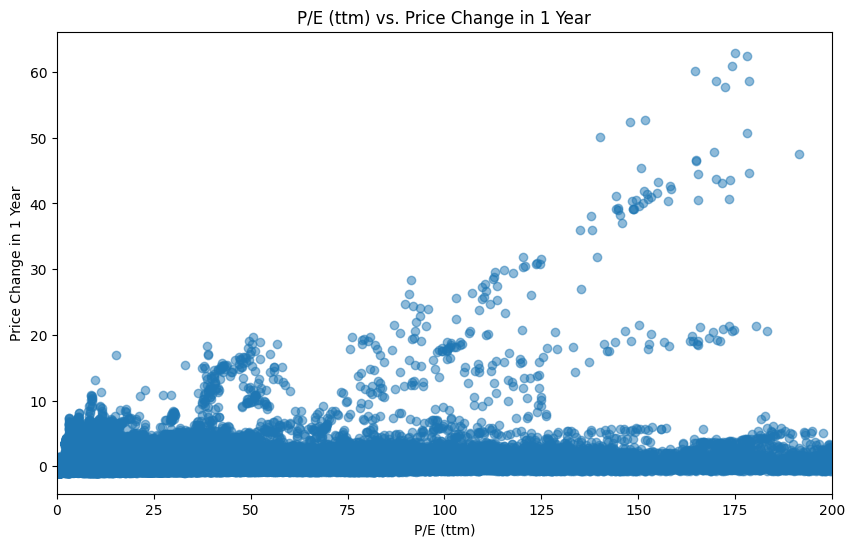

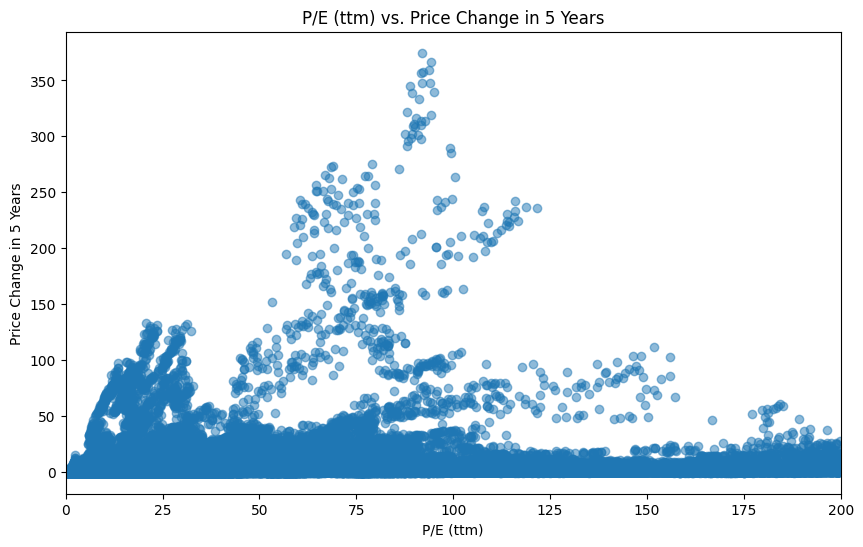

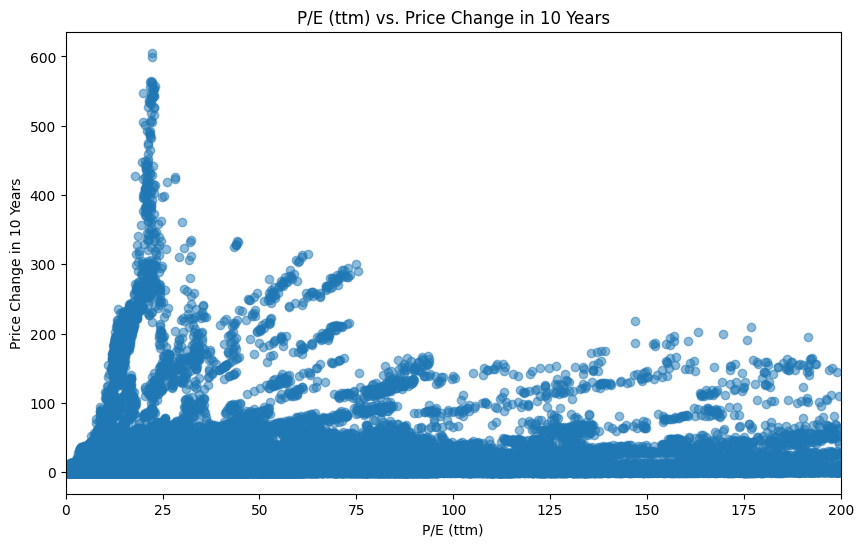

/var/folders/wm/fydrjt2543sch7051n5t7ygc0000gs/T/ipykernel_20844/824239813.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_5yr_filtered['PE_Bin'] = pd.cut(df_5yr_filtered['P/E (ttm)'], bins)
/var/folders/wm/fydrjt2543sch7051n5t7ygc0000gs/T/ipykernel_20844/824239813.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = df_5yr_filtered.groupby('PE_Bin')['Price_Change_5Y'].median()


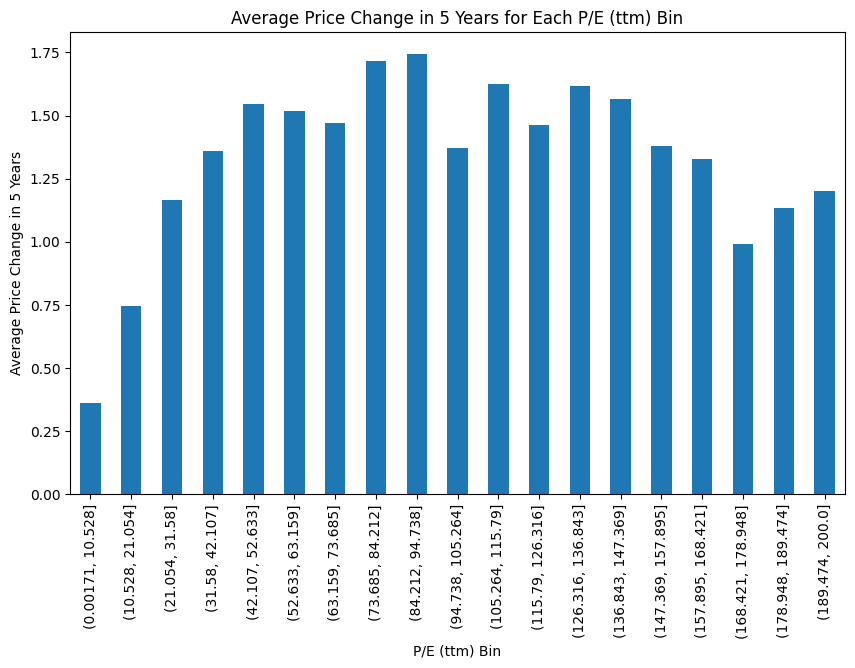

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load data from CSV files
df_1yr = pd.read_csv("../stocks_with_1yr_price_change.csv")
df_5yr = pd.read_csv("../stocks_with_5yr_price_change.csv")
df_10yr = pd.read_csv("../stocks_with_10yr_price_change.csv")

# Convert 'Date' column to datetime
df_1yr['Date'] = pd.to_datetime(df_1yr['Date'])
df_5yr['Date'] = pd.to_datetime(df_5yr['Date'])
df_10yr['Date'] = pd.to_datetime(df_10yr['Date'])

# Filter data for P/E (ttm) values in the range of -100 to 100+
df_1yr_filtered = df_1yr[(df_1yr['P/E (ttm)'] >= 0) & (df_1yr['P/E (ttm)'] <= 200)]
df_5yr_filtered = df_5yr[(df_5yr['P/E (ttm)'] >= 0) & (df_5yr['P/E (ttm)'] <= 200)]
df_10yr_filtered = df_10yr[(df_10yr['P/E (ttm)'] >= 0) & (df_10yr['P/E (ttm)'] <= 200)]

# Plot P/E (ttm) vs. Price Change in 1 Year
plt.figure(figsize=(10, 6))
plt.scatter(df_1yr_filtered['P/E (ttm)'], df_1yr_filtered['Price_Change_1Y'], alpha=0.5)
plt.xlabel("P/E (ttm)")
plt.ylabel("Price Change in 1 Year")
plt.title("P/E (ttm) vs. Price Change in 1 Year")
plt.xlim(0, 200)
plt.show()

# Plot P/E (ttm) vs. Price Change in 5 Years
plt.figure(figsize=(10, 6))
plt.scatter(df_5yr_filtered['P/E (ttm)'], df_5yr_filtered['Price_Change_5Y'], alpha=0.5)
plt.xlabel("P/E (ttm)")
plt.ylabel("Price Change in 5 Years")
plt.title("P/E (ttm) vs. Price Change in 5 Years")
plt.xlim(0, 200)
plt.show()

# Plot P/E (ttm) vs. Price Change in 10 Years
plt.figure(figsize=(10, 6))
plt.scatter(df_10yr_filtered['P/E (ttm)'], df_10yr_filtered['Price_Change_10Y'], alpha=0.5)
plt.xlabel("P/E (ttm)")
plt.ylabel("Price Change in 10 Years")
plt.title("P/E (ttm) vs. Price Change in 10 Years")
plt.xlim(0, 200)
plt.show()

# Plot the average 5-year price change for each P/E (ttm) ratio bin
plt.figure(figsize=(10, 6))
bins = np.linspace(df_10yr_filtered['P/E (ttm)'].min(), df_10yr_filtered['P/E (ttm)'].max(), 20)
df_10yr_filtered['PE_Bin'] = pd.cut(df_5yr_filtered['P/E (ttm)'], bins)
bin_means = df_10yr_filtered.groupby('PE_Bin')['Price_Change_10Y'].median()
bin_means.plot(kind='bar')
plt.xlabel("P/E (ttm) Bin")
plt.ylabel("Average Price Change in 10 Years")
plt.title("Average Price Change in 10 Years for Each P/E (ttm) Bin")
plt.show()

In [ ]:

import pandas as pd
from sklearn.linear_model import LinearRegression

df = pd.read_csv("../stocks_with_1yr_price_change.csv")

# Take a 10% sample
df_sample = df.sample(frac=0.1, random_state=42)

# Prepare features (X) and target (y)
X = df_sample[["Adjusted Close", "Volume", "P/E (ttm)", "MA_50", "MA_200"]]
y = df_sample["Price_Change_1Y"]

# Fit the model
model = LinearRegression()
model.fit(X, y)

# Print results
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)
print("R^2 Score:", model.score(X, y))


# Random Forest

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Read CSV files
df_1 = pd.read_csv("../stocks_with_1yr_price_change.csv")
df_5 = pd.read_csv("../stocks_with_5yr_price_change.csv")
df_10 = pd.read_csv("../stocks_with_10yr_price_change.csv")

# Take a % sample
df_sample_1 = df_1.sample(frac=.01, random_state=42)
df_sample_5 = df_5.sample(frac=.01, random_state=42)
df_sample_10 = df_10.sample(frac=.01, random_state=42)

# Sample one row per Symbol
# df_sample_1 = df_1.groupby('Symbol').sample(n=1)
# df_sample_5 = df_5.groupby('Symbol').sample(n=1)
# df_sample_10 = df_10.groupby('Symbol').sample(n=1)



# Features for models
features = ['Adjusted Close', 'Volume', 'P/E (ttm)', 'MA_50/Adj_Close', 'MA_200/Adj_Close'] # add 1-day change

# Random Forest for 1-year price change
X_1 = df_sample_1[features]
y_1 = df_sample_1['Price_Change_1Y']
model_rf_1 = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf_1.fit(X_1, y_1)

# Random Forest for 5-year price change
X_5 = df_sample_5[features]
y_5 = df_sample_5['Price_Change_5Y']
model_rf_5 = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf_5.fit(X_5, y_5)

# Random Forest for 10-year price change
X_10 = df_sample_10[features]
y_10 = df_sample_10['Price_Change_10Y']
model_rf_10 = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf_10.fit(X_10, y_10)

# Print results
def print_model_results(model, features, period):
    print(f"\nRandom Forest Results for {period}-year price change:")
    print("R² Score:", model.score(X_1, y_1))
    print("\nFeature Importances:")
    for feature, importance in zip(features, model.feature_importances_):
        print(f"{feature}: {importance:.4f}")

print_model_results(model_rf_1, features, 1)
print_model_results(model_rf_5, features, 5)
print_model_results(model_rf_10, features, 10)


Random Forest Results for 1-year price change:
R² Score: 0.8979726057040628

Feature Importances:
Adjusted Close: 0.0738
Volume: 0.0943
P/E (ttm): 0.1660
MA_50/Adj_Close: 0.1789
MA_200/Adj_Close: 0.4869

Random Forest Results for 5-year price change:
R² Score: -6.524833146775142

Feature Importances:
Adjusted Close: 0.2533
Volume: 0.1704
P/E (ttm): 0.2129
MA_50/Adj_Close: 0.1603
MA_200/Adj_Close: 0.2031

Random Forest Results for 10-year price change:
R² Score: -169.06151509732751

Feature Importances:
Adjusted Close: 0.2884
Volume: 0.2255
P/E (ttm): 0.2811
MA_50/Adj_Close: 0.0923
MA_200/Adj_Close: 0.1128


# Optimize random forest

Optimizing 1-Year Model...
Fitting 5 folds for each of 50 candidates, totalling 250 fits


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


KeyboardInterrupt: 

# Random Forest w/ Econ. Ind.

In [25]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import pickle
from datetime import datetime

# Read CSV files
df_1 = pd.read_csv("/Users/daniellott2/Documents/stock-program/src/data/stocks_with_1yr_price_change.csv")
df_5 = pd.read_csv("/Users/daniellott2/Documents/stock-program/src/data/stocks_with_5yr_price_change.csv")
df_10 = pd.read_csv("/Users/daniellott2/Documents/stock-program/src/data/stocks_with_10yr_price_change.csv")

# Convert 'Date' column to datetime
df_1['Date'] = pd.to_datetime(df_1['Date'])
df_5['Date'] = pd.to_datetime(df_5['Date'])
df_10['Date'] = pd.to_datetime(df_10['Date'])

# Check if economic indicators are already in the dataframes
print("Columns in df_1:", df_1.columns)

# Economic indicators to be added to features
econ_indicators = [
    'CPI', 
    'Fed_Funds_Rate', 
    'GDP_Per_Capita', 
    'Inflation_Rate', 
    'Real_GDP', 
    'Treasury_Yield', 
    'Unemployment_Rate'
]

# Define a time-based train-test split function
def time_based_train_test_split(df, date_col="Date", cutoff_date="2017-12-31"):
    cutoff = pd.to_datetime(cutoff_date)
    train = df[df[date_col] <= cutoff].copy()
    test = df[df[date_col] > cutoff].copy()
    return train, test

# Prepare features and extract one row per symbol per month to increase observations
def prepare_dataset(df, sample_freq='M'):
    # Add year-month column for monthly sampling
    df['YearMonth'] = df['Date'].dt.to_period(sample_freq)
    
    # Get one row per symbol per month (or whatever frequency chosen)
    df_sample = (df
                .sort_values(['Symbol', 'Date'])  # Ensure chronological order
                .groupby(['Symbol', 'YearMonth'])
                .tail(1)  # Take the last observation for each Symbol-Month
                .reset_index(drop=True))
    
    return df_sample

# Sample size can be controlled by changing 'M' (monthly) to:
# 'W' for weekly samples (many more observations)
# 'Q' for quarterly samples (fewer observations)
# 'D' for daily samples (maximum observations, but may be too large)
sampling_frequency = 'M'  # Monthly sampling

# Prepare all three datasets with increased observations
df_sample_1 = prepare_dataset(df_1, sampling_frequency)
df_sample_5 = prepare_dataset(df_5, sampling_frequency)
df_sample_10 = prepare_dataset(df_10, sampling_frequency)

# Split into train/test using end of 2017 as cutoff
train_1, test_1 = time_based_train_test_split(df_sample_1)
train_5, test_5 = time_based_train_test_split(df_sample_5)
train_10, test_10 = time_based_train_test_split(df_sample_10)

print(f"1-year dataset: {len(train_1)} training samples, {len(test_1)} test samples")
print(f"5-year dataset: {len(train_5)} training samples, {len(test_5)} test samples")
print(f"10-year dataset: {len(train_10)} training samples, {len(test_10)} test samples")

print(f"Training period: {train_1['Date'].min()} to {train_1['Date'].max()}")
print(f"Testing period: {test_1['Date'].min()} to {test_1['Date'].max()}")

# Original features
base_features = ['Adjusted Close', 'Volume', 'P/E (ttm)', 'MA_50/Adj_Close', 'MA_200/Adj_Close']

# Combined features (base features + economic indicators)
features = base_features + [col for col in econ_indicators if col in df_sample_1.columns]

print(f"Using features: {features}")

# The rest of your code remains the same...
# Function to train models with proper train/test evaluation
def train_and_evaluate(X_train, y_train, X_test=None, y_test=None, model_name="model"):
    model = RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_leaf=20,
                                 n_jobs=-1, random_state=42)
    model.fit(X_train, y_train)
    
    # Calculate in-sample and out-of-sample R² if test data is provided
    train_r2 = model.score(X_train, y_train)
    test_r2 = model.score(X_test, y_test) if X_test is not None else None
    
    print(f"{model_name} - Training R²: {train_r2:.4f}")
    if test_r2 is not None:
        print(f"{model_name} - Out-of-sample R²: {test_r2:.4f}")
    
    # Feature importance analysis
    feature_imp = pd.Series(model.feature_importances_, index=X_train.columns)
    top_features = feature_imp.sort_values(ascending=False).head(10)
    print("\nTop 10 features by importance:")
    for feature, importance in top_features.items():
        print(f"{feature}: {importance:.4f}")
        
    return model

# Train models with available features
X_train_1 = train_1[features]
y_train_1 = train_1['Price_Change_1Y']
X_test_1 = test_1[features] if not test_1.empty else None
y_test_1 = test_1['Price_Change_1Y'] if not test_1.empty else None

X_train_5 = train_5[features]
y_train_5 = train_5['Price_Change_5Y']
X_test_5 = test_5[features] if not test_5.empty else None
y_test_5 = test_5['Price_Change_5Y'] if not test_5.empty else None

X_train_10 = train_10[features]
y_train_10 = train_10['Price_Change_10Y']
X_test_10 = test_10[features] if not test_10.empty else None
y_test_10 = test_10['Price_Change_10Y'] if not test_10.empty else None

# Train models and save them
model_rf_1 = train_and_evaluate(X_train_1, y_train_1, X_test_1, y_test_1, "1-Year Model")
model_rf_5 = train_and_evaluate(X_train_5, y_train_5, X_test_5, y_test_5, "5-Year Model")
model_rf_10 = train_and_evaluate(X_train_10, y_train_10, X_test_10, y_test_10, "10-Year Model")

# Save models with date of last training data
last_train_year = train_1['Date'].max().year
print(f"\nSaving models trained with data up to {last_train_year}...")

pickle.dump(model_rf_1, open(f"model_rf_1_until_{last_train_year}.pkl", "wb"))
pickle.dump(model_rf_5, open(f"model_rf_5_until_{last_train_year}.pkl", "wb"))
pickle.dump(model_rf_10, open(f"model_rf_10_until_{last_train_year}.pkl", "wb"))

print("Models saved successfully.")

Columns in df_1: Index(['Symbol', 'Date', 'Open', 'High', 'Low', 'Close', 'Adjusted Close',
       'Volume', 'Dividend Amount', 'Split Coefficient', 'Earnings',
       'P/E Ratio', 'EPS (ttm)', 'P/E (ttm)', 'CPI', 'Fed_Funds_Rate',
       'GDP_Per_Capita', 'Inflation_Rate', 'Real_GDP', 'Treasury_Yield',
       'Unemployment_Rate', 'MA_50', 'MA_200', 'Price_Change_1Y',
       'Price_Change_5Y', 'Price_Change_10Y', 'MA_50/Adj_Close',
       'MA_200/Adj_Close'],
      dtype='object')
1-year dataset: 93340 training samples, 33422 test samples
5-year dataset: 68108 training samples, 31704 test samples
10-year dataset: 38789 training samples, 29272 test samples
Training period: 2001-08-31 00:00:00 to 2017-12-29 00:00:00
Testing period: 2018-01-31 00:00:00 to 2022-12-30 00:00:00
Using features: ['Adjusted Close', 'Volume', 'P/E (ttm)', 'MA_50/Adj_Close', 'MA_200/Adj_Close', 'CPI', 'Fed_Funds_Rate', 'GDP_Per_Capita', 'Inflation_Rate', 'Real_GDP', 'Treasury_Yield', 'Unemployment_Rate']
1-Year M

# Random Forest Hyperparameter Tuning

In [2]:

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt

def optimize_random_forest(X_train, y_train, X_test=None, y_test=None):
    """
    Find optimal hyperparameters for a Random Forest model using time-based cross-validation
    
    Parameters:
    -----------
    X_train : DataFrame
        Feature matrix for training
    y_train : Series
        Target variable for training
    X_test : DataFrame, optional
        Feature matrix for testing
    y_test : Series, optional
        Target variable for testing
        
    Returns:
    --------
    best_model : RandomForestRegressor
        Optimized model
    best_params : dict
        Best hyperparameters
    """
    # Define the parameter grid
    param_grid = {
        'n_estimators': [50, 100, 200, 400],
        'max_depth': [3, 5, 7, 10, 15, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4, 8, 16],
        'max_features': ['sqrt', 'log2', None]
    }
    
    # Initialize time series cross-validation
    tscv = TimeSeriesSplit(n_splits=5)
    
    # Initialize RandomForestRegressor
    rf = RandomForestRegressor(random_state=42, n_jobs=-1)
    
    # Initialize RandomizedSearchCV
    search = RandomizedSearchCV(
        estimator=rf,
        param_distributions=param_grid,
        n_iter=50,  # Number of parameter settings to sample
        cv=tscv,
        scoring='neg_mean_absolute_error',  # Could also use 'r2'
        random_state=42,
        n_jobs=-1,
        verbose=1
    )
    
    # Fit RandomizedSearchCV
    search.fit(X_train, y_train)
    
    # Get best parameters
    best_params = search.best_params_
    best_score = search.best_score_
    
    print(f"Best parameters: {best_params}")
    print(f"Best cross-validation score: {-best_score:.4f} MAE")
    
    # Create the best model
    best_model = RandomForestRegressor(**best_params, random_state=42)
    best_model.fit(X_train, y_train)
    
    # Evaluate on training set
    train_r2 = best_model.score(X_train, y_train)
    print(f"Training R²: {train_r2:.4f}")
    
    # Evaluate on test set if provided
    if X_test is not None and y_test is not None:
        test_r2 = best_model.score(X_test, y_test)
        test_mae = mean_absolute_error(y_test, best_model.predict(X_test))
        print(f"Test R²: {test_r2:.4f}")
        print(f"Test MAE: {test_mae:.4f}")
    
    # Plot feature importances
    feature_importances = pd.Series(best_model.feature_importances_, index=X_train.columns)
    plt.figure(figsize=(10, 6))
    feature_importances.sort_values(ascending=False).head(15).plot(kind='barh')
    plt.title('Feature Importances (Tuned Model)')
    plt.tight_layout()
    plt.show()
    
    return best_model, best_params

# Apply the optimization to your current models
# print("Optimizing 1-Year Model...")
# model_rf_1_optimized, best_params_1 = optimize_random_forest(X_train_1, y_train_1, X_test_1, y_test_1)

# print("\nOptimizing 5-Year Model...")
# model_rf_5_optimized, best_params_5 = optimize_random_forest(X_train_5, y_train_5, X_test_5, y_test_5)

print("\nOptimizing 10-Year Model...")
model_rf_10_optimized, best_params_10 = optimize_random_forest(X_train_10, y_train_10, X_test_10, y_test_10)

# Save the optimized models
last_train_year = train_1['Date'].max().year
print(f"\nSaving optimized models trained with data up to {last_train_year}...")

# pickle.dump(model_rf_1_optimized, open(f"model_rf_1_optimized_until_{last_train_year}.pkl", "wb"))
# pickle.dump(model_rf_5_optimized, open(f"model_rf_5_optimized_until_{last_train_year}.pkl", "wb"))
pickle.dump(model_rf_10_optimized, open(f"model_rf_10_optimized_until_{last_train_year}.pkl", "wb"))

print("Optimized models saved successfully.")

# Compare original vs optimized models
# print("\nModel Performance Comparison:")
# print("1-Year Model:")
# print(f"  Original - Training R²: {model_rf_1.score(X_train_1, y_train_1):.4f}, Testing R²: {model_rf_1.score(X_test_1, y_test_1):.4f}")
# print(f"  Optimized - Training R²: {model_rf_1_optimized.score(X_train_1, y_train_1):.4f}, Testing R²: {model_rf_1_optimized.score(X_test_1, y_test_1):.4f}")

# print("5-Year Model:")
# print(f"  Original - Training R²: {model_rf_5.score(X_train_5, y_train_5):.4f}, Testing R²: {model_rf_5.score(X_test_5, y_test_5):.4f}")
# print(f"  Optimized - Training R²: {model_rf_5_optimized.score(X_train_5, y_train_5):.4f}, Testing R²: {model_rf_5_optimized.score(X_test_5, y_test_5):.4f}")

print("10-Year Model:")
print(f"  Original - Training R²: {model_rf_10.score(X_train_10, y_train_10):.4f}, Testing R²: {model_rf_10.score(X_test_10, y_test_10):.4f}")
print(f"  Optimized - Training R²: {model_rf_10_optimized.score(X_train_10, y_train_10):.4f}, Testing R²: {model_rf_10_optimized.score(X_test_10, y_test_10):.4f}")

# Calculate the R² improvement
# r2_imp_1 = (model_rf_1_optimized.score(X_test_1, y_test_1) - model_rf_1.score(X_test_1, y_test_1))
# r2_imp_5 = (model_rf_5_optimized.score(X_test_5, y_test_5) - model_rf_5.score(X_test_5, y_test_5))
r2_imp_10 = (model_rf_10_optimized.score(X_test_10, y_test_10) - model_rf_10.score(X_test_10, y_test_10))

print("\nOut-of-sample R² improvement:")
# print(f"1-Year Model: {r2_imp_1:.4f} absolute improvement")
# print(f"5-Year Model: {r2_imp_5:.4f} absolute improvement")
print(f"10-Year Model: {r2_imp_10:.4f} absolute improvement")

# Learning curves visualization
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, X, y, title, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a plot of the learning curve showing train and test scores by training set size
    """
    plt.figure(figsize=(10, 6))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='r2')
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    return plt

# Plot learning curves for optimized models
tscv = TimeSeriesSplit(n_splits=5)
# plot_learning_curve(model_rf_1_optimized, X_train_1, y_train_1, 
#                    title=f"Learning Curves (1-Year Optimized Model)", 
#                    cv=tscv, n_jobs=-1)
# plt.show()

# plot_learning_curve(model_rf_5_optimized, X_train_5, y_train_5, 
#                    title=f"Learning Curves (5-Year Optimized Model)", 
#                    cv=tscv, n_jobs=-1)
# plt.show()

plot_learning_curve(model_rf_10_optimized, X_train_10, y_train_10, 
                   title=f"Learning Curves (10-Year Optimized Model)", 
                   cv=tscv, n_jobs=-1)
plt.show()


Optimizing 10-Year Model...


NameError: name 'X_train_10' is not defined

# Random Forest Backtesting

Loading data from /Users/daniellott2/Documents/stock-program/stocks_with_1yr_price_change.csv...
Data loaded successfully with 2652228 rows.
Available columns: ['Symbol', 'Date', 'Open', 'High', 'Low', 'Close', 'Adjusted Close', 'Volume', 'Dividend Amount', 'Split Coefficient', 'Earnings', 'P/E Ratio', 'EPS (ttm)', 'P/E (ttm)', 'CPI', 'Fed_Funds_Rate', 'GDP_Per_Capita', 'Inflation_Rate', 'Real_GDP', 'Treasury_Yield', 'Unemployment_Rate', 'MA_50', 'MA_200', 'Price_Change_1Y', 'Price_Change_5Y', 'Price_Change_10Y', 'MA_50/Adj_Close', 'MA_200/Adj_Close']
Economic indicators found: ['CPI', 'Fed_Funds_Rate', 'GDP_Per_Capita', 'Inflation_Rate', 'Real_GDP', 'Treasury_Yield', 'Unemployment_Rate']
Model loaded successfully.
Using these available features: ['Adjusted Close', 'Volume', 'P/E (ttm)', 'MA_50/Adj_Close', 'MA_200/Adj_Close', 'CPI', 'Fed_Funds_Rate', 'GDP_Per_Capita', 'Inflation_Rate', 'Real_GDP', 'Treasury_Yield', 'Unemployment_Rate']
Training period: 2001 to 2017
Testing period: 2018

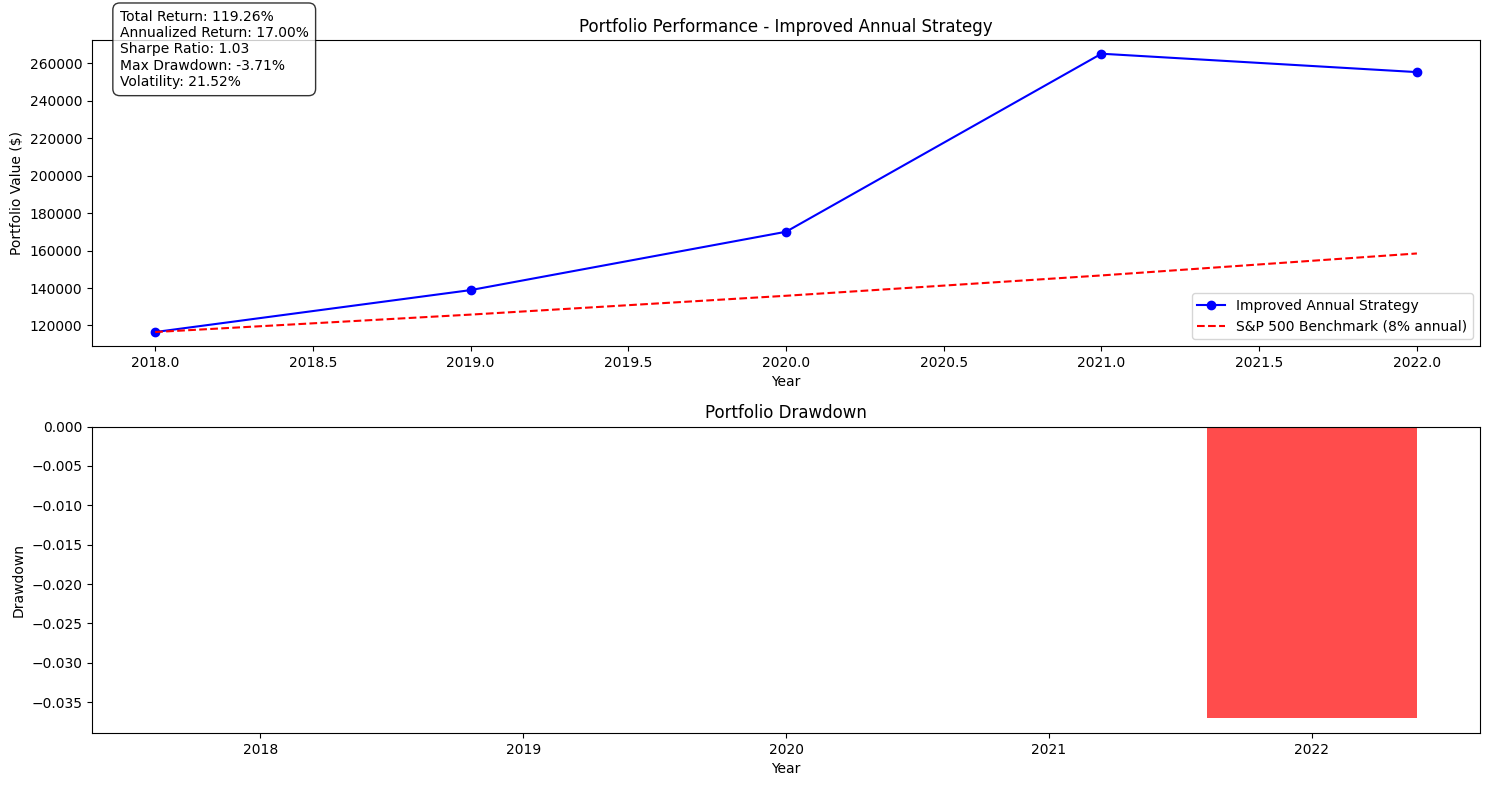

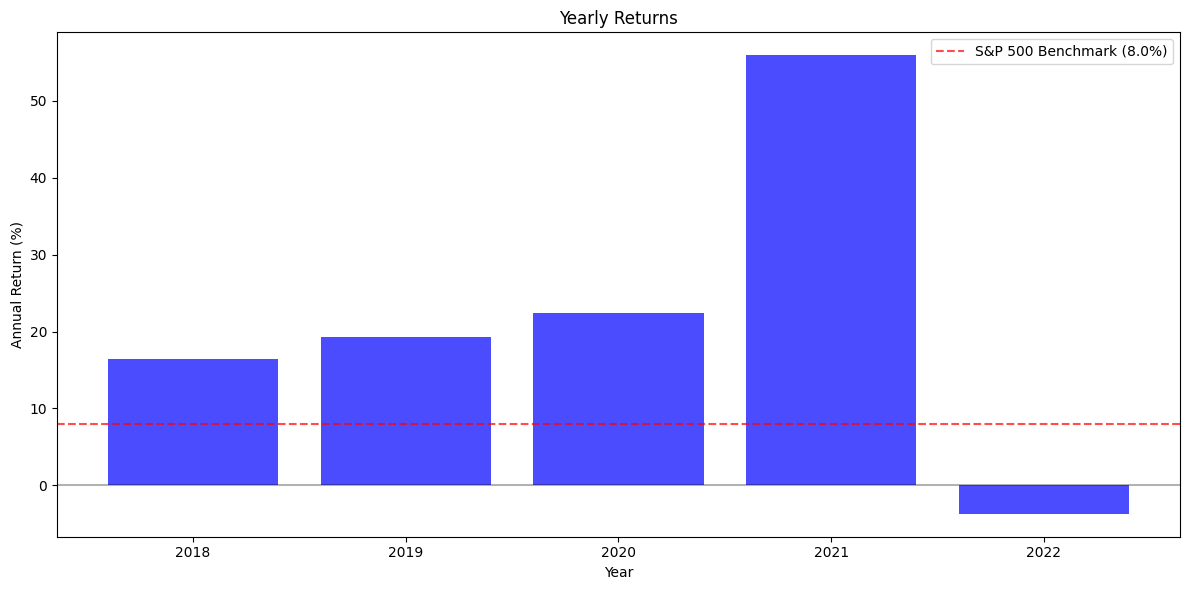


Yearly Position Statistics:
     Actual_Return                                      Contributed_Return
              mean       min        max       std count                sum
Year                                                                      
2018      0.165424 -0.392772   1.371579  0.354679    54           0.165424
2019      0.194317 -0.239260   0.619025  0.205369    54           0.194317
2020      0.226292 -0.495754   3.315298  0.630650    55           0.226292
2021      0.561096 -0.569836  10.791304  1.483231    56           0.561096
2022     -0.035449 -0.518119   0.652662  0.301577    56          -0.035449
Results saved to CSV files.


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
from datetime import datetime, timedelta

def generate_point_in_time_signals(df_snapshot, model, feature_cols, signal_date, top_pct=0.2):
    """
    Generate signals using only information available on the signal_date
    
    Parameters:
      df_snapshot: DataFrame containing stock data as of signal_date
      model: trained model that predicts returns
      feature_cols: list of feature column names
      signal_date: the date on which signals are generated
      top_pct: fraction of stocks to select (e.g., 0.2 means top 20%)
    """
    # Make sure all required feature columns are available
    available_features = [col for col in feature_cols if col in df_snapshot.columns]
    
    if not available_features:
        print(f"Warning: None of the required features found in the dataset for {signal_date}")
        return pd.DataFrame()
    
    # Extract features
    X = df_snapshot[available_features]
    
    try:
        # Predict returns using the model
        df_snapshot = df_snapshot.copy()
        df_snapshot['Predicted_Return'] = model.predict(X)
        
        # Rank stocks by predicted return (highest first)
        df_sorted = df_snapshot.sort_values(by='Predicted_Return', ascending=False)
        
        # Select top N% stocks
        top_n = max(int(len(df_sorted) * top_pct), 1)  # Always select at least one stock
        selected_stocks = df_sorted.iloc[:top_n].copy()
        selected_stocks['Signal'] = 1
        
        return selected_stocks[['Symbol', 'Signal', 'Predicted_Return']]
    
    except Exception as e:
        print(f"Error generating signals for {signal_date}: {str(e)}")
        return pd.DataFrame()

def get_forward_returns(df, selected_symbols, signal_date, horizon_days=252):
    """
    Calculate the actual forward returns for selected stocks from signal_date
    
    Parameters:
      df: Full DataFrame with historical prices
      selected_symbols: list of symbols selected on signal_date
      signal_date: date when the selection was made
      horizon_days: number of trading days for the investment horizon
    """
    returns_data = []
    
    for symbol in selected_symbols:
        # Get price data for this symbol
        symbol_data = df[df['Symbol'] == symbol].sort_values('Date')
        
        # Find the record closest to the signal date (but not after)
        entry_data = symbol_data[symbol_data['Date'] <= signal_date].iloc[-1:] if not symbol_data.empty else None
        
        if entry_data is not None and not entry_data.empty:
            entry_date = entry_data['Date'].iloc[0]
            entry_price = entry_data['Adjusted Close'].iloc[0]
            
            # Find price at the end of the horizon
            exit_data = symbol_data[symbol_data['Date'] >= (entry_date + timedelta(days=horizon_days))].iloc[:1]
            
            if not exit_data.empty:
                exit_date = exit_data['Date'].iloc[0]
                exit_price = exit_data['Adjusted Close'].iloc[0]
                actual_return = (exit_price / entry_price) - 1
                
                returns_data.append({
                    'Symbol': symbol,
                    'Entry_Date': entry_date,
                    'Exit_Date': exit_date,
                    'Entry_Price': entry_price,
                    'Exit_Price': exit_price,
                    'Actual_Return': actual_return
                })
            else:
                # Handle stocks that didn't survive the full horizon
                # Find the last available price
                last_data = symbol_data[symbol_data['Date'] > entry_date].iloc[-1:] if not symbol_data[symbol_data['Date'] > entry_date].empty else None
                
                if last_data is not None and not last_data.empty:
                    exit_date = last_data['Date'].iloc[0]
                    exit_price = last_data['Adjusted Close'].iloc[0]
                    actual_return = (exit_price / entry_price) - 1
                    
                    returns_data.append({
                        'Symbol': symbol,
                        'Entry_Date': entry_date,
                        'Exit_Date': exit_date,
                        'Entry_Price': entry_price,
                        'Exit_Price': exit_price,
                        'Actual_Return': actual_return,
                        'Incomplete_Horizon': True
                    })
                else:
                    # No future data available (extreme case)
                    returns_data.append({
                        'Symbol': symbol,
                        'Entry_Date': entry_date,
                        'Exit_Date': None,
                        'Entry_Price': entry_price,
                        'Exit_Price': None,
                        'Actual_Return': -1.0,  # Assume total loss as worst case
                        'Incomplete_Horizon': True
                    })
    
    return pd.DataFrame(returns_data)

def improved_annual_backtest(df, model, feature_cols, initial_capital=100000, top_pct=0.2, 
                            transaction_cost=0.001, horizon_days=252):
    """
    Improved backtest with point-in-time signal generation and proper handling of survivorship
    
    Parameters:
      df: DataFrame containing stock data with columns including Date, Symbol, features
      model: trained model that predicts returns
      feature_cols: list of feature column names
      initial_capital: starting portfolio value
      top_pct: fraction of stocks to select
      transaction_cost: cost per transaction as a fraction
      horizon_days: number of trading days for the investment horizon (typically 252 for 1 year)
    """
    # Ensure Date is datetime and the data is sorted
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values(['Symbol', 'Date'])
    
    # Check which features are available
    available_features = [col for col in feature_cols if col in df.columns]
    if not available_features:
        print(f"Error: No features from {feature_cols} found in the dataframe.")
        print(f"Available columns: {df.columns.tolist()}")
        return pd.DataFrame()
    
    print(f"Using these available features: {available_features}")
    
    # Get list of years for the backtest
    df['Year'] = df['Date'].dt.year
    years = df['Year'].unique()
    years.sort()
    
    # Use 80% of years for training, 20% for testing
    split_idx = int(len(years) * 0.8)
    train_years = years[:split_idx]
    test_years = years[split_idx:]
    
    print(f"Training period: {min(train_years)} to {max(train_years)}")
    print(f"Testing period: {min(test_years)} to {max(test_years)}")
    print(f"Number of years in test period: {len(test_years)}")
    
    # Initialize portfolio metrics
    portfolio_value = initial_capital
    portfolio_history = []
    position_history = []
    prev_positions = set()
    
    for i, year in enumerate(test_years):
        # Find the first trading day of the year for signal generation
        year_data = df[df['Year'] == year]
        if year_data.empty:
            print(f"No data for year {year}, skipping...")
            continue
        
        # Get the first date of the year that has data
        signal_date = year_data['Date'].min()
        
        # Get only data as of signal_date (point-in-time snapshot)
        snapshot = df[df['Date'] <= signal_date].groupby('Symbol').last().reset_index()
        
        # Ensure we have enough symbols in the snapshot
        if len(snapshot) < 5:  # Arbitrary minimum
            print(f"Too few symbols ({len(snapshot)}) available for year {year}, skipping...")
            continue
        
        # Generate signals
        selected_stocks = generate_point_in_time_signals(
            snapshot, model, available_features, signal_date, top_pct
        )
        
        if selected_stocks.empty:
            print(f"No stocks selected for {year}, skipping...")
            continue
        
        # Get forward returns for selected stocks
        selected_symbols = selected_stocks['Symbol'].tolist()
        forward_returns = get_forward_returns(df, selected_symbols, signal_date, horizon_days)
        
        if forward_returns.empty:
            print(f"No forward returns available for {year}, skipping...")
            continue
        
        # Calculate portfolio return
        num_selected = len(forward_returns)
        weight = 1.0 / num_selected if num_selected > 0 else 0
        
        # Calculate turnover and transaction costs
        current_positions = set(selected_symbols)
        turnover_ratio = (len(current_positions.symmetric_difference(prev_positions)) / 
                         max(len(current_positions), len(prev_positions)) if 
                         max(len(current_positions), len(prev_positions)) > 0 else 0)
        
        transaction_cost_effect = turnover_ratio * transaction_cost
        annual_return = (forward_returns['Actual_Return'] * weight).sum() - transaction_cost_effect
        
        # Update portfolio value
        portfolio_value *= (1 + annual_return)
        
        # Record this year's performance
        portfolio_history.append({
            'Year': year,
            'Signal_Date': signal_date,
            'Portfolio_Value': portfolio_value,
            'Annual_Return': annual_return,
            'Num_Stocks': num_selected,
            'Turnover': turnover_ratio,
            'Transaction_Cost': transaction_cost_effect
        })
        
        # Record position details
        for _, row in forward_returns.iterrows():
            position_info = {
                'Year': year,
                'Symbol': row['Symbol'],
                'Entry_Date': row['Entry_Date'],
                'Exit_Date': row['Exit_Date'],
                'Actual_Return': row['Actual_Return'],
                'Weight': weight,
                'Contributed_Return': row['Actual_Return'] * weight
            }
            
            # Add incomplete horizon flag if it exists
            if 'Incomplete_Horizon' in row:
                position_info['Incomplete_Horizon'] = row['Incomplete_Horizon']
                
            position_history.append(position_info)
            
        # Update previous positions for next iteration
        prev_positions = current_positions
        
        print(f"Year {year}: Selected {num_selected} stocks, Annual Return = {annual_return:.2%}, Portfolio Value = ${portfolio_value:.2f}")
    
    # Convert results to DataFrames
    portfolio_df = pd.DataFrame(portfolio_history)
    positions_df = pd.DataFrame(position_history)
    
    return portfolio_df, positions_df

def compute_metrics(portfolio_df):
    """Compute performance metrics from the portfolio history."""
    if portfolio_df.empty:
        return None
    
    # Calculate returns
    total_return = (portfolio_df['Portfolio_Value'].iloc[-1] / portfolio_df['Portfolio_Value'].iloc[0]) - 1
    
    # Calculate annualized return
    years = len(portfolio_df)
    annualized_return = (1 + total_return) ** (1 / years) - 1 if years > 0 else 0
    
    # Risk metrics
    annual_returns = portfolio_df['Annual_Return']
    
    # Handle edge cases
    if len(annual_returns) < 2 or annual_returns.std() == 0:
        return {
            'Total Return': total_return * 100,
            'Annualized Return': annualized_return * 100,
            'Sharpe Ratio': 0,
            'Max Drawdown': 0,
            'Volatility (Annual)': 0
        }
    
    # Sharpe ratio (assuming risk-free rate = 0 for simplicity)
    sharpe = annual_returns.mean() / annual_returns.std()
    
    # Max drawdown
    cummax = portfolio_df['Portfolio_Value'].cummax()
    drawdown = (portfolio_df['Portfolio_Value'] - cummax) / cummax
    max_drawdown = drawdown.min()
    
    # Annual volatility
    volatility = annual_returns.std()
    
    return {
        'Total Return': total_return * 100,
        'Annualized Return': annualized_return * 100,
        'Sharpe Ratio': sharpe,
        'Max Drawdown': max_drawdown * 100,
        'Volatility (Annual)': volatility * 100
    }

def plot_performance(portfolio_df, strategy_name="Improved Annual Strategy"):
    """Plot the portfolio performance over time."""
    if portfolio_df.empty:
        print("No data to plot.")
        return
    
    metrics = compute_metrics(portfolio_df)
    
    plt.figure(figsize=(15, 8))
    
    # Plot portfolio value
    plt.subplot(2, 1, 1)
    plt.plot(portfolio_df['Year'], portfolio_df['Portfolio_Value'], 'bo-', label=strategy_name)
    
    # Create benchmark (S&P 500 with 8% annual return)
    initial_value = portfolio_df['Portfolio_Value'].iloc[0]
    benchmark_return = 0.08
    years = portfolio_df['Year'].values
    start_year = years[0]
    benchmark_values = [initial_value * (1 + benchmark_return) ** (year - start_year) for year in years]
    
    plt.plot(portfolio_df['Year'], benchmark_values, 'r--', label='S&P 500 Benchmark (8% annual)')
    
    plt.xlabel('Year')
    plt.ylabel('Portfolio Value ($)')
    plt.title(f'Portfolio Performance - {strategy_name}')
    
    # Add metrics as text
    if metrics:
        text = (f"Total Return: {metrics['Total Return']:.2f}%\n"
                f"Annualized Return: {metrics['Annualized Return']:.2f}%\n"
                f"Sharpe Ratio: {metrics['Sharpe Ratio']:.2f}\n"
                f"Max Drawdown: {metrics['Max Drawdown']:.2f}%\n"
                f"Volatility: {metrics['Volatility (Annual)']:.2f}%")
        
        plt.annotate(text, xy=(0.02, 0.85), xycoords='axes fraction', 
                     bbox=dict(boxstyle="round,pad=0.5", fc="white", alpha=0.8))
    
    plt.legend()
    
    # Plot drawdown
    plt.subplot(2, 1, 2)
    cummax = portfolio_df['Portfolio_Value'].cummax()
    drawdown = (portfolio_df['Portfolio_Value'] - cummax) / cummax
    plt.bar(portfolio_df['Year'], drawdown, color='red', alpha=0.7)
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    plt.xlabel('Year')
    plt.ylabel('Drawdown')
    plt.title('Portfolio Drawdown')
    plt.tight_layout()
    plt.show()
    
    # Plot yearly returns
    plt.figure(figsize=(12, 6))
    plt.bar(portfolio_df['Year'], portfolio_df['Annual_Return'] * 100, color='blue', alpha=0.7)
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    plt.axhline(y=benchmark_return * 100, color='red', linestyle='--', alpha=0.7, 
                label=f'S&P 500 Benchmark ({benchmark_return*100}%)')
    plt.xlabel('Year')
    plt.ylabel('Annual Return (%)')
    plt.title('Yearly Returns')
    plt.legend()
    plt.tight_layout()
    plt.show()

def analyze_positions(positions_df):
    """Analyze the position details to understand what drove performance."""
    if positions_df.empty:
        print("No position data to analyze.")
        return
    
    # Calculate stats by year
    yearly_stats = positions_df.groupby('Year').agg({
        'Actual_Return': ['mean', 'min', 'max', 'std', 'count'],
        'Contributed_Return': 'sum'
    })
    
    print("\nYearly Position Statistics:")
    print(yearly_stats)
    
    # Check for incomplete horizons (stocks that didn't survive)
    if 'Incomplete_Horizon' in positions_df.columns:
        incomplete = positions_df[positions_df['Incomplete_Horizon'] == True]
        complete = positions_df[positions_df['Incomplete_Horizon'] != True]
        
        if not incomplete.empty and not complete.empty:
            print("\nSurvivorship Analysis:")
            print(f"Total positions: {len(positions_df)}")
            print(f"Complete horizons: {len(complete)} ({len(complete)/len(positions_df)*100:.1f}%)")
            print(f"Incomplete horizons: {len(incomplete)} ({len(incomplete)/len(positions_df)*100:.1f}%)")
            
            print("\nReturn comparison:")
            print(f"Mean return of complete positions: {complete['Actual_Return'].mean():.2%}")
            print(f"Mean return of incomplete positions: {incomplete['Actual_Return'].mean():.2%}")
            
            # Plot return distribution
            plt.figure(figsize=(12, 6))
            plt.hist([complete['Actual_Return'], incomplete['Actual_Return']], 
                    bins=20, alpha=0.7, label=['Complete Horizons', 'Incomplete Horizons'])
            plt.xlabel('Return')
            plt.ylabel('Frequency')
            plt.title('Return Distribution: Complete vs Incomplete Horizons')
            plt.legend()
            plt.tight_layout()
            plt.show()

if __name__ == "__main__":
    # Load historical data
    data_path = "/Users/daniellott2/Documents/stock-program/stocks_with_1yr_price_change.csv"
    print(f"Loading data from {data_path}...")
    
    try:
        data = pd.read_csv(data_path)
        print(f"Data loaded successfully with {len(data)} rows.")
        print(f"Available columns: {data.columns.tolist()}")
        
        # Define features
        features = [
            'Adjusted Close', 'Volume', 'P/E (ttm)', 
            'MA_50/Adj_Close', 'MA_200/Adj_Close'
        ]
        
        # Add economic indicators if available
        econ_indicators = [
            'CPI', 'Fed_Funds_Rate', 'GDP_Per_Capita', 'Inflation_Rate', 
            'Real_GDP', 'Treasury_Yield', 'Unemployment_Rate'
        ]
        
        available_features = [col for col in features if col in data.columns]
        available_econ = [col for col in econ_indicators if col in data.columns]
        
        if available_econ:
            print(f"Economic indicators found: {available_econ}")
            available_features.extend(available_econ)
        
        # Load the model
        model_path = "/Users/daniellott2/Documents/stock-program/src/model_rf_1.pkl"
        
        if os.path.exists(model_path):
            with open(model_path, "rb") as f:
                model_rf = pickle.load(f)
            print("Model loaded successfully.")
            
            # Run improved backtest
            portfolio_df, positions_df = improved_annual_backtest(
                data, model_rf, available_features,
                initial_capital=100000,
                top_pct=0.1,
                transaction_cost=0.001,
                horizon_days=252  # 1 year
            )
            
            # Analyze and visualize results
            if not portfolio_df.empty:
                metrics = compute_metrics(portfolio_df)
                
                print("\nBacktesting Results:")
                print(f"Total Return: {metrics['Total Return']:.2f}%")
                print(f"Annualized Return: {metrics['Annualized Return']:.2f}%")
                print(f"Sharpe Ratio: {metrics['Sharpe Ratio']:.2f}")
                print(f"Max Drawdown: {metrics['Max Drawdown']:.2f}%")
                print(f"Volatility: {metrics['Volatility (Annual)']:.2f}%")
                
                # Plot performance
                plot_performance(portfolio_df, "Improved Annual Strategy")
                
                # Analyze positions
                analyze_positions(positions_df)
                
                # Save results
                portfolio_df.to_csv("/Users/daniellott2/Documents/stock-program/improved_annual_backtest_results.csv", index=False)
                positions_df.to_csv("/Users/daniellott2/Documents/stock-program/improved_annual_position_history.csv", index=False)
                print("Results saved to CSV files.")
            else:
                print("Backtesting produced no results.")
        else:
            print(f"Error: Model file not found at {model_path}")
            
    except Exception as e:
        print(f"Error during backtesting: {str(e)}")
        import traceback
        traceback.print_exc()

# Random Forest combined *updated*

In [8]:
# -*- coding: utf-8 -*-
"""
Jupyter‑friendly Stock Model Pipeline
====================================
This single script can live in a notebook cell or be saved as a module and *imported*.
It keeps all of the bias‑mitigations we discussed (time‑series splits, lagged macro data,
yearly model versions, survivorship‑safe returns) but exposes **simple functions** you
can call directly from a Jupyter notebook.

Typical workflow in a notebook
------------------------------
```python
import stock_model_pipeline as smp  # if you saved this as stock_model_pipeline.py

smp.train_all_models()                             # build & save models
pf = smp.walk_forward_backtest_1Y(top_pct=0.1)     # run the 1‑year back‑test
pf.tail()                                          # inspect results
```

Dependencies: pandas, numpy, scikit‑learn, joblib.
"""

from __future__ import annotations

from datetime import timedelta
from pathlib import Path
from typing import List, Tuple

import joblib
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# ---------------------------------------------------------------------------
# CONFIGURATION
# ---------------------------------------------------------------------------
PROJECT_ROOT = Path.cwd()  # works whether run inside a notebook or as a module
DATA_DIR = PROJECT_ROOT / "data"
MODEL_DIR = PROJECT_ROOT / "models"
MODEL_DIR.mkdir(exist_ok=True, parents=True)

BASE_FEATURES = [
    "Adjusted Close",
    "Volume",
    "P/E (ttm)",
    "MA_50/Adj_Close",
    "MA_200/Adj_Close",
]
MACRO_COLS = [
    "CPI",
    "Fed_Funds_Rate",
    "GDP_Per_Capita",
    "Inflation_Rate",
    "Real_GDP",
    "Treasury_Yield",
    "Unemployment_Rate",
]
LAG_DAYS = 60  # macro‑feature lag to remove hindsight (≈ two months)
TEST_SIZE = 0.20  # years reserved for out‑of‑sample during *training*

HORIZON_CONFIG = {
    "1Y": {
        "csv": "stocks_with_1yr_price_change.csv",
        "target": "Price_Change_1Y",
        "days": 252,
        "subdir": "one_year",
    },
    "5Y": {
        "csv": "stocks_with_5yr_price_change.csv",
        "target": "Price_Change_5Y",
        "days": 252 * 5,
        "subdir": "five_year",
    },
    "10Y": {
        "csv": "stocks_with_10yr_price_change.csv",
        "target": "Price_Change_10Y",
        "days": 252 * 10,
        "subdir": "ten_year",
    },
}

# ---------------------------------------------------------------------------
# DATA HELPERS
# ---------------------------------------------------------------------------

def lag_macro_features(df: pd.DataFrame, macro_cols: List[str], lag_days: int = LAG_DAYS) -> pd.DataFrame:
    """Shift macro series backward so row *t* only uses information released ≤ *t*‑lag_days."""
    out = df.copy()
    for c in macro_cols:
        if c in out.columns:
            out[c] = out.groupby("Symbol")[c].shift(lag_days)
    return out


def sample_symbol_year(df: pd.DataFrame) -> pd.DataFrame:
    """Return exactly one observation per Symbol‑Year (last trading day of the year)."""
    tmp = df.copy()
    tmp["Year"] = tmp["Date"].dt.year
    return (tmp.sort_values("Date")
               .groupby(["Symbol", "Year"], sort=False)
               .tail(1)
               .reset_index(drop=True))


def time_based_train_test_split(df: pd.DataFrame, date_col: str = "Date", test_size: float = TEST_SIZE) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Split by *whole calendar years* to avoid leakage."""
    yrs = np.sort(df[date_col].dt.year.unique())
    split_year = yrs[int(len(yrs) * (1 - test_size))]
    train = df[df[date_col].dt.year < split_year].reset_index(drop=True)
    test = df[df[date_col].dt.year >= split_year].reset_index(drop=True)
    return train, test

# ---------------------------------------------------------------------------
# TRAINING
# ---------------------------------------------------------------------------

def _train_rf_model(train_df: pd.DataFrame, test_df: pd.DataFrame, features: List[str], target_col: str):
    Xtr, ytr = train_df[features], train_df[target_col]
    Xte, yte = test_df[features], test_df[target_col]

    model = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("rf", RandomForestRegressor(
            n_estimators=400,
            max_depth=None,
            n_jobs=-1,
            random_state=42,
        )),
    ])
    model.fit(Xtr, ytr)
    r2 = model.score(Xte, yte)
    return model, r2


def train_random_forest_for_horizon(cfg_key: str, verbose: bool = True):
    cfg = HORIZON_CONFIG[cfg_key]
    df = pd.read_csv(DATA_DIR / cfg["csv"], parse_dates=["Date"])

    df = lag_macro_features(df, MACRO_COLS).dropna(subset=BASE_FEATURES + [cfg["target"]])
    df = sample_symbol_year(df)
    features = [c for c in BASE_FEATURES + MACRO_COLS if c in df.columns]

    train_df, test_df = time_based_train_test_split(df)
    model, r2 = _train_rf_model(train_df, test_df, features, cfg["target"])

    last_train_year = train_df["Date"].dt.year.max()
    subdir = MODEL_DIR / cfg["subdir"]
    subdir.mkdir(exist_ok=True, parents=True)
    model_path = subdir / f"model_rf_{cfg_key}_until_{last_train_year}.pkl"
    joblib.dump(model, model_path)

    if verbose:
        print(f"{cfg_key}: OOS R² = {r2:.4f} | saved → {model_path.relative_to(PROJECT_ROOT)}")

    return model_path, r2


def train_all_models():
    """Train 1Y, 5Y, 10Y models; returns dict of horizon → (path, R²)."""
    results = {}
    for key in HORIZON_CONFIG:
        results[key] = train_random_forest_for_horizon(key)
    return results

# ---------------------------------------------------------------------------
# BACK‑TEST HELPERS
# ---------------------------------------------------------------------------

def _load_model_for_year(cfg_key: str, year: int):
    subdir = MODEL_DIR / HORIZON_CONFIG[cfg_key]["subdir"]
    if not subdir.exists():
        return None
    paths = list(subdir.glob("model_rf_*.pkl"))
    viable = []
    for p in paths:
        try:
            cutoff = int(p.stem.split("_until_")[-1])
            if cutoff < year:
                viable.append((cutoff, p))
        except Exception:
            continue
    if not viable:
        return None
    _, chosen = max(viable, key=lambda t: t[0])
    return joblib.load(chosen)


def _generate_signals(snapshot: pd.DataFrame, model, feature_cols: List[str], top_pct: float):
    if model is None:
        return pd.DataFrame()

    feat = [c for c in feature_cols if c in snapshot.columns]
    if not feat:
        return pd.DataFrame()

    X = snapshot[feat]
    snapshot = snapshot.copy()
    snapshot["Pred"] = model.predict(X)
    snapshot = snapshot.sort_values("Pred", ascending=False)
    k = max(int(len(snapshot) * top_pct), 1)
    picks = snapshot.head(k)
    picks["Signal"] = 1
    return picks[["Symbol", "Signal", "Pred"]]


def _forward_returns(df: pd.DataFrame, syms: List[str], signal_date: pd.Timestamp, horizon_days: int):
    out = []
    for s in syms:
        h = df[df["Symbol"] == s].sort_values("Date")
        ent = h[h["Date"] <= signal_date].tail(1)
        if ent.empty:
            continue
        ent_price = ent["Adjusted Close"].iloc[0]
        ent_date = ent["Date"].iloc[0]

        ext = h[h["Date"] >= ent_date + timedelta(days=horizon_days)].head(1)
        incomplete = False
        if ext.empty():
            ext = h[h["Date"] > ent_date].tail(1)
            incomplete = True
        if ext.empty():
            continue
        ext_price = ext["Adjusted Close"].iloc[0]
        ext_date = ext["Date"].iloc[0]
        out.append({
            "Symbol": s,
            "Entry_Date": ent_date,
            "Exit_Date": ext_date,
            "Actual_Return": ext_price / ent_price - 1,
            "Incomplete": incomplete,
        })
    return pd.DataFrame(out)

# ---------------------------------------------------------------------------
# WALK‑FORWARD BACK‑TEST
# ---------------------------------------------------------------------------

def walk_forward_backtest(cfg_key: str = "1Y", *, initial_capital: float = 100_000.0, top_pct: float = 0.10, transaction_cost: float = 0.001):
    cfg = HORIZON_CONFIG[cfg_key]
    df = pd.read_csv(DATA_DIR / cfg["csv"], parse_dates=["Date"])
    df = lag_macro_features(df, MACRO_COLS).dropna(subset=BASE_FEATURES)
    df = df.sort_values(["Symbol", "Date"]).reset_index(drop=True)
    df["Year"] = df["Date"].dt.year

    years = np.sort(df["Year"].unique())
    feat_all = [c for c in BASE_FEATURES + MACRO_COLS if c in df.columns]

    port_val = initial_capital
    prev_syms: set[str] = set()
    records = []

    for yr in years:
        mdl = _load_model_for_year(cfg_key, yr)
        if mdl is None:
            print(f"{yr}: no model – skip")
            continue
        sig_date = df[df["Year"] == yr]["Date"].min()
        snap = df[df["Date"] <= sig_date].groupby("Symbol").tail(1)
        if len(snap) < 5:
            continue
        picks = _generate_signals(snap, mdl, feat_all, top_pct)
        if picks.empty:
            continue
        fwd = _forward_returns(df, picks["Symbol"].tolist(), sig_date, cfg["days"])
        if fwd.empty:
            continue

        w = 1.0 / len(fwd)
        turnover = len(prev_syms.symmetric_difference(set(fwd["Symbol"]))) / max(len(prev_syms) or 1, len(fwd))
        cost = turnover * transaction_cost
        ann_ret = (fwd["Actual_Return"] * w).sum() - cost

        port_val *= 1 + ann_ret
        records.append({"Year": yr, "Return": ann_ret, "Port_Value": port_val, "Turnover": turnover})
        prev_syms = set(fwd["Symbol"])
        print(f"{yr}: return {ann_ret:.2%} → value ${port_val:,.0f}")

    return pd.DataFrame(records)


def walk_forward_backtest_1Y(**kwargs):
    """Convenience wrapper for the 1‑year horizon."""
    return walk_forward_backtest("1Y", **kwargs)


In [9]:
# 1. build / update models (takes a minute or two)
train_all_models()

# 2. run the walk-forward back-test
pf = walk_forward_backtest_1Y(initial_capital=150_000, top_pct=0.10)

# 3. inspect results
pf.tail()


1Y: OOS R² = 0.1068 | saved → models/one_year/model_rf_1Y_until_2017.pkl
5Y: OOS R² = 0.0504 | saved → models/five_year/model_rf_5Y_until_2018.pkl
10Y: OOS R² = -0.3651 | saved → models/ten_year/model_rf_10Y_until_2019.pkl
2001: no model – skip
2002: no model – skip
2003: no model – skip
2004: no model – skip
2005: no model – skip
2006: no model – skip
2007: no model – skip
2008: no model – skip
2009: no model – skip
2010: no model – skip
2011: no model – skip
2012: no model – skip
2013: no model – skip
2014: no model – skip
2015: no model – skip
2016: no model – skip
2017: no model – skip


/var/folders/wm/fydrjt2543sch7051n5t7ygc0000gs/T/ipykernel_1560/1026035535.py:204: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  picks["Signal"] = 1


TypeError: 'bool' object is not callable

# Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

# Gradient Boosting for 1-year price change
model_gb_1 = GradientBoostingRegressor(n_estimators=100, random_state=42)
model_gb_1.fit(X_1, y_1)

# Gradient Boosting for 5-year price change
model_gb_5 = GradientBoostingRegressor(n_estimators=100, random_state=42)
model_gb_5.fit(X_5, y_5)

# Gradient Boosting for 10-year price change
model_gb_10 = GradientBoostingRegressor(n_estimators=100, random_state=42)
model_gb_10.fit(X_10, y_10)

# Print results
print_model_results(model_gb_1, features, 1)
print_model_results(model_gb_5, features, 5)
print_model_results(model_gb_10, features, 10)

# Cross-validation and hyperparameter tuning

Cross-validation scores: [ 0.29749314  0.24088308  0.5016791  -0.49456561  0.38900649]
Mean CV score: 0.18689923764350497
Standard deviation: 0.3519867336077287


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



Best parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 50}
Best cross-validation score: 0.3410014023821942

Original model R² score: 0.8979726057040628
Tuned model R² score: 0.5554238683746286


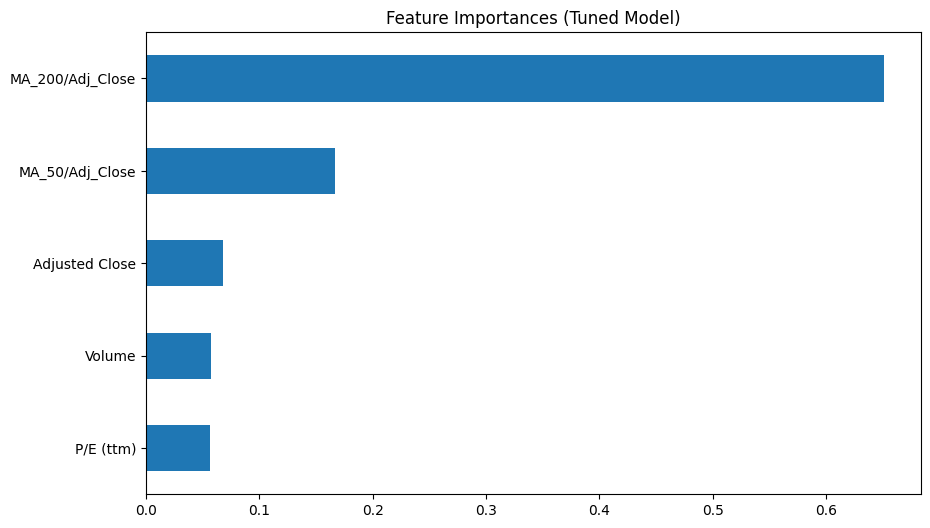

In [21]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

# Initial Cross-Validation
cv_scores = cross_val_score(model_rf_1, X_1, y_1, cv=5, scoring='r2')
print("Cross-validation scores:", cv_scores)
print("Mean CV score:", cv_scores.mean())
print("Standard deviation:", cv_scores.std())

# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform Grid Search
grid_search = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid,
    cv=5,
    n_jobs=-1,
    scoring='r2'
)

# Fit Grid Search
grid_search.fit(X_1, y_1)

# Print results
print("\nBest parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Train final model with best parameters
best_rf = RandomForestRegressor(**grid_search.best_params_, random_state=42)
best_rf.fit(X_1, y_1)

# Compare original vs tuned model
print("\nOriginal model R² score:", model_rf_1.score(X_1, y_1))
print("Tuned model R² score:", best_rf.score(X_1, y_1))

# Plot feature importances of best model
feature_imp = pd.Series(best_rf.feature_importances_, index=features)
plt.figure(figsize=(10, 6))
feature_imp.sort_values().plot(kind='barh')
plt.title('Feature Importances (Tuned Model)')
plt.show()

# Prophet

15:35:35 - cmdstanpy - INFO - Chain [1] start processing
15:35:36 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/47 [00:00<?, ?it/s]

15:35:36 - cmdstanpy - INFO - Chain [1] start processing
15:35:36 - cmdstanpy - INFO - Chain [1] done processing
15:35:36 - cmdstanpy - INFO - Chain [1] start processing
15:35:36 - cmdstanpy - INFO - Chain [1] done processing
15:35:36 - cmdstanpy - INFO - Chain [1] start processing
15:35:36 - cmdstanpy - INFO - Chain [1] done processing
15:35:36 - cmdstanpy - INFO - Chain [1] start processing
15:35:36 - cmdstanpy - INFO - Chain [1] done processing
15:35:36 - cmdstanpy - INFO - Chain [1] start processing
15:35:36 - cmdstanpy - INFO - Chain [1] done processing
15:35:36 - cmdstanpy - INFO - Chain [1] start processing
15:35:36 - cmdstanpy - INFO - Chain [1] done processing
15:35:37 - cmdstanpy - INFO - Chain [1] start processing
15:35:37 - cmdstanpy - INFO - Chain [1] done processing
15:35:37 - cmdstanpy - INFO - Chain [1] start processing
15:35:37 - cmdstanpy - INFO - Chain [1] done processing
15:35:37 - cmdstanpy - INFO - Chain [1] start processing
15:35:37 - cmdstanpy - INFO - Chain [1]

  horizon         mse       rmse       mae      mape     mdape     smape  \
0 37 days  166.546461  12.905288  8.127803  0.221241  0.154609  0.205541   
1 38 days  165.989398  12.883687  8.143034  0.225107  0.160148  0.208410   
2 39 days  165.553564  12.866762  8.168289  0.227899  0.160239  0.210383   
3 40 days  164.894595  12.841129  8.182487  0.229598  0.161521  0.211793   
4 41 days  166.181355  12.891135  8.225996  0.230891  0.161657  0.212832   

   coverage  
0  0.581993  
1  0.578006  
2  0.574911  
3  0.573666  
4  0.571655  


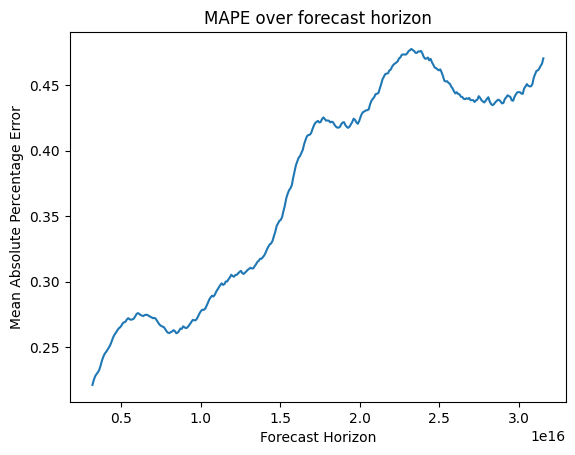

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/prophet/plot.py:546: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/prophet/plot.py:547: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])


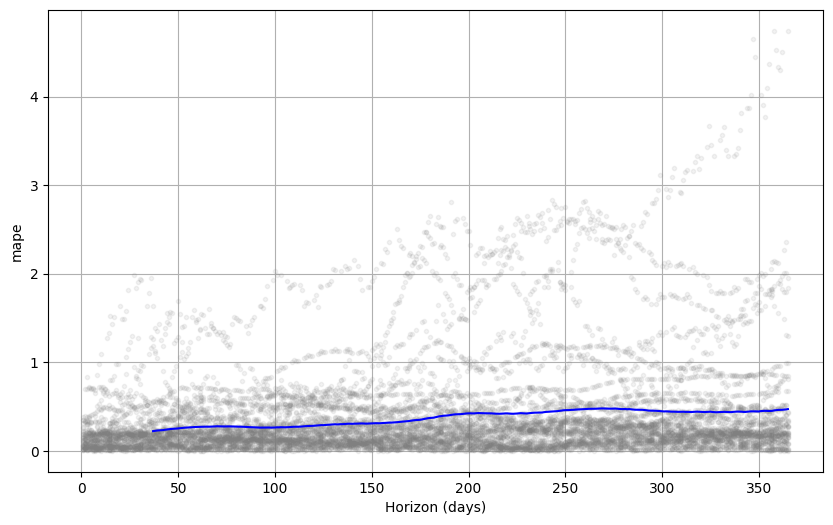

In [26]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from prophet.diagnostics import cross_validation, performance_metrics

# Read the data
df = pd.read_csv("../stocks_calc_final_with_ttm.csv")
df['Date'] = pd.to_datetime(df['Date'])

# Choose one stock (for example, the first stock)
sample_stock = df[df['Symbol'] == df['Symbol'].unique()[0]].copy()
sample_stock = sample_stock.sort_values('Date')

# Prepare data for Prophet
prophet_df = sample_stock[['Date', 'Adjusted Close']].rename(columns={'Date': 'ds', 'Adjusted Close': 'y'})

# Fit the model
model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False, changepoint_prior_scale=0.05)
model.fit(prophet_df)

# Backtesting using Prophet's cross_validation
# initial: period used for training before starting predictions
# period: frequency at which to make predictions
# horizon: forecast distance ahead to evaluate on
df_cv = cross_validation(model, initial='365 days', period='180 days', horizon='365 days')

# Compute performance metrics
df_p = performance_metrics(df_cv)
print(df_p.head())

# Plot performance metric (e.g., MAPE)
import seaborn as sns
sns.lineplot(data=df_p, x='horizon', y='mape')
plt.title('MAPE over forecast horizon')
plt.xlabel('Forecast Horizon')
plt.ylabel('Mean Absolute Percentage Error')
plt.show()

# Optional: Visualize cross-validation forecast vs actuals
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')
plt.show()

# ARIMA/LSTM

ADF Statistic: 0.73429350191134
p-value: 0.9904979857616755
Epoch 1/50


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0210 - val_loss: 0.0107
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 9.5085e-04 - val_loss: 0.0016
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0010 - val_loss: 0.0017
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 8.8201e-04 - val_loss: 0.0014
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 7.6637e-04 - val_loss: 0.0013
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 8.2382e-04 - val_loss: 9.6445e-04
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 7.2373e-04 - val_loss: 0.0018
Epoch 9/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 7.7558e-04 - val_loss: 9.1422e-04
Epoch 10/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 7.1779e-04 - val_loss: 0.0014
Epoch 11/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 5.9926e-04 - val_loss: 0.0015
Epoch 12/50
66/66 ━━━━━━━━━━━━━━━━

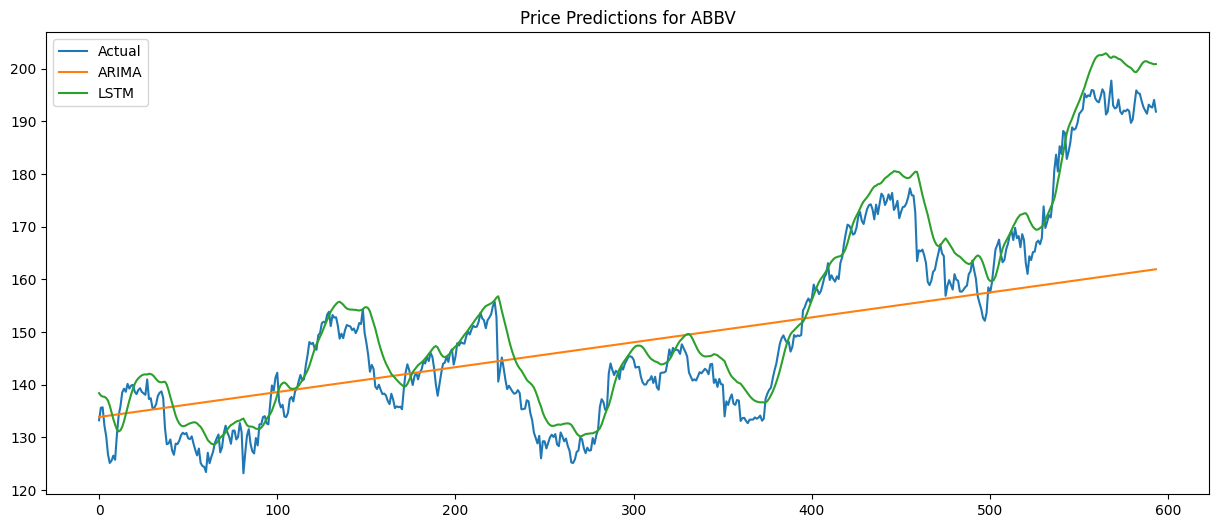


ARIMA Metrics:
MSE: 183.2290
RMSE: 13.5362
MAE: 10.4296
R2: 0.4875

LSTM Metrics:
MSE: 25.2802
RMSE: 5.0279
MAE: 4.0579
R2: 0.9293


In [6]:
# Import required libraries
import pandas as pd
import numpy as np
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

# Read and prepare data
df = pd.read_csv("../stocks_calc_final_with_ttm.csv")
df['Date'] = pd.to_datetime(df['Date'])

# Select one stock for example
stock_symbol = df['Symbol'].unique()[4]
sample_stock = df[df['Symbol'] == stock_symbol].sort_values('Date')
prices = sample_stock['Adjusted Close'].values

# Split data
train_size = int(len(prices) * 0.8)
train_data = prices[:train_size]
test_data = prices[train_size:]

# ARIMA Approach
def test_stationarity(timeseries):
    result = adfuller(timeseries)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])

# Test stationarity
test_stationarity(prices)

# Find optimal ARIMA parameters
arima_model = auto_arima(train_data, 
                        start_p=0, start_q=0,
                        max_p=5, max_q=5,
                        seasonal=False,
                        stepwise=True,
                        suppress_warnings=True)

# Fit ARIMA and make predictions
arima_predictions = arima_model.predict(n_periods=len(test_data))

# LSTM Approach
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:(i + seq_length)])
        targets.append(data[i + seq_length])
    return np.array(sequences), np.array(targets)

# Scale data
scaler = MinMaxScaler()
scaled_prices = scaler.fit_transform(prices.reshape(-1, 1))

# Create sequences
seq_length = 60
X, y = create_sequences(scaled_prices, seq_length)

# Split sequences
X_train = X[:train_size-seq_length]
X_test = X[train_size-seq_length:]
y_train = y[:train_size-seq_length]
y_test = y[train_size-seq_length:]

# Build LSTM model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(seq_length, 1), return_sequences=True),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# Train LSTM
history = model.fit(X_train, y_train, 
                   epochs=50, 
                   batch_size=32,
                   validation_split=0.1,
                   verbose=1)

# Make predictions
lstm_predictions = model.predict(X_test)

# Compare Results
plt.figure(figsize=(15, 6))
plt.plot(test_data, label='Actual')
plt.plot(arima_predictions, label='ARIMA')
plt.plot(scaler.inverse_transform(lstm_predictions), label='LSTM')
plt.title(f'Price Predictions for {stock_symbol}')
plt.legend()
plt.show()

# Calculate metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def print_metrics(y_true, y_pred, model_name):
    print(f"\n{model_name} Metrics:")
    print(f"MSE: {mean_squared_error(y_true, y_pred):.4f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.4f}")
    print(f"MAE: {mean_absolute_error(y_true, y_pred):.4f}")
    print(f"R2: {r2_score(y_true, y_pred):.4f}")

print_metrics(test_data, arima_predictions, "ARIMA")
print_metrics(test_data, scaler.inverse_transform(lstm_predictions).flatten(), "LSTM")

ADF Statistic: -14.459353824628577
p-value: 6.88829126470996e-27

ARIMA (Differenced) Metrics:
MSE: 3082.2812
RMSE: 55.5183
MAE: 50.2210
R2: -4.3110


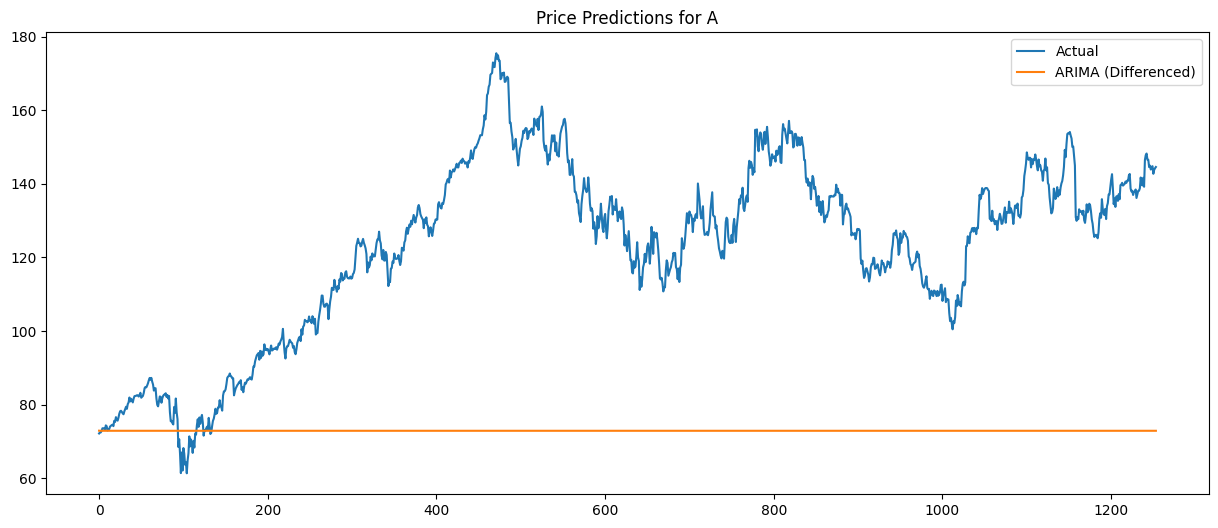

Epoch 1/50


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.0041 - val_loss: 0.0013
Epoch 2/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 5.0146e-04 - val_loss: 0.0011
Epoch 3/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 4.0433e-04 - val_loss: 5.1235e-04
Epoch 4/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 3.9758e-04 - val_loss: 2.4005e-04
Epoch 5/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 3.2803e-04 - val_loss: 2.2401e-04
Epoch 6/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 2.4389e-04 - val_loss: 1.5898e-04
Epoch 7/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 3.0238e-04 - val_loss: 9.8864e-04
Epoch 8/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 3.1873e-04 - val_loss: 3.7371e-04
Epoch 9/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 3.0530e-04 - val_loss: 1.9919e-04
Epoch 10/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 2.5259e-04 - val_loss: 3.9741e-04
Epoch 11/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 2.1544e-04

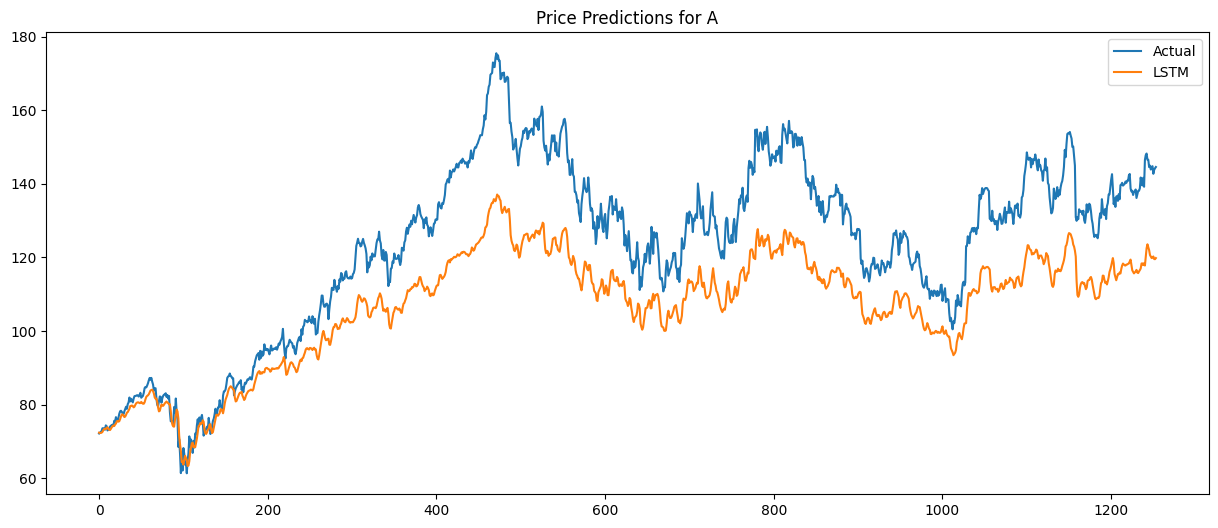

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Read and prepare data
df = pd.read_csv("../stocks_calc_final_with_ttm.csv")
df['Date'] = pd.to_datetime(df['Date'])

# Select one stock for example
stock_symbol = df['Symbol'].unique()[0]
sample_stock = df[df['Symbol'] == stock_symbol].sort_values('Date')
prices = sample_stock['Adjusted Close'].values

# Split data
train_size = int(len(prices) * 0.8)
train_data = prices[:train_size]
test_data = prices[train_size:]

# Scale data
scaler = MinMaxScaler()
scaled_prices = scaler.fit_transform(prices.reshape(-1, 1))

# Create sequences
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:(i + seq_length)])
        targets.append(data[i + seq_length])
    return np.array(sequences), np.array(targets)

seq_length = 60
X, y = create_sequences(scaled_prices, seq_length)

# Split sequences
X_train = X[:train_size-seq_length]
X_test = X[train_size-seq_length:]
y_train = y[:train_size-seq_length]
y_test = y[train_size-seq_length:]

# Differencing to make series stationary
diff_prices = np.diff(prices, n=1)

# Ensure consistent lengths
train_data_diff = diff_prices[:train_size-1]
test_data_diff = diff_prices[train_size-1:]

# Test stationarity
def test_stationarity(timeseries):
    result = adfuller(timeseries)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])

test_stationarity(train_data_diff)

# Find optimal ARIMA parameters
arima_model_diff = auto_arima(train_data_diff, 
                              start_p=0, start_q=0,
                              max_p=5, max_q=5,
                              seasonal=False,
                              stepwise=True,
                              suppress_warnings=True)

# Fit ARIMA and make predictions
arima_predictions_diff = arima_model_diff.predict(n_periods=len(test_data_diff))

# Reverse differencing
arima_predictions_diff = np.r_[prices[train_size-1], arima_predictions_diff].cumsum()

# Ensure consistent lengths for evaluation
arima_predictions_diff = arima_predictions_diff[:len(test_data)]

# Evaluate performance
def print_metrics(y_true, y_pred, model_name):
    print(f"\n{model_name} Metrics:")
    print(f"MSE: {mean_squared_error(y_true, y_pred):.4f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.4f}")
    print(f"MAE: {mean_absolute_error(y_true, y_pred):.4f}")
    print(f"R2: {r2_score(y_true, y_pred):.4f}")

print_metrics(test_data, arima_predictions_diff, "ARIMA (Differenced)")

# Plot results
plt.figure(figsize=(15, 6))
plt.plot(test_data, label='Actual')
plt.plot(arima_predictions_diff, label='ARIMA (Differenced)')
plt.title(f'Price Predictions for {stock_symbol}')
plt.legend()
plt.show()

# Build LSTM model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(seq_length, 1), return_sequences=True),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# Train LSTM
history = model.fit(X_train, y_train, 
                   epochs=50, 
                   batch_size=32,
                   validation_split=0.1,
                   verbose=1)

# Make predictions
lstm_predictions = model.predict(X_test)

# Evaluate performance
print_metrics(test_data, scaler.inverse_transform(lstm_predictions).flatten(), "LSTM")

# Plot results
plt.figure(figsize=(15, 6))
plt.plot(test_data, label='Actual')
plt.plot(scaler.inverse_transform(lstm_predictions), label='LSTM')
plt.title(f'Price Predictions for {stock_symbol}')
plt.legend()
plt.show()

# LSTM on multiple symbols

Processing symbol: AAPL


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.02s - Debugger warning: It seems that frozen modules are being used, which may
0

KeyboardInterrupt: 

# LTSM w/ Fundamental Indicators

Processing symbol: AAPL
Epoch 1/50


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0027 - val_loss: 0.0057
Epoch 2/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 3.9410e-04 - val_loss: 0.0029
Epoch 3/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 3.0994e-04 - val_loss: 0.0015
Epoch 4/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 2.6748e-04 - val_loss: 0.0022
Epoch 5/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 2.4882e-04 - val_loss: 7.5636e-04
Epoch 6/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 2.0324e-04 - val_loss: 0.0011
Epoch 7/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 2.1057e-04 - val_loss: 0.0013
Epoch 8/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 2.1424e-04 - val_loss: 8.5093e-04
Epoch 9/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 1.7834e-04 - val_loss: 0.0012
Epoch 10/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 1.8784e-04 - val_loss: 0.0019
Epoch 11/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.8868e-04 - val_loss: 7.9183e-04
Epoch 12/50
83/83 ━━━━

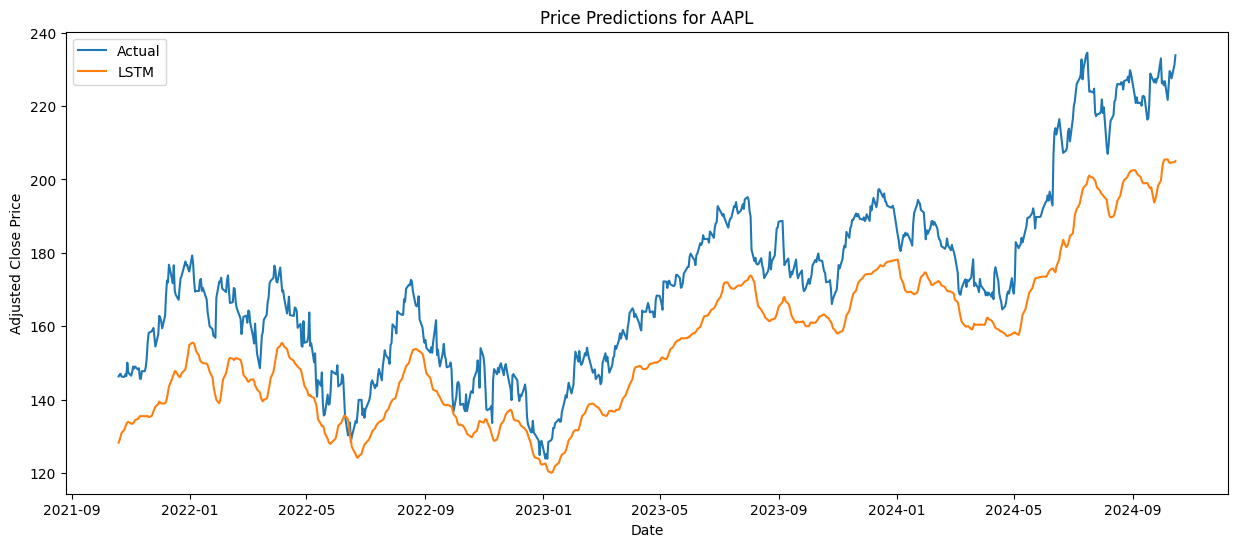

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Read and prepare data
df = pd.read_csv("../stocks_with_moving_averages_and_price_change.csv")
df['Date'] = pd.to_datetime(df['Date'])

# Select one stock symbol
symbol = df['Symbol'].unique()[2]
print(f"Processing symbol: {symbol}")

# Select data for the symbol
sample_stock = df[df['Symbol'] == symbol].sort_values('Date')
features = sample_stock[['Adjusted Close', 'Volume', 'P/E (ttm)', 'MA_50', 'MA_200']].values

# Split data
train_size = int(len(features) * 0.8)
train_data = features[:train_size]
test_data = features[train_size:]

# Scale data
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)

# Create sequences
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:(i + seq_length)])
        targets.append(data[i + seq_length, 0])  # Predicting the Adjusted Close price
    return np.array(sequences), np.array(targets)

seq_length = 60
X, y = create_sequences(scaled_features, seq_length)

# Split sequences
X_train = X[:train_size-seq_length]
X_test = X[train_size-seq_length:]
y_train = y[:train_size-seq_length]
y_test = y[train_size-seq_length:]

# Build LSTM model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(seq_length, X.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# Train LSTM
history = model.fit(X_train, y_train, 
                   epochs=50, 
                   batch_size=32,
                   validation_split=0.1,
                   verbose=1)

# Make predictions
lstm_predictions = model.predict(X_test)

# Inverse transform predictions
lstm_predictions = scaler.inverse_transform(np.concatenate((lstm_predictions, np.zeros((lstm_predictions.shape[0], scaled_features.shape[1] - 1))), axis=1))[:, 0]

# Evaluate performance
mse = mean_squared_error(test_data[:, 0], lstm_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data[:, 0], lstm_predictions)
r2 = r2_score(test_data[:, 0], lstm_predictions)

# Print metrics
def print_metrics(y_true, y_pred, model_name):
    print(f"\n{model_name} Metrics:")
    print(f"MSE: {mean_squared_error(y_true, y_pred):.4f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.4f}")
    print(f"MAE: {mean_absolute_error(y_true, y_pred):.4f}")
    print(f"R2: {r2_score(y_true, y_pred):.4f}")

print_metrics(test_data[:, 0], lstm_predictions, f"LSTM for {symbol}")

# Plot results
plt.figure(figsize=(15, 6))
plt.plot(sample_stock['Date'][train_size:], test_data[:, 0], label='Actual')
plt.plot(sample_stock['Date'][train_size:], lstm_predictions, label='LSTM')
plt.title(f'Price Predictions for {symbol}')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()

# Prediction with LSTM


Backtesting Results:
Total Return: 22.58%
Sharpe Ratio: 0.39
Max Drawdown: -27.39%


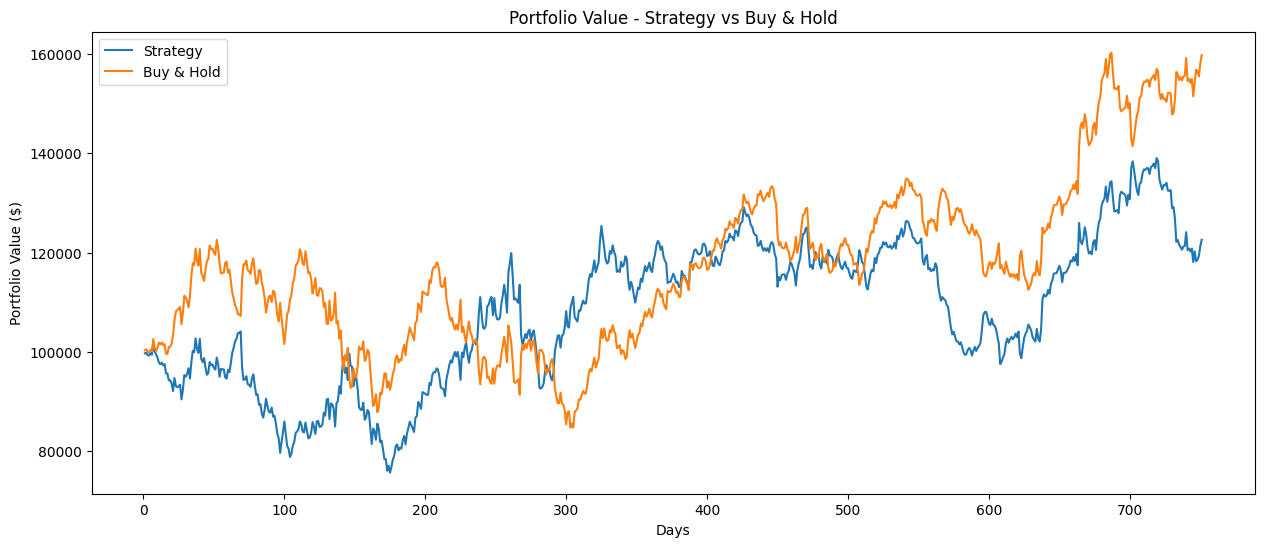

In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

# Assuming we have our trained LSTM model and predictions from before
# ... existing LSTM code ...

def backtest_strategy(actual_prices, predicted_prices, initial_capital=100000):
    df = pd.DataFrame({
        'Actual': actual_prices,
        'Predicted': predicted_prices
    })
    
    # Calculate predicted returns
    df['Predicted_Return'] = df['Predicted'].pct_change()
    
    # Generate trading signals
    df['Position'] = np.where(df['Predicted_Return'] > 0, 1, -1)
    
    # Calculate strategy returns
    df['Actual_Return'] = df['Actual'].pct_change()
    df['Strategy_Return'] = df['Position'].shift(1) * df['Actual_Return']
    
    # Calculate portfolio value
    df['Portfolio_Value'] = initial_capital * (1 + df['Strategy_Return']).cumprod()
    
    # Calculate buy & hold returns
    df['Buy_Hold_Value'] = initial_capital * (1 + df['Actual_Return']).cumprod()
    
    # Calculate metrics
    total_return = (df['Portfolio_Value'].iloc[-1] - initial_capital) / initial_capital
    sharpe_ratio = np.sqrt(252) * (df['Strategy_Return'].mean() / df['Strategy_Return'].std())
    max_drawdown = (df['Portfolio_Value'] / df['Portfolio_Value'].cummax() - 1).min()
    
    print(f"\nBacktesting Results:")
    print(f"Total Return: {total_return*100:.2f}%")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"Max Drawdown: {max_drawdown*100:.2f}%")
    
    # Plot results
    plt.figure(figsize=(15, 6))
    plt.plot(df['Portfolio_Value'], label='Strategy')
    plt.plot(df['Buy_Hold_Value'], label='Buy & Hold')
    plt.title('Portfolio Value - Strategy vs Buy & Hold')
    plt.xlabel('Days')
    plt.ylabel('Portfolio Value ($)')
    plt.legend()
    plt.show()
    
    return df

# Run backtest
backtest_results = backtest_strategy(test_data[:, 0], lstm_predictions)

# Hyperparameter Tuning

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Read and prepare data
df = pd.read_csv("../stocks_calc_final_with_ttm.csv")
df['Date'] = pd.to_datetime(df['Date'])

# Select one stock symbol
symbol = df['Symbol'].unique()[0]
print(f"Processing symbol: {symbol}")

# Select data for the symbol
sample_stock = df[df['Symbol'] == symbol].sort_values('Date')
features = sample_stock[['Adjusted Close', 'Volume', 'P/E (ttm)', 'MA_50', 'MA_200']].values

# Split data
train_size = int(len(features) * 0.8)
train_data = features[:train_size]
test_data = features[train_size:]

# Scale data
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)

# Create sequences
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:(i + seq_length)])
        targets.append(data[i + seq_length, 0])  # Predicting the Adjusted Close price
    return np.array(sequences), np.array(targets)

seq_length = 60
X, y = create_sequences(scaled_features, seq_length)

# Split sequences
X_train = X[:train_size-seq_length]
X_test = X[train_size-seq_length:]
y_train = y[:train_size-seq_length]
y_test = y[train_size-seq_length:]

# Build LSTM model
model = Sequential([
    LSTM(100, activation='relu', input_shape=(seq_length, X.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(100, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# Train LSTM
history = model.fit(X_train, y_train, 
                   epochs=100, 
                   batch_size=32,
                   validation_split=0.1,
                   verbose=1)

# Make predictions
lstm_predictions = model.predict(X_test)

# Inverse transform predictions
lstm_predictions = scaler.inverse_transform(np.concatenate((lstm_predictions, np.zeros((lstm_predictions.shape[0], scaled_features.shape[1] - 1))), axis=1))[:, 0]

# Evaluate performance
mse = mean_squared_error(test_data[:, 0], lstm_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data[:, 0], lstm_predictions)
r2 = r2_score(test_data[:, 0], lstm_predictions)

# Print metrics
def print_metrics(y_true, y_pred, model_name):
    print(f"\n{model_name} Metrics:")
    print(f"MSE: {mean_squared_error(y_true, y_pred):.4f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.4f}")
    print(f"MAE: {mean_absolute_error(y_true, y_pred):.4f}")
    print(f"R2: {r2_score(y_true, y_pred):.4f}")

print_metrics(test_data[:, 0], lstm_predictions, f"LSTM for {symbol}")

# Plot results
plt.figure(figsize=(15, 6))
plt.plot(sample_stock['Date'][train_size:], test_data[:, 0], label='Actual')
plt.plot(sample_stock['Date'][train_size:], lstm_predictions, label='LSTM')
plt.title(f'Price Predictions for {symbol}')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()

# ranking stocks

In [ ]:
# -*- coding: utf-8 -*-
"""
LightGBM rank‑learning pipeline (clean, deciled, liquidity‑filtered)
===================================================================
Changes vs. previous version
---------------------------
1. **Liquidity screen** – keep only rows where Adjusted Close > $5 and daily
   volume > 1 million shares.
2. **Label clipping** – future 12‑month excess return capped to [‑200 %, +200 %]
   to kill insane outliers.
3. **Decile relevance labels** – inside each snapshot the future excess return is
   mapped to 0‑9 (worst→best).  `label_gain=list(range(10))` is set so
   LightGBM’s LambdaRank objective is happy.
4. Walk‑forward loop unchanged in principle but now calls `decile_ranks()`.

Run this file or drop the code into a notebook cell to get saner back‑test
statistics.
"""

import pandas as pd, numpy as np, joblib
from lightgbm import LGBMRanker
from pathlib import Path

# ------------------------------------------------------------------
# CONFIG
# ------------------------------------------------------------------
DATA_DIR  = Path("data")
OUT_DIR   = Path("models"); OUT_DIR.mkdir(exist_ok=True)
PRICE_CSV = DATA_DIR / "stocks_with_1yr_price_change.csv"
SPY_CSV   = DATA_DIR / "spy.csv"

MIN_TRAIN_YEARS = 5
TOP_PCT         = 0.10

# ------------------------------------------------------------------
# 1. LOAD DAILY PRICES & BENCHMARK
# ------------------------------------------------------------------
prices = (pd.read_csv(PRICE_CSV, parse_dates=["Date"]).sort_values(["Symbol", "Date"]))
spy    = (pd.read_csv(SPY_CSV,   parse_dates=["Date"]).set_index("Date")["Close"].sort_index())

# ------------------------------------------------------------------
# 2. FORWARD RETURN THEN SNAPSHOT
# ------------------------------------------------------------------
prices["NextAdjClose"] = prices.groupby("Symbol")["Adjusted Close"].shift(-252)
prices["FwdRet"]       = prices["NextAdjClose"] / prices["Adjusted Close"] - 1

prices["Year"] = prices["Date"].dt.year
snap = (prices.groupby(["Symbol", "Year"]).tail(1)
              .reset_index(drop=True)
              .rename(columns={"Adjusted Close": "AdjClose"}))

# ------------------------------------------------------------------
# 3. LIQUIDITY FILTER  (> $5 price & > 1M volume)
# ------------------------------------------------------------------
liq_mask = (snap["AdjClose"] > 5) & (snap["Volume"] > 1_000_000)
snap = snap[liq_mask].copy()

# ------------------------------------------------------------------
# 4. FEATURE ENGINEERING
# ------------------------------------------------------------------
# avoid /0
snap.loc[snap["P/E (ttm)"] <= 0, "P/E (ttm)"] = np.nan

snap["Val_PE_inv"] = 1 / snap["P/E (ttm)"]
snap["Mom_12m"]    = prices.groupby("Symbol")["Adjusted Close"].pct_change(252).reindex(snap.index)
snap["Mom_trend"]  = snap["MA_200/Adj_Close"]
vol_1y = (prices.groupby("Symbol")["Adjusted Close"].pct_change().rolling(252).std())
snap["LowVol_1y"]  = vol_1y.reindex(snap.index)
snap["Size_logVol"] = np.log1p(snap["Volume"])

feature_cols = ["Val_PE_inv", "Mom_12m", "Mom_trend", "LowVol_1y", "Size_logVol"]

for c in feature_cols:
    lo, hi = snap[c].quantile([0.01, 0.99])
    snap[c] = snap[c].clip(lo, hi)

# ------------------------------------------------------------------
# 5. EXCESS RETURN LABEL  (clipped)
# ------------------------------------------------------------------
spy_12m = spy.pct_change(252)
snap["SPY_12m"]   = spy_12m.reindex(snap["Date"]).values
snap["ExRet_12m"] = snap["FwdRet"] - snap["SPY_12m"]
# clip ±200 %
snap["ExRet_12m"] = snap["ExRet_12m"].clip(-2.0, 2.0)

snap = snap.dropna(subset=["ExRet_12m"])  # ensure no NaNs in label

# ------------------------------------------------------------------
# helper: decile ranks (0‑9) inside each snapshot date
# ------------------------------------------------------------------

def decile_ranks(df: pd.DataFrame, label_col="ExRet_12m") -> pd.Series:
    pct = df.groupby("Date")[label_col].rank(pct=True, method="first")  # 0‑1
    return (pct * 9).astype(int)  # 0‑9 inclusive

# ------------------------------------------------------------------
# 6. WALK‑FORWARD TRAIN < Y → SCORE Y
# ------------------------------------------------------------------
ranker_base = dict(objective="lambdarank", num_leaves=63, learning_rate=0.05,
                   n_estimators=600, subsample=0.8, colsample_bytree=0.8,
                   random_state=42, label_gain=list(range(10)))  # 0‑9

snap["Score"] = np.nan
years = sorted(snap["Year"].unique())

for yr in years:
    if yr <= years[MIN_TRAIN_YEARS]:
        continue

    train_mask = snap["Year"] < yr
    test_mask  = snap["Year"] == yr

    y_train = decile_ranks(snap.loc[train_mask])
    X_train = snap.loc[train_mask, feature_cols]
    X_test  = snap.loc[test_mask,  feature_cols]

    group_train = snap.loc[train_mask].groupby("Date").size().values

    model = LGBMRanker(**ranker_base)
    model.fit(X_train, y_train, group=group_train)

    snap.loc[test_mask, "Score"] = model.predict(X_test)
    print(f"{yr}: trained {train_mask.sum():>5} | scored {test_mask.sum():>4}")

# ------------------------------------------------------------------
# 7. PERFORMANCE SUMMARY
# ------------------------------------------------------------------
summary = []
for yr in years[MIN_TRAIN_YEARS+1:]:
    yr_mask = snap["Year"] == yr
    block   = snap.loc[yr_mask & snap["Score"].notna()].copy()
    if block.empty:
        continue
    k = max(int(len(block)*TOP_PCT), 1)
    top = block.nlargest(k, "Score")
    all_ret = block["ExRet_12m"].mean()*100
    top_ret = top["ExRet_12m"].mean()*100
    summary.append({"Year": yr, "All_Stocks_Return": all_ret,
                    "Top_Picks_Return": top_ret,
                    "Outperformance": top_ret - all_ret})

perf = pd.DataFrame(summary)
print("\nYearly Performance (Excess %):")
print(perf)
perf.to_csv(OUT_DIR / "yearly_performance_decile.csv", index=False)

# ------------------------------------------------------------------
# 8. LATEST PICKS
# ------------------------------------------------------------------
latest_year = snap["Year"].max()
latest      = snap[(snap["Year"] == latest_year) & snap["Score"].notna()].copy()
latest_top  = latest.nlargest(max(int(len(latest)*TOP_PCT),1), "Score")
print("\nTop picks for", latest_year)
print(latest_top[["Symbol", "Score"]].reset_index(drop=True))

# save snapshot with scores for external back‑test/analysis
snap.to_csv(OUT_DIR / "snapshots_with_scores_decile.csv", index=False)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000176 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 933, number of used features: 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

# OLD rank

In [ ]:
import pandas as pd, numpy as np, joblib
from lightgbm import LGBMRanker
from pathlib import Path

# ------------------------------------------------------------------
# CONFIG
# ------------------------------------------------------------------
DATA_DIR  = Path("data")
OUT_DIR   = Path("models"); OUT_DIR.mkdir(exist_ok=True)
PRICE_CSV = DATA_DIR / "stocks_with_1yr_price_change.csv"  # daily
SPY_CSV   = DATA_DIR / "spy.csv"                           # daily SPY

MIN_TRAIN_YEARS = 5      # first 5 years warm‑up
TOP_PCT         = 0.10   # buy top‑decile

# ------------------------------------------------------------------
# 1. LOAD DAILY PRICES & BENCHMARK
# ------------------------------------------------------------------
prices = (pd.read_csv(PRICE_CSV, parse_dates=["Date"])   # Date, Symbol, Adjusted Close, Volume, P/E (ttm), ...
            .sort_values(["Symbol", "Date"]))
spy = (pd.read_csv(SPY_CSV, parse_dates=["Date"])        # Date, Close
         .sort_values("Date").set_index("Date")["Close"])

# ------------------------------------------------------------------
# 2. PRE‑COMPUTE 1‑YEAR‑AHEAD PRICE  **BEFORE** SAMPLING SNAPSHOT
# ------------------------------------------------------------------
prices["NextAdjClose"] = prices.groupby("Symbol")["Adjusted Close"].shift(-252)
prices["FwdRet"]       = prices["NextAdjClose"] / prices["Adjusted Close"] - 1

# snapshot = last trading day of each calendar year (now carries NextAdjClose & FwdRet)
prices["Year"] = prices["Date"].dt.year
snap = (prices.groupby(["Symbol", "Year"]).tail(1)
              .reset_index(drop=True)
              .rename(columns={"Adjusted Close": "AdjClose"}))

# ------------------------------------------------------------------
# 3. CLEAN FUNDAMENTALS & BASIC FEATURES
# ------------------------------------------------------------------
# avoid /0: set non‑positive P‑E to NaN so inverse becomes NaN (later imputed by model)
snap.loc[snap["P/E (ttm)"] <= 0, "P/E (ttm)"] = np.nan

snap["Val_PE_inv"] = 1 / snap["P/E (ttm)"]
# 12‑m momentum (price change) – need same‑symbol series
a12m = prices.groupby("Symbol")["Adjusted Close"].pct_change(252)
snap["Mom_12m"] = a12m.reindex(snap.index)

snap["Mom_trend"] = snap["MA_200/Adj_Close"]  # already >1 if in LT up‑trend

vol_1y = (prices.groupby("Symbol")["Adjusted Close"]
                  .pct_change()
                  .rolling(252)
                  .std())
snap["LowVol_1y"] = vol_1y.reindex(snap.index)

snap["Size_logVol"] = np.log1p(snap["Volume"])

feature_cols = ["Val_PE_inv", "Mom_12m", "Mom_trend", "LowVol_1y", "Size_logVol"]

# winsorise 1 % tails *per factor*
for c in feature_cols:
    lo, hi   = snap[c].quantile([0.01, 0.99])
    snap[c]  = snap[c].clip(lo, hi)

# ------------------------------------------------------------------
# 4. EXCESS‑RETURN LABEL
# ------------------------------------------------------------------
# SPY forward 12‑m return (align on same calendar date)
snap["SPY_12m"] = spy.reindex(snap["Date"]).pct_change(252).values
snap["ExRet_12m"] = snap["FwdRet"] - snap["SPY_12m"]
# drop rows without future price (e.g., delisted < 1 y after snapshot)
snap = snap.dropna(subset=["ExRet_12m"])

# ------------------------------------------------------------------
# helper: create 0-indexed ranks for every snapshot
# ------------------------------------------------------------------
def int_ranks(df: pd.DataFrame, return_col="ExRet_12m") -> pd.Series:
    """
    Turn future excess returns into integer ranks 0 .. (n-1) inside each snapshot.
    """
    return (
        df.groupby("Date")[return_col]
          .rank(method="first", ascending=True)   # 1 .. n
          .sub(1)                                 # 0 .. n-1
          .astype(int)
    )

# ------------------------------------------------------------------
# 5. WALK-FORWARD loop  (train on < Y, score Y)  **with safe label_gain**
# ------------------------------------------------------------------
snap["Score"] = np.nan
years = sorted(snap["Year"].unique())

base_params = dict(
    objective="lambdarank",
    num_leaves=63, learning_rate=0.05,
    n_estimators=600, subsample=0.8,
    colsample_bytree=0.8, random_state=42
)

for yr in years:
    if yr <= years[MIN_TRAIN_YEARS]:
        continue          # skip warm-up years

    train_mask = snap["Year"] < yr
    test_mask  = snap["Year"] == yr

    # ----------- build integer labels for THIS train slice -----------
    y_train = int_ranks(snap.loc[train_mask])

    X_train = snap.loc[train_mask, feature_cols]
    X_test  = snap.loc[test_mask,  feature_cols]

    # group array = #stocks per snapshot date in the train slice
    g_train = snap.loc[train_mask].groupby("Date").size().values

    # make label_gain long enough for the largest rank in this slice
    max_rank = int(y_train.max())
    params   = {
        **base_params,
        "label_gain": list(range(max_rank + 1))   # e.g. [0, 1, …, max_rank]
    }

    model = LGBMRanker(**params)
    model.fit(X_train, y_train, group=g_train)

    snap.loc[test_mask, "Score"] = model.predict(X_test)
    print(f"{yr}: trained on {train_mask.sum():>5} rows | scored {test_mask.sum():>4} rows "
          f"| max rank {max_rank}")


# ------------------------------------------------------------------
# 6. EVALUATE – TOP‑DECILE VS. UNIVERSE  (out‑of‑sample only)
# ------------------------------------------------------------------
summary = []
for yr in years[MIN_TRAIN_YEARS+1:]:
    yr_mask = snap["Year"] == yr
    scored  = snap.loc[yr_mask & snap["Score"].notna()]
    if scored.empty:
        continue

    n = len(scored)
    k = max(int(n * TOP_PCT), 1)
    top = scored.nlargest(k, "Score")

    all_ret = scored["ExRet_12m"].mean()
    top_ret = top["ExRet_12m"].mean()

    summary.append({"Year": yr,
                    "All_Stocks_Return": all_ret*100,
                    "Top_Picks_Return": top_ret*100,
                    "Outperformance": (top_ret - all_ret)*100})

perf = pd.DataFrame(summary)
print("\nYearly Performance (Excess %):")
print(perf)
perf.to_csv(OUT_DIR / "yearly_performance_clean.csv", index=False)

# ------------------------------------------------------------------
# 7.  CURRENT PICKS  (latest year)
# ------------------------------------------------------------------
latest_year = snap["Year"].max()
latest      = snap[(snap["Year"] == latest_year) & snap["Score"].notna()].copy()
latest_top  = latest.nlargest(max(int(len(latest)*TOP_PCT), 1), "Score")
print("\nTop picks for", latest_year)
print(latest_top[["Symbol", "Score"]].reset_index(drop=True))

# Save full snapshot table for any further back‑tests
snap.to_csv(OUT_DIR / "snapshots_with_scores_fixed.csv", index=False)

# basic ranking

Adjusting END_YEAR from 2024 to 2022 based on data availability.

===== Annual Returns & Alpha =====
     Portfolio      SPY   Alpha
Year                           
2005    35.69%    5.32%  30.37%
2006    23.55%   13.84%   9.71%
2007    15.94%    5.33%  10.60%
2008   -45.32%  -36.24%  -9.08%
2009    16.70%   22.65%  -5.95%
2010    28.78%   13.14%  15.64%
2011    -5.80%    0.85%  -6.65%
2012    25.36%   14.17%  11.19%
2013    41.26%   29.00%  12.26%
2014    33.46%   14.56%  18.90%
2015     5.53%    1.29%   4.24%
2016    10.16%   13.59%  -3.42%
2017    23.25%   20.78%   2.47%
2018     4.24%   -5.25%   9.48%
2019    38.55%   31.09%   7.46%
2020    50.12%   17.24%  32.89%
2021    56.80%   30.51%  26.29%
2022    -3.94%  -18.65%  14.71%

Year-by-year outperformance:
• 2005: portfolio 35.69%, SPY 5.32% ⇒ alpha 30.37%
• 2006: portfolio 23.55%, SPY 13.84% ⇒ alpha 9.71%
• 2007: portfolio 15.94%, SPY 5.33% ⇒ alpha 10.60%
• 2008: portfolio -45.32%, SPY -36.24% ⇒ alpha -9.08%
• 2009: portfolio 16.7

/var/folders/wm/fydrjt2543sch7051n5t7ygc0000gs/T/ipykernel_94303/3725977961.py:101: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_fmt = df_res.applymap(lambda x: f"{x:.2%}")


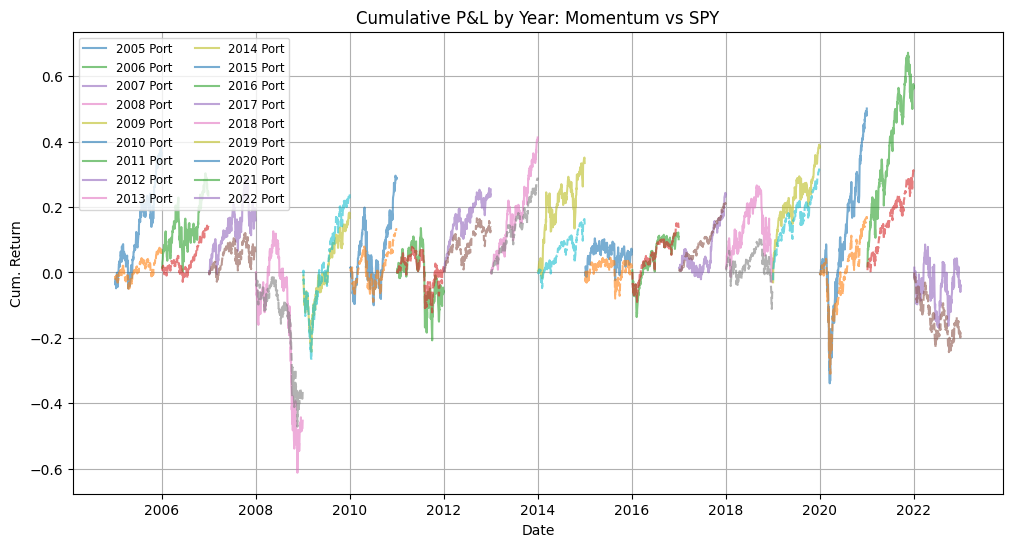

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# ========== USER PARAMETERS ==========
DATA_DIR     = Path("data")
STOCKS_CSV   = DATA_DIR / "stocks_with_1yr_price_change.csv"
SPY_CSV      = DATA_DIR / "spy.csv"

START_YEAR   = 2005     # first test year
END_YEAR     = 2024     # upper bound; will be clamped to your data
TOP_QUANTILE = 0.10
# ======================================

def load_data():
    stocks = pd.read_csv(STOCKS_CSV, parse_dates=['Date'])
    stocks.sort_values(['Symbol','Date'], inplace=True)
    spy = pd.read_csv(SPY_CSV, parse_dates=['Date'])
    spy.sort_values('Date', inplace=True)
    return stocks, spy

def get_factor_on_date(stocks, cutoff_date):
    cutoff = pd.to_datetime(cutoff_date)
    df = stocks[stocks['Date'] <= cutoff]
    last = (
        df
        .sort_values('Date')
        .groupby('Symbol', as_index=False)
        .last()[['Symbol','Price_Change_1Y']]
        .dropna(subset=['Price_Change_1Y'])
    )
    return last.set_index('Symbol')['Price_Change_1Y']

def top_decile_symbols(factor_series):
    n = len(factor_series)
    top_n = max(1, int(np.floor(TOP_QUANTILE * n)))
    return factor_series.nlargest(top_n).index.tolist()

def daily_portfolio_returns(price_wide, symbols):
    rets = price_wide[symbols].pct_change(fill_method=None).dropna(how='all')
    return rets.mean(axis=1)

def backtest_year(stocks, spy, year):
    train_end  = f"{year-1}-12-31"
    test_start = f"{year}-01-01"
    test_end   = f"{year}-12-31"

    factor = get_factor_on_date(stocks, train_end)
    if factor.empty:
        raise ValueError(f"No factor data before {train_end}")

    winners = top_decile_symbols(factor)

    price_mat = stocks.pivot(index='Date', columns='Symbol', values='Adjusted Close')
    price_test = price_mat.loc[test_start:test_end, winners]
    if price_test.empty:
        raise ValueError(f"No price data in {year}")

    port_rets = daily_portfolio_returns(price_test, winners)
    port_cum  = (1 + port_rets).cumprod() - 1

    spy_close = spy.set_index('Date')['Close'].loc[test_start:test_end]
    spy_rets  = spy_close.pct_change().dropna()
    spy_cum   = (1 + spy_rets).cumprod() - 1

    df = pd.DataFrame({'Portfolio': port_cum, 'SPY': spy_cum}).dropna()
    if df.empty:
        raise ValueError(f"No overlapping dates for portfolio vs SPY in {year}")

    port_final = df['Portfolio'].iloc[-1]
    spy_final  = df['SPY'].iloc[-1]
    alpha      = port_final - spy_final

    return year, port_final, spy_final, alpha, df

def run_multiple_years():
    stocks, spy = load_data()

    # clamp END_YEAR so we never overshoot our data
    last_stock_year = stocks['Date'].max().year
    last_spy_year   = spy['Date'].max().year
    max_year = min(last_stock_year, last_spy_year)
    if END_YEAR > max_year:
        print(f"Adjusting END_YEAR from {END_YEAR} to {max_year} based on data availability.")
    end_year = min(END_YEAR, max_year)

    results = []
    curves  = {}

    for year in range(START_YEAR, end_year+1):
        try:
            y, port_ret, spy_ret, alpha, curve = backtest_year(stocks, spy, year)
            results.append((y, port_ret, spy_ret, alpha))
            curves[year] = curve
        except ValueError as e:
            # now only skips truly missing years
            print(f"Skipping {year}: {e}")

    df_res = pd.DataFrame(results, columns=['Year','Portfolio','SPY','Alpha']).set_index('Year')
    df_fmt = df_res.applymap(lambda x: f"{x:.2%}")

    print("\n===== Annual Returns & Alpha =====")
    print(df_fmt)

    print("\nYear-by-year outperformance:")
    for year, row in df_res.iterrows():
        print(f"• {year}: portfolio {row['Portfolio']:.2%}, SPY {row['SPY']:.2%} ⇒ alpha {row['Alpha']:.2%}")

    plt.figure(figsize=(12,6))
    for year, curve in curves.items():
        plt.plot(curve.index, curve['Portfolio'], label=f'{year} Port', alpha=0.6)
        plt.plot(curve.index, curve['SPY'],    linestyle='--', alpha=0.6)
    plt.title("Cumulative P&L by Year: Momentum vs SPY")
    plt.xlabel("Date")
    plt.ylabel("Cum. Return")
    plt.legend(loc='upper left', ncol=2, fontsize='small')
    plt.grid(True)
    plt.show()

if __name__ == '__main__':
    run_multiple_years()


# train on only prev year


===== Annual Returns & Alpha =====
     Portfolio      SPY   Alpha
Year                           
2005    34.74%    5.32%  29.42%
2006    16.72%   13.84%   2.88%
2007    17.46%    5.33%  12.13%
2008   -43.45%  -36.24%  -7.21%
2009    16.20%   22.65%  -6.46%
2010    34.27%   13.14%  21.13%
2011    -3.60%    0.85%  -4.46%
2012    30.34%   14.17%  16.17%
2013    42.52%   29.00%  13.52%
2014    31.34%   14.56%  16.78%
2015     4.32%    1.29%   3.04%
2016    10.35%   13.59%  -3.24%
2017    18.32%   20.78%  -2.46%
2018     4.14%   -5.25%   9.38%
2019    36.58%   31.09%   5.49%
2020    59.37%   17.24%  42.13%
2021    52.98%   30.51%  22.47%
2022    -4.56%  -18.65%  14.08%
2023    51.71%   26.71%  25.00%
2024    27.82%   23.82%   3.99%

Year-by-year outperformance:
• 2005: portfolio 34.74%, SPY 5.32% ⇒ alpha 29.42%
• 2006: portfolio 16.72%, SPY 13.84% ⇒ alpha 2.88%
• 2007: portfolio 17.46%, SPY 5.33% ⇒ alpha 12.13%
• 2008: portfolio -43.45%, SPY -36.24% ⇒ alpha -7.21%
• 2009: portfolio 16.20

/var/folders/wm/fydrjt2543sch7051n5t7ygc0000gs/T/ipykernel_94303/4231785373.py:106: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_fmt = df_res.applymap(lambda x: f"{x:.2%}")


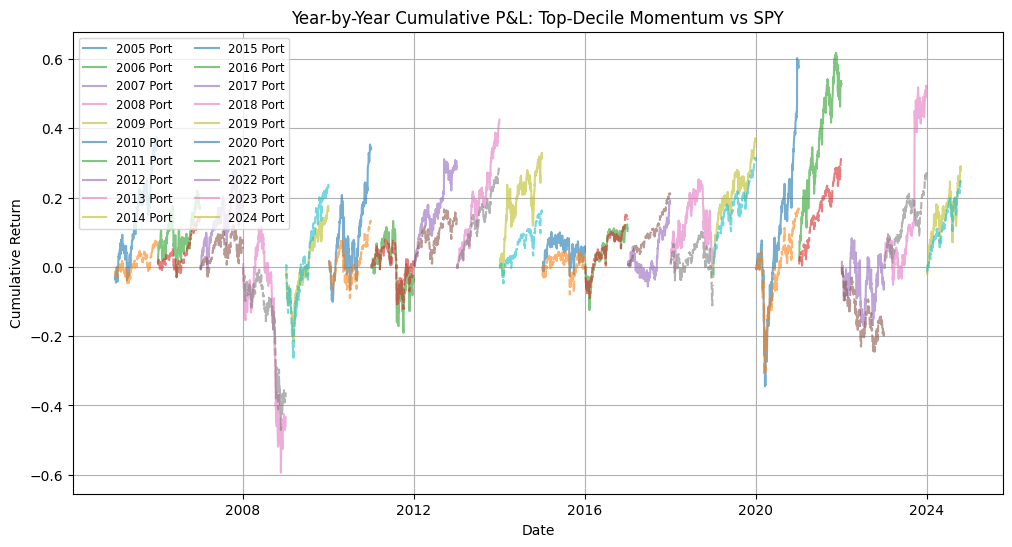

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# ========== USER PARAMETERS ==========
DATA_DIR     = Path("data")
STOCKS_CSV   = DATA_DIR / "stocks_cleaned_final.csv"
SPY_CSV      = DATA_DIR / "spy.csv"

START_YEAR   = 2005     # first test year
END_YEAR     = 2024     # upper bound; will be clamped to your data
TOP_QUANTILE = 0.10
# ======================================

def load_data():
    stocks = pd.read_csv(STOCKS_CSV, parse_dates=['Date'])
    stocks.sort_values(['Symbol','Date'], inplace=True)
    spy = pd.read_csv(SPY_CSV, parse_dates=['Date'])
    spy.sort_values('Date', inplace=True)
    return stocks, spy

def get_factor_prior_year(stocks, year):
    """
    For test-year=year, look at only the prior calendar year (Jan 1–Dec 31 of year-1)
    and pick each symbol's Price_Change_1Y on the last trading day of that prior year.
    """
    start = pd.to_datetime(f"{year-1}-01-01")
    end   = pd.to_datetime(f"{year-1}-12-31")
    df_year = stocks[(stocks['Date'] >= start) & (stocks['Date'] <= end)]
    
    # for each symbol, take its last row in that window
    last = (
        df_year
        .sort_values('Date')
        .groupby('Symbol', as_index=False)
        .last()[['Symbol','Price_Change_1Y']]
        .dropna(subset=['Price_Change_1Y'])
    )
    return last.set_index('Symbol')['Price_Change_1Y']

def top_decile_symbols(factor_series):
    n = len(factor_series)
    top_n = max(1, int(np.floor(TOP_QUANTILE * n)))
    return factor_series.nlargest(top_n).index.tolist()

def daily_portfolio_returns(price_wide, symbols):
    rets = price_wide[symbols].pct_change(fill_method=None).dropna(how='all')
    return rets.mean(axis=1)

def backtest_year(stocks, spy, year):
    # 1) get factor from only prior-year window
    factor = get_factor_prior_year(stocks, year)
    if factor.empty:
        raise ValueError(f"No factor data in prior year {year-1}")
    winners = top_decile_symbols(factor)

    # 2) slice prices for test-year
    test_start = f"{year}-01-01"
    test_end   = f"{year}-12-31"
    price_mat  = stocks.pivot(index='Date', columns='Symbol', values='Adjusted Close')
    price_test = price_mat.loc[test_start:test_end, winners]
    if price_test.empty:
        raise ValueError(f"No price data in test year {year}")

    # 3) compute returns
    port_rets = daily_portfolio_returns(price_test, winners)
    port_cum  = (1 + port_rets).cumprod() - 1

    spy_close = spy.set_index('Date')['Close'].loc[test_start:test_end]
    spy_rets  = spy_close.pct_change().dropna()
    spy_cum   = (1 + spy_rets).cumprod() - 1

    df = pd.DataFrame({'Portfolio': port_cum, 'SPY': spy_cum}).dropna()
    if df.empty:
        raise ValueError(f"No overlapping dates for portfolio vs SPY in {year}")

    port_final = df['Portfolio'].iloc[-1]
    spy_final  = df['SPY'].iloc[-1]
    alpha      = port_final - spy_final

    return year, port_final, spy_final, alpha, df

def run_multiple_years():
    stocks, spy = load_data()

    # clamp END_YEAR to available data
    last_stock_year = stocks['Date'].max().year
    last_spy_year   = spy['Date'].max().year
    max_year = min(last_stock_year, last_spy_year)
    if END_YEAR > max_year:
        print(f"Adjusting END_YEAR from {END_YEAR} to {max_year}")
    end_year = min(END_YEAR, max_year)

    results, curves = [], {}

    for year in range(START_YEAR, end_year+1):
        try:
            y, p, s, a, curve = backtest_year(stocks, spy, year)
            results.append((y, p, s, a))
            curves[year] = curve
        except ValueError as e:
            print(f"Skipping {year}: {e}")

    df_res = pd.DataFrame(results, columns=['Year','Portfolio','SPY','Alpha']).set_index('Year')
    df_fmt = df_res.applymap(lambda x: f"{x:.2%}")

    print("\n===== Annual Returns & Alpha =====")
    print(df_fmt)
    print("\nYear-by-year outperformance:")
    for year, row in df_res.iterrows():
        print(f"• {year}: portfolio {row['Portfolio']:.2%}, SPY {row['SPY']:.2%} ⇒ alpha {row['Alpha']:.2%}")

    plt.figure(figsize=(12,6))
    for year, curve in curves.items():
        plt.plot(curve.index, curve['Portfolio'], label=f'{year} Port', alpha=0.6)
        plt.plot(curve.index, curve['SPY'],    linestyle='--', alpha=0.6)
    plt.title("Year-by-Year Cumulative P&L: Top-Decile Momentum vs SPY")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return")
    plt.legend(loc='upper left', ncol=2, fontsize='small')
    plt.grid(True)
    plt.show()

if __name__ == '__main__':
    run_multiple_years()


# more advanced

Skipping 2006 - no test data
Skipping 2007 - no test data

Feature importances:
 Price_Change_1Y     0.241156
Price_Change_5Y     0.194445
EPS (ttm)           0.153682
P/E Ratio           0.146173
MA_200/Adj_Close    0.132360
MA_50/Adj_Close     0.132141
Dividend Amount     0.000042
CPI                 0.000000
Fed_Funds_Rate      0.000000
Inflation_Rate      0.000000
Treasury_Yield      0.000000
dtype: float64
2008: Portfolio 7.15%, SPY -37.13%, Alpha 44.28%

Feature importances:
 Price_Change_5Y     0.382004
MA_200/Adj_Close    0.300362
Price_Change_1Y     0.101310
EPS (ttm)           0.081796
MA_50/Adj_Close     0.068012
P/E Ratio           0.052180
Inflation_Rate      0.004328
Fed_Funds_Rate      0.003827
CPI                 0.003413
Treasury_Yield      0.002711
Dividend Amount     0.000058
dtype: float64
2009: Portfolio 206.31%, SPY 23.84%, Alpha 182.47%

Feature importances:
 Price_Change_5Y     0.354844
MA_200/Adj_Close    0.308258
Price_Change_1Y     0.101109
EPS (ttm)         

/var/folders/wm/fydrjt2543sch7051n5t7ygc0000gs/T/ipykernel_94303/1800064705.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_fmt = df_res.applymap(lambda x: f"{x:.2%}")


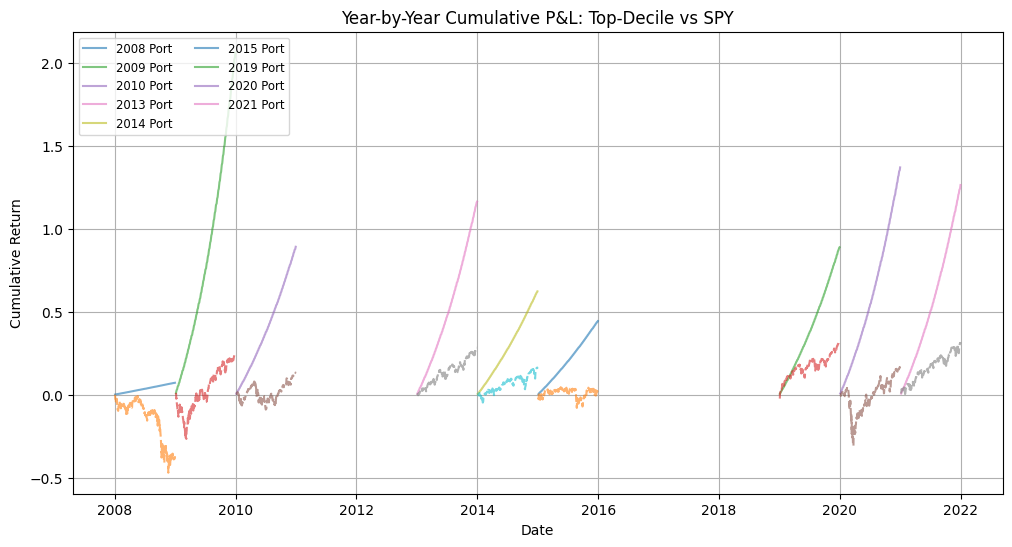

In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# ========== USER PARAMETERS ==========
DATA_DIR     = Path("data")
STOCKS_CSV   = DATA_DIR / "stocks_with_1yr_price_change.csv"
SPY_CSV      = DATA_DIR / "spy.csv"

START_YEAR   = 2005
END_YEAR     = 2024
TOP_QUANTILE = 0.10
# which columns to use as predictors:
FEATURE_COLS = [
    'Price_Change_1Y','Price_Change_5Y','P/E Ratio','EPS (ttm)',
    'Dividend Amount','MA_50/Adj_Close','MA_200/Adj_Close',
    'CPI','Fed_Funds_Rate','Inflation_Rate','Treasury_Yield'
]
# ======================================

def load_data():
    stocks = pd.read_csv(STOCKS_CSV, parse_dates=['Date'])
    stocks.sort_values(['Symbol','Date'], inplace=True)
    spy    = pd.read_csv(SPY_CSV,    parse_dates=['Date']).set_index('Date')
    return stocks, spy

def compute_equally_weighted_returns(price_wide, symbols):
    if not symbols:
        return pd.Series()
    # Get initial prices (first valid row)
    initial_prices = price_wide[symbols].iloc[0]
    # Compute value relative to initial
    normalized = price_wide[symbols] / initial_prices
    # Portfolio value is mean of normalized prices each day
    port_value = normalized.mean(axis=1)
    # Compute daily returns from portfolio value changes
    port_rets = port_value.pct_change().fillna(0)
    return port_rets

def make_feature_matrix(stocks, spy_data, as_of_date, *, need_target=False):
    """Build feature matrix X (and optionally y) as of *as_of_date*.

    Parameters
    ----------
    stocks : DataFrame
        Long‑format price & fundamentals with columns [Date, Symbol, ...].
    spy_data : DataFrame
        SPY prices indexed by Date.
    as_of_date : str or datetime‑like
        Snapshot date (inclusive).
    need_target : bool, default False
        If True, also return y = next‑12‑month excess return over SPY.
        During live prediction this must be False to avoid look‑ahead.
    """
    date = pd.to_datetime(as_of_date)

    # 1) latest fundamentals/price up to the snapshot date
    df = (
        stocks[stocks['Date'] <= date]
        .sort_values('Date')
        .groupby('Symbol', as_index=False)
        .last()
        .set_index('Symbol')
    )

    if not need_target:
        # Only features – no peeking at the future
        X = df[FEATURE_COLS].fillna(df[FEATURE_COLS].median())
        return X, None

    # 2) forward 12‑month stock returns (look‑ahead allowed only for training)
    price = stocks.pivot(index='Date', columns='Symbol', values='Adjusted Close')
    price_idx = price.index

    # last trading date on/before as_of_date
    d0 = date if date in price_idx else price_idx[price_idx <= date].max()

    # corresponding date 12 months ahead
    ed = date + pd.DateOffset(years=1)
    d1 = ed if ed in price_idx else price_idx[price_idx <= ed].max()

    fwd = price.loc[d1] / price.loc[d0] - 1.0

    # 3) forward SPY return
    spy_idx = spy_data.index
    date_spy = date if date in spy_idx else spy_idx[spy_idx <= date].max()
    ed_spy   = ed   if ed   in spy_idx else spy_idx[spy_idx <= ed].max()
    spy_ret  = spy_data.loc[ed_spy, 'Close'] / spy_data.loc[date_spy, 'Close'] - 1.0

    # 4) join target & features
    df = df.join(fwd.rename('FwdRet')).dropna(subset=['FwdRet'])
    df['FwdRet'] = df['FwdRet'] - spy_ret

    X = df[FEATURE_COLS].fillna(df[FEATURE_COLS].median())
    y = df['FwdRet']
    return X, y


def train_predictor(train_years, stocks, spy_data, as_of_date, X_pred):
    X_list, y_list = [], []
    for y in train_years:
        cut = f"{y}-12-31"
        try:
            Xi, yi = make_feature_matrix(stocks, spy_data, cut, need_target=True)
            X_list.append(Xi); y_list.append(yi)
        except Exception:
            continue

    if not X_list:
        raise ValueError("No training data for years: " + ", ".join(map(str, train_years)))
    X_train = pd.concat(X_list)
    y_train = pd.concat(y_list)

    model = Pipeline([
        ('scaler', StandardScaler()),
        ('rf', RandomForestRegressor(n_estimators=100, random_state=42))
    ])
    model.fit(X_train, y_train)

    fi = pd.Series(model.named_steps['rf'].feature_importances_,
                   index=FEATURE_COLS).sort_values(ascending=False)
    print("\nFeature importances:\n", fi)

    return model.predict(X_pred)


def backtest_year(stocks, spy_data, year, winners):
    # define test span
    test_start = f"{year}-01-01"
    test_end   = f"{year}-12-31"

    # pivot to wide
    price_pivot = stocks.pivot(index='Date', columns='Symbol', values='Adjusted Close')

    # slice out just our winners in the test year
    price_test = price_pivot.loc[test_start:test_end, winners]
    if price_test.empty:
        raise ValueError(f"No price data for winners in {year}")

    # portfolio cum‑return (daily equal‑weight → still optimistic but unchanged)
    port_rets = compute_equally_weighted_returns(price_test, winners)
    port_cum  = (1 + port_rets).cumprod() - 1

    # SPY cum‑return
    spy_close = spy_data['Close'].loc[test_start:test_end]
    spy_rets  = spy_close.pct_change().dropna()
    spy_cum   = (1 + spy_rets).cumprod() - 1

    df = pd.DataFrame({
        'Portfolio': port_cum,
        'SPY':       spy_cum
    }).dropna()

    port_final = df['Portfolio'].iloc[-1]
    spy_final  = df['SPY'].iloc[-1]
    alpha      = port_final - spy_final

    return year, port_final, spy_final, alpha, df


def backtest_with_model(stocks, spy_data):
    # clamp end year
    max_year = min(stocks['Date'].dt.year.max(), spy_data.index.year.max())
    end_year = min(END_YEAR, max_year)

    results, curves = [], {}
    # start at START_YEAR+1 so there's always at least one prior year to train on
    for year in range(START_YEAR+1, end_year+1):
        train_years = list(range(START_YEAR, year))
        as_of = f"{year-1}-12-31"

        # features for live prediction – *no* look‑ahead
        X_test, _ = make_feature_matrix(stocks, spy_data, as_of, need_target=False)

        preds = train_predictor(train_years, stocks, spy_data, as_of, X_test)
        scores = pd.Series(preds, index=X_test.index, name='Score')
        # 4) pick top decile
        topn = int(np.floor(TOP_QUANTILE * len(scores)))
        winners = scores.nlargest(topn).index.tolist()
        # 5) backtest exactly as before for year
        _, p_ret, s_ret, alpha, curve = backtest_year(stocks, spy_data, year, winners)
        results.append((year, p_ret, s_ret, alpha))
        curves[year] = curve

    # summarize as before...
    df_res = pd.DataFrame(results, columns=['Year', 'Portfolio', 'SPY', 'Alpha']).set_index('Year')
    df_fmt = df_res.applymap(lambda x: f"{x:.2%}")
    print("\n===== Annual Returns & Alpha =====")
    print(df_fmt)
    print("\nYear-by-year outperformance:")
    for year, row in df_res.iterrows():
        print(f"• {year}: portfolio {row['Portfolio']:.2%}, SPY {row['SPY']:.2%} ⇒ alpha {row['Alpha']:.2%}")

    plt.figure(figsize=(12, 6))
    for year, curve in curves.items():
        plt.plot(curve.index, curve['Portfolio'], label=f'{year} Port', alpha=0.6)
        plt.plot(curve.index, curve['SPY'], linestyle='--', alpha=0.6)
    plt.title("Year-by-Year Cumulative P&L: Top-Decile Momentum vs SPY")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return")
    plt.legend(loc='upper left', ncol=2, fontsize='small')
    plt.grid(True)
    plt.show()


if __name__ == '__main__':
    stocks, spy_data = load_data()
    backtest_with_model(stocks, spy_data)


# bare-bones training and test

In [ ]:
# TODO: 
# 1. create a ranking for stocks based on random forest model (very basic) for first 70% of years
# 2. use the ranking to select top 10% of stocks for each year
# 3. backtest the selected stocks for the last 30% of years
# 4. compare the performance of the selected stocks with SPY


STOCKS_CSV   = DATA_DIR / "stocks_with_1yr_price_change2.csv"
SPY_CSV      = DATA_DIR / "spy.csv"

FEATURE_COLS = [
    'Price_Change_1Y','Price_Change_5Y','P/E Ratio','EPS (ttm)',
    'Dividend Amount','MA_50/Adj_Close','MA_200/Adj_Close',
    'CPI','Fed_Funds_Rate','Inflation_Rate','Treasury_Yield'
]

def load_data():
    stocks = pd.read_csv(STOCKS_CSV, parse_dates=['Date'])
    stocks.sort_values(['Symbol','Date'], inplace=True)
    spy    = pd.read_csv(SPY_CSV,    parse_dates=['Date']).set_index('Date')
    return stocks, spy



# basic 4o

In [56]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from pathlib import Path

# File paths
DATA_DIR = Path("data")
STOCKS_CSV = DATA_DIR / "stocks_final.csv"
SPY_CSV = DATA_DIR / "spy.csv"

FEATURE_COLS = [
    'Adjusted Close',
    'Volume',
    'Dividend Amount',
    'Earnings',
    'P/E Ratio',
    'EPS (ttm)',
    'P/E (ttm)',
    # 'CPI',
    # 'Fed_Funds_Rate',
    # 'GDP_Per_Capita',
    # 'Inflation_Rate',
    # 'Real_GDP',
    # 'Treasury_Yield',
    # 'Unemployment_Rate',
    'MA_50',
    'MA_200',
    'Price_Change_1Y',
    'Price_Change_5Y',
    'Price_Change_10Y',
    'MA_50/Adj_Close',
    'MA_200/Adj_Close'
]

def load_data():
    stocks = pd.read_csv(STOCKS_CSV, parse_dates=['Date'])
    stocks.sort_values(['Symbol', 'Date'], inplace=True)
    spy = pd.read_csv(SPY_CSV, parse_dates=['Date'])
    return stocks, spy

def add_year_column(df):
    df['Year'] = df['Date'].dt.year
    return df

def get_train_test_split_years(stocks, train_frac=0.7):
    years = sorted(stocks['Year'].unique())
    cutoff_index = int(len(years) * train_frac)
    return years[:cutoff_index], years[cutoff_index:]

def train_random_forest(train_df, test_df):
    # Prepare training data
    X_train = train_df[FEATURE_COLS].fillna(0)
    y_train = train_df['Future_Price_Change_1Y'].fillna(0)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    # Prepare test data
    X_test = test_df[FEATURE_COLS].fillna(0)
    y_test = test_df['Future_Price_Change_1Y'].fillna(0)
    X_test_scaled = scaler.transform(X_test)

    # Train the model
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train_scaled, y_train)

    # Print feature importance
    feature_importances = pd.Series(model.feature_importances_, index=FEATURE_COLS).sort_values(ascending=False)
    print("\nFeature Importance:")
    print(feature_importances)

    # Calculate and print R² scores
    train_r2 = model.score(X_train_scaled, y_train)
    test_r2 = model.score(X_test_scaled, y_test)
    print(f"\nTraining R²: {train_r2:.2f}")
    print(f"Test R²: {test_r2:.2f}")

    return model, scaler

def rank_and_select(stocks, years_to_rank, model, scaler, top_pct=0.10):
    selected = []
    for year in years_to_rank:
        yearly_df = stocks[stocks['Year'] == year].copy()
        X = yearly_df[FEATURE_COLS].fillna(0)
        X_scaled = scaler.transform(X)
        yearly_df['Predicted'] = model.predict(X_scaled)
        top_n = int(len(yearly_df) * top_pct)
        top_stocks = yearly_df.nlargest(top_n, 'Predicted')
        # top_stocks = yearly_df.sample(frac=top_pct) random

        selected.append(top_stocks)
    return pd.concat(selected)

def calculate_spy_yearly_returns(spy, test_years):
    spy['Year'] = spy['Date'].dt.year
    spy_yearly = spy.groupby('Year')['Close'].last()
    spy_returns = spy_yearly.pct_change().dropna()
    return spy_returns.loc[spy_returns.index.intersection(test_years)]

from scipy.stats import spearmanr

def backtest(selected_stocks, spy, test_years):
    yearly_returns = selected_stocks.groupby('Year')['Future_Price_Change_1Y'].mean()
    spy_yearly_returns = calculate_spy_yearly_returns(spy, test_years)

    print("\nYearly Returns Comparison:")
    print(f"{'Year':<6} {'Selected Stocks':<20} {'SPY':<10}")
    spearman_correlations = []
    for year in test_years:
        stock_return = yearly_returns.get(year, float('nan'))
        spy_return = spy_yearly_returns.get(year, float('nan'))
        stock_return_str = f"{stock_return:.2%}" if not pd.isna(stock_return) else "N/A"
        spy_return_str = f"{spy_return:.2%}" if not pd.isna(spy_return) else "N/A"
        print(f"{year:<6} {stock_return_str:<20} {spy_return_str:<10}")

        # Calculate Spearman's rank correlation for the year
        year_data = selected_stocks[selected_stocks['Year'] == year]
        if not year_data.empty:
            spearman_corr, _ = spearmanr(year_data['Predicted'], year_data['Future_Price_Change_1Y'])
            spearman_correlations.append(spearman_corr)
            print(f"Spearman's Rank Correlation for {year}: {spearman_corr:.2f}")
        else:
            spearman_correlations.append(float('nan'))
            print(f"Spearman's Rank Correlation for {year}: N/A")

    # Calculate Sharpe ratio
    strategy_mean_return = yearly_returns.mean()
    strategy_std_dev = yearly_returns.std()
    risk_free_rate = 0.02  # Assume a 2% risk-free rate
    sharpe_ratio = (strategy_mean_return - risk_free_rate) / strategy_std_dev if strategy_std_dev != 0 else float('nan')

    print(f"\nSharpe Ratio of the strategy: {sharpe_ratio:.2f}")

    # Average Spearman's rank correlation
    avg_spearman_corr = np.nanmean(spearman_correlations)
    print(f"\nAverage Spearman's Rank Correlation: {avg_spearman_corr:.2f}")

    return strategy_mean_return, spy_yearly_returns.mean()
def main():
    stocks, spy = load_data()
    stocks = add_year_column(stocks)
    
    train_years, test_years = get_train_test_split_years(stocks)

    # Use only one entry per stock per year (e.g., last trading day)
    stocks = stocks.groupby(['Symbol', 'Year']).last().reset_index()

    train_df = stocks[stocks['Year'].isin(train_years)]
    test_df = stocks[stocks['Year'].isin(test_years)]
    model, scaler = train_random_forest(train_df, test_df)

    selected_stocks = rank_and_select(stocks, test_years, model, scaler)
    strategy_return, spy_return = backtest(selected_stocks, spy, test_years)

    print(f"\nBacktested average 1Y return of selected stocks: {strategy_return:.2%}")
    print(f"SPY average annual return over same period: {spy_return:.2%}")

if __name__ == "__main__":
    main()



Feature Importance:
MA_200/Adj_Close    0.325899
MA_50/Adj_Close     0.209701
Price_Change_1Y     0.114621
Price_Change_5Y     0.076810
Price_Change_10Y    0.052604
Volume              0.042767
Adjusted Close      0.037554
MA_200              0.034578
P/E Ratio           0.029942
MA_50               0.029340
EPS (ttm)           0.024882
Earnings            0.021181
Dividend Amount     0.000108
P/E (ttm)           0.000013
dtype: float64

Training R²: 0.87
Test R²: -0.57

Yearly Returns Comparison:
Year   Selected Stocks      SPY       
2017   -1.35%               21.71%    
Spearman's Rank Correlation for 2017: -0.18
2018   42.31%               -4.57%    
Spearman's Rank Correlation for 2018: -0.10
2019   29.63%               31.22%    
Spearman's Rank Correlation for 2019: 0.14
2020   56.04%               18.33%    
Spearman's Rank Correlation for 2020: 0.18
2021   -9.64%               28.73%    
Spearman's Rank Correlation for 2021: 0.13
2022   19.40%               -18.18%   
Spearm

# basic o3

In [39]:
# stock_strategy.py
"""
Basic factor‑based stock‑selection back‑test.

Steps implemented
-----------------
1. Load daily security fundamentals and macro features (see FEATURE_COLS below).
2. Aggregate to a yearly *snapshot* – by default the **first** trading day of each calendar year
   for every ticker – so that all features are known *ex‑ante*.
3. Split the available years 70 / 30 into *train* and *test* periods.
4. Fit a RandomForestRegressor that tries to predict the *next* 12‑month price change
   (``Price_Change_1Y``).
5. For each test year, predict expected return for every stock, pick the top decile
   and record the realised 1‑year return.
6. Compare the equal‑weight portfolio against the SPY ETF over the same horizon.

This script is intentionally lightweight and does **not** optimise hyper‑parameters or
frictional costs (slippage, commissions, bid/ask). Treat it as a starting point that you can
iterate on.
"""

from __future__ import annotations

from pathlib import Path
import warnings

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# ----------------------------
# Configuration
# ----------------------------

DATA_DIR = Path("data")  # change if your CSVs live elsewhere
STOCKS_CSV = DATA_DIR / "stocks_cleaned_final.csv"
SPY_CSV = DATA_DIR / "spy.csv"

FEATURE_COLS = [
    # "Price_Change_1Y",
    # "Price_Change_5Y",
    "P/E Ratio",
    "EPS (ttm)",
    # "Dividend Amount",
    # "MA_50/Adj_Close",
    # "MA_200/Adj_Close",
    # "CPI",
    # "Fed_Funds_Rate",
    # "Inflation_Rate",
    # "Treasury_Yield",
]

TOP_PCT = 0.05  # 10 % of stocks are selected each year
N_TREES = 200
RANDOM_STATE = 42

# ----------------------------
# I/O helpers
# ----------------------------

def load_data() -> tuple[pd.DataFrame, pd.DataFrame]:
    """Return **stocks**, **spy** dataframes after basic cleaning."""
    stocks = pd.read_csv(STOCKS_CSV, parse_dates=["Date"])
    stocks.sort_values(["Symbol", "Date"], inplace=True)

    spy = (
        pd.read_csv(SPY_CSV, parse_dates=["Date"])
        .set_index("Date")
        .sort_index()
    )

    # Normalise column names just once
    spy.columns = spy.columns.str.replace("[ /]", "_", regex=True).str.strip().str.lower()
    return stocks, spy

# ----------------------------
# Feature engineering
# ----------------------------

def yearly_snapshot(stocks: pd.DataFrame, when: str = "first") -> pd.DataFrame:
    """Collapse daily data to one row per **Symbol‑Year**.

    Parameters
    ----------
    when : "first" | "last"
        Whether to take the first or last trading day of each year.
    """
    if when not in {"first", "last"}:
        raise ValueError("`when` must be 'first' or 'last'.")

    # groupby idxmin / idxmax delivers the row‑indices we want
    grp = stocks.groupby(["Symbol", stocks["Date"].dt.year])
    idx = grp["Date"].idxmin() if when == "first" else grp["Date"].idxmax()
    snap = stocks.loc[idx].copy()
    snap["Year"] = snap["Date"].dt.year
    return snap

# ----------------------------
# Modelling
# ----------------------------

def build_model() -> Pipeline:
    """Random‑forest with standardised inputs."""
    return Pipeline(
        steps=[
            ("scale", StandardScaler()),
            (
                "rf",
                RandomForestRegressor(
                    n_estimators=N_TREES,
                    n_jobs=-1,
                    random_state=RANDOM_STATE,
                    oob_score=False,
                ),
            ),
        ]
    )


def fit_model(train_df: pd.DataFrame) -> Pipeline:
    X = train_df[FEATURE_COLS]
    y = train_df["Price_Change_1Y"]  # *future* 12‑month return
    model = build_model()
    model.fit(X, y)
    return model

# ----------------------------
# Portfolio construction & back‑test
# ----------------------------

def select_top_decile(snap_year: pd.DataFrame, model: Pipeline, pct: float = TOP_PCT) -> list[str]:
    X = snap_year[FEATURE_COLS]
    preds = model.predict(X)
    snap_year = snap_year.assign(_pred=preds)
    cutoff = np.quantile(preds, 1 - pct)
    return snap_year.loc[snap_year._pred >= cutoff, "Symbol"].tolist()


def realised_return(row_now: pd.Series, stocks: pd.DataFrame) -> float:
    """Return the actual 12‑month % change *from* row_now's date."""
    return row_now["Price_Change_1Y"]  # already computed in CSV


def backtest(
    stocks: pd.DataFrame,
    spy: pd.DataFrame,
    model: Pipeline,
    test_years: list[int],
    pct: float = TOP_PCT,
) -> pd.DataFrame:
    snapshots = yearly_snapshot(stocks, when="first")
    results: list[dict] = []

    for yr in test_years:
        snap_year = snapshots[snapshots["Year"] == yr]
        if snap_year.empty:
            continue  # no data for this year

        picks = select_top_decile(snap_year, model, pct)
        if not picks:
            warnings.warn(f"No picks for {yr}")
            continue

        actual = snap_year[snap_year["Symbol"].isin(picks)]["Price_Change_1Y"].mean()


        spy_start = spy.loc[spy.index.year == yr, "close"].iloc[0]
        spy_end = spy.loc[spy.index.year == yr + 1, "close"].iloc[0]
        spy_ret = (spy_end - spy_start) / spy_start



        results.append(
            {
                "Year": yr,
                "Portfolio_Return": actual,
                "SPY_Return": spy_ret,
                "Selected": picks,
            }
        )

    return pd.DataFrame(results)

# ----------------------------
# Main entry‑point
# ----------------------------

def main() -> None:  # pragma: no cover
    stocks, spy = load_data()

    snap = yearly_snapshot(stocks, when="first")
    years = sorted(snap["Year"].unique())

    split = int(len(years) * 0.7)
    train_years, test_years = years[:split], years[split:]

    model = fit_model(snap[snap["Year"].isin(train_years)])

    perf = backtest(stocks, spy, model, test_years)

    print("Back‑test results (equal‑weight portfolio vs. SPY):\n")
    print(perf.set_index("Year").loc[:, ["Portfolio_Return", "SPY_Return"]])

    print("\nAverage annualised excess return:", (perf.Portfolio_Return - perf.SPY_Return).mean())


if __name__ == "__main__":
    main()


ValueError: Input y contains NaN.

# o4 basic

In [13]:
# o4 basic with empty DataFrame handling
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer

# ─── Configuration ────────────────────────────────────────────────────────────
DATA_DIR     = Path("data")
STOCKS_CSV   = DATA_DIR / "stocks_with_1yr_price_change2.csv"
SPY_CSV      = DATA_DIR / "spy.csv"

# which columns to use as features
FEATURE_COLS = [
    'Price_Change_1Y','Price_Change_5Y','P/E Ratio','EPS (ttm)',
    'Dividend Amount','MA_50/Adj_Close','MA_200/Adj_Close',
    'CPI','Fed_Funds_Rate','Inflation_Rate','Treasury_Yield'
]

# ─── Step 0: load & prep ───────────────────────────────────────────────────────
def load_data():
    stocks = pd.read_csv(STOCKS_CSV, parse_dates=['Date'])
    stocks.sort_values(['Symbol','Date'], inplace=True)
    return stocks

def make_annual_snapshot(stocks):
    """
    For each symbol‐year, take the first available row as that year's 'signal' date.
    """
    stocks['Year'] = stocks['Date'].dt.year
    annual = (
        stocks
        .groupby(['Symbol','Year'], as_index=False)
        .first()        # earliest row per symbol‐year
    )
    return annual

# ─── Step 1: train a very basic RF ranking with missing value handling ────────
stocks = load_data()
annual = make_annual_snapshot(stocks)

years = sorted(annual['Year'].unique())
n_train = int(len(years) * 0.7)
train_years = years[:n_train]
test_years  = years[n_train:]

# Prepare training data - use imputer to handle missing values
train_df = annual[annual['Year'].isin(train_years)]
X_train = train_df[FEATURE_COLS]
y_train = train_df['Price_Change_1Y']

# Check if we have enough data for training
if len(X_train) == 0 or X_train.isnull().all().any():
    print("WARNING: Insufficient training data!")
else:
    # Create a pipeline with imputer to handle missing values
    imputer = SimpleImputer(strategy='median')
    X_train_imputed = imputer.fit_transform(X_train)

    # Fit model
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train_imputed, y_train)

    # ─── Step 2 & 3: for each test‐year, rank, pick top 10%, backtest ────────────
    results = []
    for year in test_years:
        year_df = annual[annual['Year'] == year]
        X_test  = year_df[FEATURE_COLS]
        
        # Skip empty years or years with no data
        if len(X_test) == 0:
            print(f"Skipping year {year}: No data available")
            continue
        
        # Impute missing values using the same imputer from training
        X_test_imputed = imputer.transform(X_test)
        
        # predict next‐year returns
        preds = model.predict(X_test_imputed)
        year_df = year_df.assign(Predicted=preds)
        
        # Skip if Price_Change_1Y is entirely NaN for this year
        if year_df['Price_Change_1Y'].isna().all():
            print(f"Skipping year {year}: No return data available")
            continue
        
        # pick the top decile
        if len(preds) > 0:
            cutoff = np.percentile(preds, 90)
            top = year_df[year_df['Predicted'] >= cutoff]
            
            # Handle case where all predictions are the same
            if len(top) == 0:
                print(f"All predictions same for {year}, selecting top 10% by index")
                top = year_df.nlargest(max(1, int(len(year_df) * 0.1)), 'Predicted')
            
            # compute actual average return for that basket 
            # (and handle missing values in the returns)
            avg_ret = top['Price_Change_1Y'].mean()
            results.append({'Year': year, 'Average_Return': avg_ret, 'Number_Stocks': len(top)})
        else:
            print(f"No valid predictions for year {year}")

    # compile backtest results if we have any
    if results:
        results_df = pd.DataFrame(results).sort_values('Year')
        results_df['Cumulative_Return'] = (1 + results_df['Average_Return']).cumprod() - 1

        # ─── Output ───────────────────────────────────────────────────────────────────
        print("\nBacktest by Year:")
        print(results_df.to_string(index=False, float_format="%.2f"))

        total_cum = results_df['Cumulative_Return'].iloc[-1]
        print(f"\nTotal cumulative return over test period: {total_cum:.2%}")
    else:
        print("No backtest results - check your data!")


Backtest by Year:
 Year  Average_Return  Number_Stocks  Cumulative_Return
 2017            0.92             64               0.92
 2018            0.81             64               2.48
 2019            0.43             63               3.99
 2020            1.06             63               9.25
 2021            1.50             63              24.66
 2022            1.37             62              59.76
 2023            0.49             62              89.56
 2024            0.87             62             168.51

Total cumulative return over test period: 16851.20%


# deepseek basic

In [42]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from pathlib import Path

DATA_DIR = Path("data")
STOCKS_CSV = DATA_DIR / "stocks_cleaned_final.csv"
SPY_CSV = DATA_DIR / "spy.csv"

FEATURE_COLS = [
    'Price_Change_1Y', 'Price_Change_5Y', 'P/E Ratio', 'EPS (ttm)',
    'Dividend Amount', 'MA_50/Adj_Close', 'MA_200/Adj_Close',
    'CPI', 'Fed_Funds_Rate', 'Inflation_Rate', 'Treasury_Yield'
]

def load_data():
    # Load and preprocess stock data
    stocks = pd.read_csv(STOCKS_CSV, parse_dates=['Date'])
    stocks.sort_values(['Symbol', 'Date'], inplace=True)

    # Use proper reset_index() before resampling to avoid duplicate columns
    stocks_indexed = stocks.set_index('Date')
    stocks_annual = stocks_indexed.groupby('Symbol').resample('Y').last().reset_index()

    # Calculate target: next year's return
    stocks_annual['Next_Year_Return'] = stocks_annual.groupby('Symbol')['Adjusted Close'].pct_change(-1)
    stocks_annual.dropna(subset=['Next_Year_Return'], inplace=True)
    
    # Load SPY data
    spy = pd.read_csv(SPY_CSV, parse_dates=['Date'])
    spy = spy.resample('Y', on='Date').last().reset_index(drop=False)
    spy['Year'] = spy['Date'].dt.year
    spy.set_index('Year', inplace=True)
    
    return stocks, spy

def main():
    stocks, spy = load_data()
    
    # Split data into train/test by years
    years = sorted(stocks['Date'].dt.year.unique())
    split_idx = int(len(years) * 0.7)
    train_years, test_years = years[:split_idx], years[split_idx:]
    
    # Prepare training data
    train_data = stocks[stocks['Date'].dt.year.isin(train_years)]
    X_train = train_data[FEATURE_COLS]
    y_train = train_data['Next_Year_Return']
    
    # Train Random Forest model
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    # Backtest on test years
    portfolio_returns = []
    spy_returns = []
    
    for year in test_years:
        year_data = stocks[stocks['Date'].dt.year == year]
        if len(year_data) < 10:
            continue
            
        # Make predictions
        X_test = year_data[FEATURE_COLS]
        year_data['Predicted_Return'] = model.predict(X_test)
        
        # Select top 10%
        top_10 = year_data.nlargest(int(len(year_data)*0.1), 'Predicted_Return')
        actual_return = top_10['Next_Year_Return'].mean()
        portfolio_returns.append(actual_return)
        
        # Get SPY return
        spy_return = spy.loc[year+1, 'Close']/spy.loc[year, 'Close'] - 1
        spy_returns.append(spy_return)
    
    # Calculate cumulative returns
    cumulative_portfolio = (1 + pd.Series(portfolio_returns)).cumprod() - 1
    cumulative_spy = (1 + pd.Series(spy_returns)).cumprod() - 1
    
    # Print results
    print("Portfolio Cumulative Returns:")
    print(cumulative_portfolio)
    print("\nSPY Cumulative Returns:")
    print(cumulative_spy)

if __name__ == "__main__":
    main()

/var/folders/wm/fydrjt2543sch7051n5t7ygc0000gs/T/ipykernel_1411/4201015041.py:23: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  stocks_annual = stocks_indexed.groupby('Symbol').resample('Y').last().reset_index()


ValueError: cannot insert Symbol, already exists

# o3 advanced rf

2025-05-06 10:47:49,737 INFO: Train 2001–2005 | Gap 2006–2006 | Test 2007
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
2025-05-06 10:48:48,086 INFO: Best R² 0.239 with params {'model__n_estimators': 200, 'model__min_samples_leaf': 8, 'model__max_features': 1.0, 'model__max_depth': 5}
2025-05-06 10:48:48,206 INFO: Train 2002–2006 | Gap 2007–2007 | Test 2008
2025-05-06 10:49:48,291 INFO: Best R² 0.140 with params {'model__n_estimators': 800, 'model__min_samples_leaf': 4, 'model__max_features': 0.5, 'model__max_depth': 5}
2025-05-06 10:49:48,417 INFO: Train 2003–2007 | Gap 2008–2008 | Test 2009
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped w


Year‑by‑Year Results (1-Year Horizon):
  Year  Strategy_Return  SPY_Return  SpearmanIC
 2007        -0.378694    0.051462    0.005062
 2008         0.748342   -0.367950    0.189540
 2009         0.000000    0.263518    0.042979
 2010        -0.010946    0.150561   -0.048541
 2011         0.243255    0.018950    0.094255
 2012         0.462201    0.159903    0.145052
 2013         0.158569    0.323078    0.073492
 2014        -0.027146    0.134638   -0.048543
 2015         0.191798    0.012343    0.082521
 2016         0.548719    0.119979    0.186220
 2017        -0.030226    0.217054   -0.096800
 2018         0.195924   -0.045690    0.148656
 2019         0.304326    0.312239    0.177076
 2020         0.309244    0.183316    0.018251
 2021        -0.100600    0.287288   -0.222487
 2022         0.138046   -0.181754    0.179989
 2023         0.373647    0.261758    0.251764


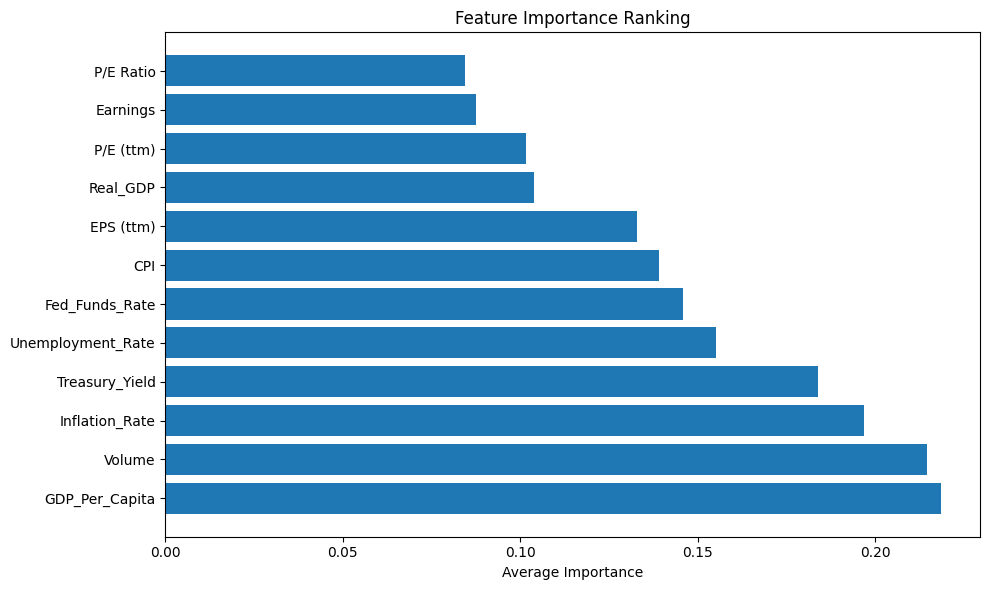

In [1]:
import logging
from pathlib import Path
from typing import List, Tuple
import numpy as np
import pandas as pd
from scipy.stats import spearmanr
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

logging.basicConfig(level=logging.INFO, format="%(asctime)s %(levelname)s: %(message)s")

# ---------------------------------------------------------------------------
# CONFIGURATION ----------------------------------------------------------------
# ---------------------------------------------------------------------------
DATA_DIR = Path("data")
STOCKS_CSV = DATA_DIR / "stocks_final.csv"
SPY_CSV = DATA_DIR / "spy.csv"

FEATURE_COLS: List[str] = [
    # "Adjusted Close",
    "Volume",
    "Dividend Amount",
    "Earnings",
    "P/E Ratio",
    "EPS (ttm)",
    "P/E (ttm)",
    "CPI",
    "Fed_Funds_Rate",
    "GDP_Per_Capita",
    "Inflation_Rate",
    "Real_GDP",
    "Treasury_Yield",
    "Unemployment_Rate",
    # "MA_50",
    # "MA_200",
    # "Price_Change_1Y",
    # "Price_Change_5Y",
    # "Price_Change_10Y",
    # "MA_50/Adj_Close",
    # "MA_200/Adj_Close",
]

RISK_FREE_RATE = 0.04  # 4 % p.a. constant risk‑free proxy


# ---------------------------------------------------------------------------
# FORECAST / BACK‑TEST SETTINGS
# ---------------------------------------------------------------------------
HORIZON_YEARS       = 1       # 3, 5, 10 … whatever target you want
ROLLING_WINDOW_YEARS = 5      # history for model fitting (can be ≠ horizon)
GAP_YEARS            = HORIZON_YEARS  # purge window to avoid look‑ahead

TARGET_COL = f"Future_Price_Change_{HORIZON_YEARS}Y"

# ---------------------------------------------------------------------------
# DATA HELPERS ----------------------------------------------------------------
# ---------------------------------------------------------------------------

def load_data() -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Load stocks & SPY data from CSV files."""
    stocks = pd.read_csv(STOCKS_CSV, parse_dates=["Date"])
    stocks.sort_values(["Symbol", "Date"], inplace=True)
    spy = pd.read_csv(SPY_CSV, parse_dates=["Date"])
    return stocks, spy


def add_year_column(df: pd.DataFrame) -> pd.DataFrame:
    df["Year"] = df["Date"].dt.year
    return df


def prepare_annual_observations(stocks: pd.DataFrame) -> pd.DataFrame:
    """Use the last available trading‑day row per Symbol‑Year."""
    return stocks.groupby(["Symbol", "Year"]).last().reset_index()

# ---------------------------------------------------------------------------
# PIPELINE BUILDERS -----------------------------------------------------------
# ---------------------------------------------------------------------------

def build_pipeline() -> Pipeline:
    """Preprocess → SelectFromModel → Random Forest pipeline."""

    numeric_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),  # RF doesn’t need scaling but keeps parity with older runs
    ])

    prep = ColumnTransformer([
        ("num", numeric_pipeline, FEATURE_COLS)
    ], remainder="drop")

    # Embedded selector: pick top 50 % most important features each fold
    selector_est = RandomForestRegressor(n_estimators=300, random_state=1, n_jobs=-1)
    selector = SelectFromModel(estimator=selector_est, threshold="median")

    rf_final = RandomForestRegressor(random_state=0, n_jobs=-1)

    return Pipeline([
        ("prep", prep),
        ("select", selector),
        ("model", rf_final),
    ])


def tune_model(pipe: Pipeline, X: pd.DataFrame, y: pd.Series) -> Pipeline:
    """Hyper‑parameter tuning for **final** RF stage only."""

    param_dist = {
        "model__n_estimators": [200, 400, 600, 800, 1000],
        "model__max_depth": [None, 5, 10, 20, 30],
        "model__min_samples_leaf": [1, 2, 4, 8],
        "model__max_features": ["sqrt", 0.5, 0.8, 1.0],
    }

    tscv = TimeSeriesSplit(n_splits=4)
    search = RandomizedSearchCV(
        pipe,
        param_distributions=param_dist,
        n_iter=50,
        cv=tscv,
        scoring="r2",
        random_state=0,
        n_jobs=-1,
        verbose=0,
    )
    search.fit(X, y)
    logging.info("Best R² %.3f with params %s", search.best_score_, search.best_params_)
    return search.best_estimator_

# ---------------------------------------------------------------------------
# PORTFOLIO & BACKTEST FUNCTIONS ---------------------------------------------
# ---------------------------------------------------------------------------

def certainty_weighted_portfolio(preds: pd.Series) -> pd.Series:
    positive = preds.clip(lower=0.0)
    return positive / positive.sum() if positive.sum() else pd.Series(0.0, index=preds.index)

def track_feature_importance(df: pd.DataFrame, model, feature_names: list) -> dict:
    """Extract and return feature importances from the model."""
    # For pipeline, extract the RF model
    if hasattr(model, 'named_steps') and 'model' in model.named_steps:
        rf_model = model.named_steps['model']
    else:
        rf_model = model
        
    # Get selected features if feature selection was used
    if hasattr(model, 'named_steps') and 'select' in model.named_steps:
        selector = model.named_steps['select']
        mask = selector.get_support()
        selected_features = [f for i, f in enumerate(feature_names) if mask[i]]
        importances = dict(zip(selected_features, rf_model.feature_importances_))
    else:
        importances = dict(zip(feature_names, rf_model.feature_importances_))
        
    return importances

def walk_forward_backtest(stocks: pd.DataFrame, spy: pd.DataFrame) -> Tuple[pd.DataFrame, dict]:
    years   = sorted(stocks["Year"].unique())
    results = []
    feature_importances = []

    start_idx = ROLLING_WINDOW_YEARS + GAP_YEARS   # enough data before first test

    for idx in range(start_idx, len(years)):
        test_year   = years[idx]
        train_years = years[idx - GAP_YEARS - ROLLING_WINDOW_YEARS : idx - GAP_YEARS]

        logging.info("Train %s–%s | Gap %s–%s | Test %s",
                     train_years[0], train_years[-1],
                     train_years[-1] + 1, test_year - 1,
                     test_year)

        train_df = stocks[stocks["Year"].isin(train_years)].copy()
        test_df  = stocks[stocks["Year"] == test_year].copy()

        # drop rows lacking the H‑year forward return
        train_df = train_df.dropna(subset=[TARGET_COL])
        test_df  = test_df .dropna(subset=[TARGET_COL])
        if train_df.empty or test_df.empty:
            logging.warning("Skipping %s – insufficient data after NaN filter.", test_year)
            continue

        X_train, y_train = train_df[FEATURE_COLS], train_df[TARGET_COL]

        model = tune_model(build_pipeline(), X_train, y_train)

        # Track feature importance for this model run
        importances = track_feature_importance(stocks, model, FEATURE_COLS)
        feature_importances.append(importances)

        preds = pd.Series(model.predict(test_df[FEATURE_COLS]),
                          index=test_df.index, name="Predicted")
        test_df["Predicted"] = preds
        weights = certainty_weighted_portfolio(preds)
        test_df["Weight"]  = weights

        realised_return = (weights * test_df[TARGET_COL]).sum()

        # horizon‑matched SPY benchmark
        try:
            spy_end   = spy.loc[spy["Year"] == test_year,               "Close"].iloc[-1]
            spy_start = spy.loc[spy["Year"] == test_year - HORIZON_YEARS, "Close"].iloc[-1]
            spy_ret   = spy_end / spy_start - 1
        except IndexError:
            spy_ret = np.nan
            logging.warning("Missing SPY data for %d‑year return in %s", HORIZON_YEARS, test_year)

        rho, _ = spearmanr(test_df["Predicted"], test_df[TARGET_COL])

        results.append({
            "Year":            test_year,
            "Strategy_Return": realised_return,
            "SPY_Return":      spy_ret,
            "SpearmanIC":      rho,
        })

    return pd.DataFrame(results), feature_importances



# ---------------------------------------------------------------------------
# METRICS ---------------------------------------------------------------------
# ---------------------------------------------------------------------------

def performance_metrics(df: pd.DataFrame, feature_importances: list) -> None:
    avg_return = df["Strategy_Return"].mean()
    vol = df["Strategy_Return"].std(ddof=1)
    sharpe = (avg_return - RISK_FREE_RATE) / vol if vol else np.nan

    logging.info("\n=== PERFORMANCE SUMMARY ===")
    logging.info("Years tested: %s", list(df["Year"]))
    logging.info("Mean Strategy Return: %.2f %%", avg_return * 100)
    logging.info("Mean SPY Return: %.2f %%", df["SPY_Return"].mean() * 100)
    logging.info("Sharpe Ratio: %.2f", sharpe)
    logging.info("Average Spearman IC: %.2f", df["SpearmanIC"].mean())

    # Average feature importances across all models
    all_importances = {}
    for imp_dict in feature_importances:
        for feature, importance in imp_dict.items():
            if feature not in all_importances:
                all_importances[feature] = []
            all_importances[feature].append(importance)
    
    avg_importances = {feature: sum(values)/len(values) 
                      for feature, values in all_importances.items() 
                      if values}  # Only include features that appeared in at least one model
    
    # Sort by importance and display
    sorted_importances = sorted(avg_importances.items(), key=lambda x: x[1], reverse=True)
    logging.info("\n=== AVERAGE FEATURE IMPORTANCE ===")
    for feature, importance in sorted_importances:
        logging.info(f"{feature:25}: {importance:.4f}")
    
    # Optional: Create a bar chart
    features, importances = zip(*sorted_importances)
    plt.figure(figsize=(10, 6))
    plt.barh(features, importances)
    plt.xlabel('Average Importance')
    plt.title('Feature Importance Ranking')
    plt.tight_layout()
    plt.savefig("feature_importance.png")
    logging.info("Feature importance chart saved as 'feature_importance.png'")

# ---------------------------------------------------------------------------
# MAIN -------------------------------------------------------------------------
# ---------------------------------------------------------------------------

def main() -> None:
    stocks, spy = load_data()
    stocks = add_year_column(stocks)
    spy = add_year_column(spy)

    # ensure one record per symbol‑year
    stocks = prepare_annual_observations(stocks)

    backtest_df, feature_importances = walk_forward_backtest(stocks, spy)

    if backtest_df.empty:
        logging.error("Backtest produced no results. Check data coverage & target calculation.")
        return

    performance_metrics(backtest_df, feature_importances)

    # Show final table
    print(f"\nYear‑by‑Year Results ({HORIZON_YEARS}-Year Horizon):\n", backtest_df.to_string(index=False))


if __name__ == "__main__":
    main()


# 3yr future for predictor

2025-05-06 11:04:48,237 INFO: Train 2001–2005 | Gap 2006–2008 | Test 2009
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
2025-05-06 11:05:45,540 INFO: Best R² 0.230 with params {'model__n_estimators': 200, 'model__min_samples_leaf': 8, 'model__max_features': 1.0, 'model__max_depth': 5}
2025-05-06 11:05:45,636 INFO: Train 2002–2006 | Gap 2007–2009 | Test 2010
2025-05-06 11:06:41,572 INFO: Best R² 0.270 with params {'model__n_estimators': 800, 'model__min_samples_leaf': 8, 'model__max_features': 1.0, 'model__max_depth': 5}
2025-05-06 11:06:41,705 INFO: Train 2003–2007 | Gap 2008–2010 | Test 2011
2025-05-06 11:07:37,539 INFO: Best R² 0.250 with params {'model__n_estimators': 200, 'model__min_samples_leaf': 8, 'model__max_features': 'sqrt', 'model__max_


Year‑by‑Year Results (3-Year Horizon):
  Year  Strategy_Return  SPY_Return  SpearmanIC
 2009         0.522805   -0.160295    0.120950
 2010         0.687904   -0.081154    0.052091
 2011         1.048696    0.481303    0.136099
 2012         0.880808    0.359829    0.177532
 2013         0.348446    0.563723    0.160131
 2014         0.438535    0.741264    0.087247
 2015         0.431221    0.519744    0.051954
 2016         0.564471    0.286456    0.065687
 2017         0.710583    0.379899    0.089256
 2018         1.318488    0.300796    0.349439
 2019         0.583428    0.524096    0.263424
 2020         0.370519    0.481846    0.113583
 2021         0.434226    0.998892   -0.015445


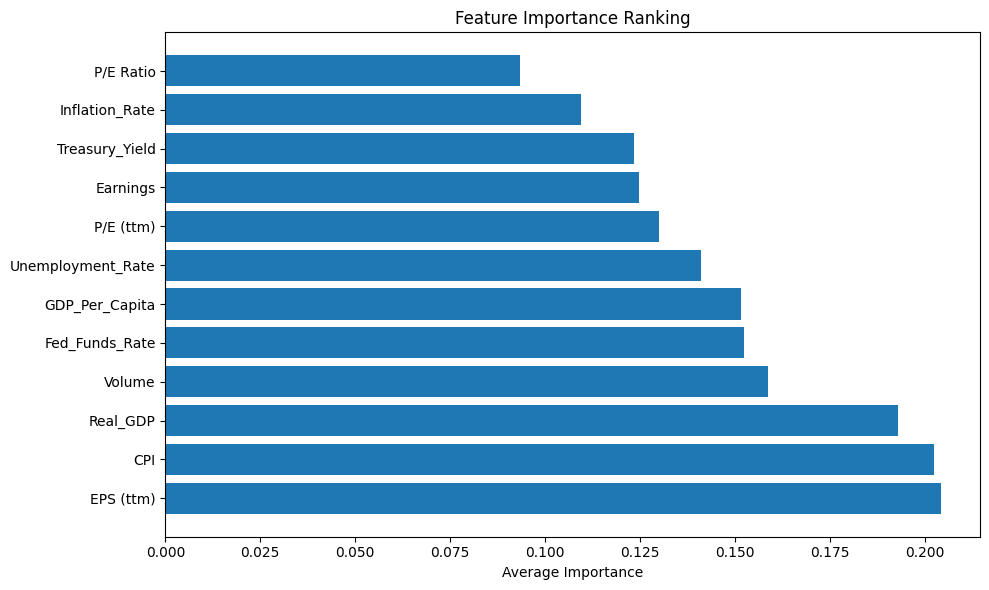

In [2]:
import logging
from pathlib import Path
from typing import List, Tuple
import numpy as np
import pandas as pd
from scipy.stats import spearmanr
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

logging.basicConfig(level=logging.INFO, format="%(asctime)s %(levelname)s: %(message)s")

# ---------------------------------------------------------------------------
# CONFIGURATION ----------------------------------------------------------------
# ---------------------------------------------------------------------------
DATA_DIR = Path("data")
STOCKS_CSV = DATA_DIR / "stocks_final.csv"
SPY_CSV = DATA_DIR / "spy.csv"

FEATURE_COLS: List[str] = [
    # "Adjusted Close",
    "Volume",
    "Dividend Amount",
    "Earnings",
    "P/E Ratio",
    "EPS (ttm)",
    "P/E (ttm)",
    "CPI",
    "Fed_Funds_Rate",
    "GDP_Per_Capita",
    "Inflation_Rate",
    "Real_GDP",
    "Treasury_Yield",
    "Unemployment_Rate",
    # "MA_50",
    # "MA_200",
    # "Price_Change_1Y",
    # "Price_Change_5Y",
    # "Price_Change_10Y",
    # "MA_50/Adj_Close",
    # "MA_200/Adj_Close",
]

RISK_FREE_RATE = 0.04  # 4 % p.a. constant risk‑free proxy


# ---------------------------------------------------------------------------
# FORECAST / BACK‑TEST SETTINGS
# ---------------------------------------------------------------------------
HORIZON_YEARS       = 3       # 3, 5, 10 … whatever target you want
ROLLING_WINDOW_YEARS = 5      # history for model fitting (can be ≠ horizon)
GAP_YEARS            = HORIZON_YEARS  # purge window to avoid look‑ahead

TARGET_COL = f"Future_Price_Change_{HORIZON_YEARS}Y"

# ---------------------------------------------------------------------------
# DATA HELPERS ----------------------------------------------------------------
# ---------------------------------------------------------------------------

def load_data() -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Load stocks & SPY data from CSV files."""
    stocks = pd.read_csv(STOCKS_CSV, parse_dates=["Date"])
    stocks.sort_values(["Symbol", "Date"], inplace=True)
    spy = pd.read_csv(SPY_CSV, parse_dates=["Date"])
    return stocks, spy


def add_year_column(df: pd.DataFrame) -> pd.DataFrame:
    df["Year"] = df["Date"].dt.year
    return df


def prepare_annual_observations(stocks: pd.DataFrame) -> pd.DataFrame:
    """Use the last available trading‑day row per Symbol‑Year."""
    return stocks.groupby(["Symbol", "Year"]).last().reset_index()

# ---------------------------------------------------------------------------
# PIPELINE BUILDERS -----------------------------------------------------------
# ---------------------------------------------------------------------------

def build_pipeline() -> Pipeline:
    """Preprocess → SelectFromModel → Random Forest pipeline."""

    numeric_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),  # RF doesn’t need scaling but keeps parity with older runs
    ])

    prep = ColumnTransformer([
        ("num", numeric_pipeline, FEATURE_COLS)
    ], remainder="drop")

    # Embedded selector: pick top 50 % most important features each fold
    selector_est = RandomForestRegressor(n_estimators=300, random_state=1, n_jobs=-1)
    selector = SelectFromModel(estimator=selector_est, threshold="median")

    rf_final = RandomForestRegressor(random_state=0, n_jobs=-1)

    return Pipeline([
        ("prep", prep),
        ("select", selector),
        ("model", rf_final),
    ])


def tune_model(pipe: Pipeline, X: pd.DataFrame, y: pd.Series) -> Pipeline:
    """Hyper‑parameter tuning for **final** RF stage only."""

    param_dist = {
        "model__n_estimators": [200, 400, 600, 800, 1000],
        "model__max_depth": [None, 5, 10, 20, 30],
        "model__min_samples_leaf": [1, 2, 4, 8],
        "model__max_features": ["sqrt", 0.5, 0.8, 1.0],
    }

    tscv = TimeSeriesSplit(n_splits=4)
    search = RandomizedSearchCV(
        pipe,
        param_distributions=param_dist,
        n_iter=50,
        cv=tscv,
        scoring="r2",
        random_state=0,
        n_jobs=-1,
        verbose=0,
    )
    search.fit(X, y)
    logging.info("Best R² %.3f with params %s", search.best_score_, search.best_params_)
    return search.best_estimator_

# ---------------------------------------------------------------------------
# PORTFOLIO & BACKTEST FUNCTIONS ---------------------------------------------
# ---------------------------------------------------------------------------

def certainty_weighted_portfolio(preds: pd.Series) -> pd.Series:
    positive = preds.clip(lower=0.0)
    return positive / positive.sum() if positive.sum() else pd.Series(0.0, index=preds.index)

def track_feature_importance(df: pd.DataFrame, model, feature_names: list) -> dict:
    """Extract and return feature importances from the model."""
    # For pipeline, extract the RF model
    if hasattr(model, 'named_steps') and 'model' in model.named_steps:
        rf_model = model.named_steps['model']
    else:
        rf_model = model
        
    # Get selected features if feature selection was used
    if hasattr(model, 'named_steps') and 'select' in model.named_steps:
        selector = model.named_steps['select']
        mask = selector.get_support()
        selected_features = [f for i, f in enumerate(feature_names) if mask[i]]
        importances = dict(zip(selected_features, rf_model.feature_importances_))
    else:
        importances = dict(zip(feature_names, rf_model.feature_importances_))
        
    return importances

def walk_forward_backtest(stocks: pd.DataFrame, spy: pd.DataFrame) -> Tuple[pd.DataFrame, dict]:
    years   = sorted(stocks["Year"].unique())
    results = []
    feature_importances = []

    start_idx = ROLLING_WINDOW_YEARS + GAP_YEARS   # enough data before first test

    for idx in range(start_idx, len(years)):
        test_year   = years[idx]
        train_years = years[idx - GAP_YEARS - ROLLING_WINDOW_YEARS : idx - GAP_YEARS]

        logging.info("Train %s–%s | Gap %s–%s | Test %s",
                     train_years[0], train_years[-1],
                     train_years[-1] + 1, test_year - 1,
                     test_year)

        train_df = stocks[stocks["Year"].isin(train_years)].copy()
        test_df  = stocks[stocks["Year"] == test_year].copy()

        # drop rows lacking the H‑year forward return
        train_df = train_df.dropna(subset=[TARGET_COL])
        test_df  = test_df .dropna(subset=[TARGET_COL])
        if train_df.empty or test_df.empty:
            logging.warning("Skipping %s – insufficient data after NaN filter.", test_year)
            continue

        X_train, y_train = train_df[FEATURE_COLS], train_df[TARGET_COL]

        model = tune_model(build_pipeline(), X_train, y_train)

        # Track feature importance for this model run
        importances = track_feature_importance(stocks, model, FEATURE_COLS)
        feature_importances.append(importances)

        preds = pd.Series(model.predict(test_df[FEATURE_COLS]),
                          index=test_df.index, name="Predicted")
        test_df["Predicted"] = preds
        weights = certainty_weighted_portfolio(preds)
        test_df["Weight"]  = weights

        realised_return = (weights * test_df[TARGET_COL]).sum()

        # horizon‑matched SPY benchmark
        try:
            spy_end   = spy.loc[spy["Year"] == test_year,               "Close"].iloc[-1]
            spy_start = spy.loc[spy["Year"] == test_year - HORIZON_YEARS, "Close"].iloc[-1]
            spy_ret   = spy_end / spy_start - 1
        except IndexError:
            spy_ret = np.nan
            logging.warning("Missing SPY data for %d‑year return in %s", HORIZON_YEARS, test_year)

        rho, _ = spearmanr(test_df["Predicted"], test_df[TARGET_COL])

        results.append({
            "Year":            test_year,
            "Strategy_Return": realised_return,
            "SPY_Return":      spy_ret,
            "SpearmanIC":      rho,
        })

    return pd.DataFrame(results), feature_importances



# ---------------------------------------------------------------------------
# METRICS ---------------------------------------------------------------------
# ---------------------------------------------------------------------------

def performance_metrics(df: pd.DataFrame, feature_importances: list) -> None:
    avg_return = df["Strategy_Return"].mean()
    vol = df["Strategy_Return"].std(ddof=1)
    sharpe = (avg_return - RISK_FREE_RATE) / vol if vol else np.nan

    logging.info("\n=== PERFORMANCE SUMMARY ===")
    logging.info("Years tested: %s", list(df["Year"]))
    logging.info("Mean Strategy Return: %.2f %%", avg_return * 100)
    logging.info("Mean SPY Return: %.2f %%", df["SPY_Return"].mean() * 100)
    logging.info("Sharpe Ratio: %.2f", sharpe)
    logging.info("Average Spearman IC: %.2f", df["SpearmanIC"].mean())

    # Average feature importances across all models
    all_importances = {}
    for imp_dict in feature_importances:
        for feature, importance in imp_dict.items():
            if feature not in all_importances:
                all_importances[feature] = []
            all_importances[feature].append(importance)
    
    avg_importances = {feature: sum(values)/len(values) 
                      for feature, values in all_importances.items() 
                      if values}  # Only include features that appeared in at least one model
    
    # Sort by importance and display
    sorted_importances = sorted(avg_importances.items(), key=lambda x: x[1], reverse=True)
    logging.info("\n=== AVERAGE FEATURE IMPORTANCE ===")
    for feature, importance in sorted_importances:
        logging.info(f"{feature:25}: {importance:.4f}")
    
    # Optional: Create a bar chart
    features, importances = zip(*sorted_importances)
    plt.figure(figsize=(10, 6))
    plt.barh(features, importances)
    plt.xlabel('Average Importance')
    plt.title('Feature Importance Ranking')
    plt.tight_layout()
    plt.savefig("feature_importance.png")
    logging.info("Feature importance chart saved as 'feature_importance.png'")

# ---------------------------------------------------------------------------
# MAIN -------------------------------------------------------------------------
# ---------------------------------------------------------------------------

def main() -> None:
    stocks, spy = load_data()
    stocks = add_year_column(stocks)
    spy = add_year_column(spy)

    # ensure one record per symbol‑year
    stocks = prepare_annual_observations(stocks)

    backtest_df, feature_importances = walk_forward_backtest(stocks, spy)

    if backtest_df.empty:
        logging.error("Backtest produced no results. Check data coverage & target calculation.")
        return

    performance_metrics(backtest_df, feature_importances)

    # Show final table
    print(f"\nYear‑by‑Year Results ({HORIZON_YEARS}-Year Horizon):\n", backtest_df.to_string(index=False))

if __name__ == "__main__":
    main()


# 5yr future predictor

2025-05-06 11:18:04,350 INFO: Train 2001–2005 | Gap 2006–2010 | Test 2011
2025-05-06 11:19:04,157 INFO: Best R² 0.162 with params {'model__n_estimators': 1000, 'model__min_samples_leaf': 8, 'model__max_features': 0.8, 'model__max_depth': None}
2025-05-06 11:19:04,313 INFO: Train 2002–2006 | Gap 2007–2011 | Test 2012
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
2025-05-06 11:20:07,774 INFO: Best R² 0.154 with params {'model__n_estimators': 1000, 'model__min_samples_leaf': 8, 'model__max_features': 0.5, 'model__max_depth': 10}
2025-05-06 11:20:07,933 INFO: Train 2003–2007 | Gap 2008–2012 | Test 2013
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker sto


Year‑by‑Year Results (5-Year Horizon):
  Year  Strategy_Return  SPY_Return  SpearmanIC
 2011         1.332965   -0.015560    0.148569
 2012         1.696696    0.085968    0.105037
 2013         1.241619    1.273271    0.168176
 2014         0.789777    1.041395    0.188284
 2015         1.114347    0.796159    0.107055
 2016         2.732206    0.974249    0.003842
 2017         1.491692    1.071524    0.217244
 2018         0.912204    0.494150    0.212196
 2019         0.993866    0.728024    0.226087


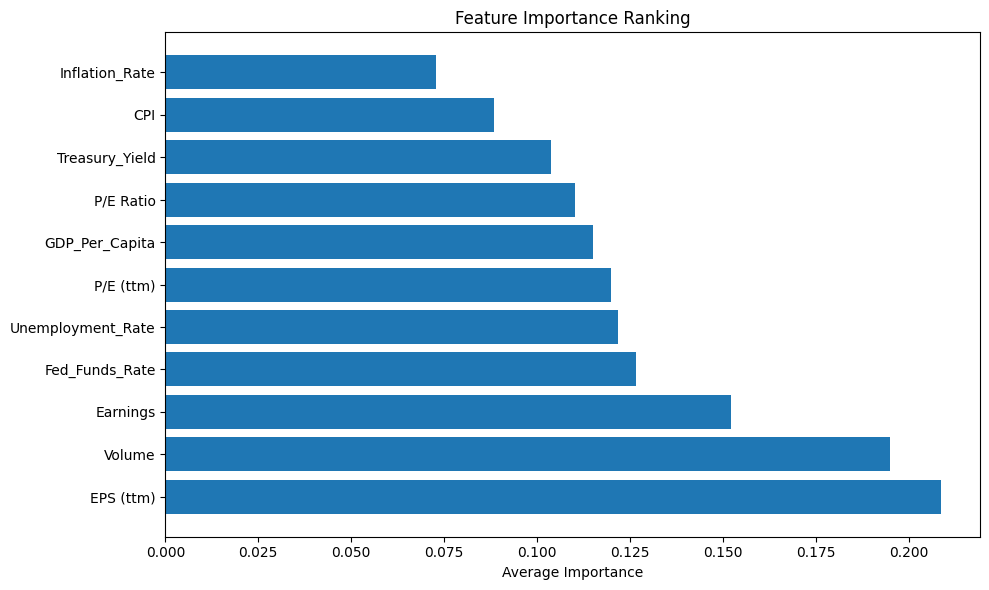

In [3]:
import logging
from pathlib import Path
from typing import List, Tuple
import numpy as np
import pandas as pd
from scipy.stats import spearmanr
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

logging.basicConfig(level=logging.INFO, format="%(asctime)s %(levelname)s: %(message)s")

# ---------------------------------------------------------------------------
# CONFIGURATION ----------------------------------------------------------------
# ---------------------------------------------------------------------------
DATA_DIR = Path("data")
STOCKS_CSV = DATA_DIR / "stocks_final.csv"
SPY_CSV = DATA_DIR / "spy.csv"

FEATURE_COLS: List[str] = [
    # "Adjusted Close",
    "Volume",
    "Dividend Amount",
    "Earnings",
    "P/E Ratio",
    "EPS (ttm)",
    "P/E (ttm)",
    "CPI",
    "Fed_Funds_Rate",
    "GDP_Per_Capita",
    "Inflation_Rate",
    "Real_GDP",
    "Treasury_Yield",
    "Unemployment_Rate",
    # "MA_50",
    # "MA_200",
    # "Price_Change_1Y",
    # "Price_Change_5Y",
    # "Price_Change_10Y",
    # "MA_50/Adj_Close",
    # "MA_200/Adj_Close",
]

RISK_FREE_RATE = 0.04  # 4 % p.a. constant risk‑free proxy


# ---------------------------------------------------------------------------
# FORECAST / BACK‑TEST SETTINGS
# ---------------------------------------------------------------------------
HORIZON_YEARS       = 5       # 3, 5, 10 … whatever target you want
ROLLING_WINDOW_YEARS = 5      # history for model fitting (can be ≠ horizon)
GAP_YEARS            = HORIZON_YEARS  # purge window to avoid look‑ahead

TARGET_COL = f"Future_Price_Change_{HORIZON_YEARS}Y"

# ---------------------------------------------------------------------------
# DATA HELPERS ----------------------------------------------------------------
# ---------------------------------------------------------------------------

def load_data() -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Load stocks & SPY data from CSV files."""
    stocks = pd.read_csv(STOCKS_CSV, parse_dates=["Date"])
    stocks.sort_values(["Symbol", "Date"], inplace=True)
    spy = pd.read_csv(SPY_CSV, parse_dates=["Date"])
    return stocks, spy


def add_year_column(df: pd.DataFrame) -> pd.DataFrame:
    df["Year"] = df["Date"].dt.year
    return df


def prepare_annual_observations(stocks: pd.DataFrame) -> pd.DataFrame:
    """Use the last available trading‑day row per Symbol‑Year."""
    return stocks.groupby(["Symbol", "Year"]).last().reset_index()

# ---------------------------------------------------------------------------
# PIPELINE BUILDERS -----------------------------------------------------------
# ---------------------------------------------------------------------------

def build_pipeline() -> Pipeline:
    """Preprocess → SelectFromModel → Random Forest pipeline."""

    numeric_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),  # RF doesn’t need scaling but keeps parity with older runs
    ])

    prep = ColumnTransformer([
        ("num", numeric_pipeline, FEATURE_COLS)
    ], remainder="drop")

    # Embedded selector: pick top 50 % most important features each fold
    selector_est = RandomForestRegressor(n_estimators=300, random_state=1, n_jobs=-1)
    selector = SelectFromModel(estimator=selector_est, threshold="median")

    rf_final = RandomForestRegressor(random_state=0, n_jobs=-1)

    return Pipeline([
        ("prep", prep),
        ("select", selector),
        ("model", rf_final),
    ])


def tune_model(pipe: Pipeline, X: pd.DataFrame, y: pd.Series) -> Pipeline:
    """Hyper‑parameter tuning for **final** RF stage only."""

    param_dist = {
        "model__n_estimators": [200, 400, 600, 800, 1000],
        "model__max_depth": [None, 5, 10, 20, 30],
        "model__min_samples_leaf": [1, 2, 4, 8],
        "model__max_features": ["sqrt", 0.5, 0.8, 1.0],
    }

    tscv = TimeSeriesSplit(n_splits=4)
    search = RandomizedSearchCV(
        pipe,
        param_distributions=param_dist,
        n_iter=50,
        cv=tscv,
        scoring="r2",
        random_state=0,
        n_jobs=-1,
        verbose=0,
    )
    search.fit(X, y)
    logging.info("Best R² %.3f with params %s", search.best_score_, search.best_params_)
    return search.best_estimator_

# ---------------------------------------------------------------------------
# PORTFOLIO & BACKTEST FUNCTIONS ---------------------------------------------
# ---------------------------------------------------------------------------

def certainty_weighted_portfolio(preds: pd.Series) -> pd.Series:
    positive = preds.clip(lower=0.0)
    return positive / positive.sum() if positive.sum() else pd.Series(0.0, index=preds.index)

def track_feature_importance(df: pd.DataFrame, model, feature_names: list) -> dict:
    """Extract and return feature importances from the model."""
    # For pipeline, extract the RF model
    if hasattr(model, 'named_steps') and 'model' in model.named_steps:
        rf_model = model.named_steps['model']
    else:
        rf_model = model
        
    # Get selected features if feature selection was used
    if hasattr(model, 'named_steps') and 'select' in model.named_steps:
        selector = model.named_steps['select']
        mask = selector.get_support()
        selected_features = [f for i, f in enumerate(feature_names) if mask[i]]
        importances = dict(zip(selected_features, rf_model.feature_importances_))
    else:
        importances = dict(zip(feature_names, rf_model.feature_importances_))
        
    return importances

def walk_forward_backtest(stocks: pd.DataFrame, spy: pd.DataFrame) -> Tuple[pd.DataFrame, dict]:
    years   = sorted(stocks["Year"].unique())
    results = []
    feature_importances = []

    start_idx = ROLLING_WINDOW_YEARS + GAP_YEARS   # enough data before first test

    for idx in range(start_idx, len(years)):
        test_year   = years[idx]
        train_years = years[idx - GAP_YEARS - ROLLING_WINDOW_YEARS : idx - GAP_YEARS]

        logging.info("Train %s–%s | Gap %s–%s | Test %s",
                     train_years[0], train_years[-1],
                     train_years[-1] + 1, test_year - 1,
                     test_year)

        train_df = stocks[stocks["Year"].isin(train_years)].copy()
        test_df  = stocks[stocks["Year"] == test_year].copy()

        # drop rows lacking the H‑year forward return
        train_df = train_df.dropna(subset=[TARGET_COL])
        test_df  = test_df .dropna(subset=[TARGET_COL])
        if train_df.empty or test_df.empty:
            logging.warning("Skipping %s – insufficient data after NaN filter.", test_year)
            continue

        X_train, y_train = train_df[FEATURE_COLS], train_df[TARGET_COL]

        model = tune_model(build_pipeline(), X_train, y_train)

        # Track feature importance for this model run
        importances = track_feature_importance(stocks, model, FEATURE_COLS)
        feature_importances.append(importances)

        preds = pd.Series(model.predict(test_df[FEATURE_COLS]),
                          index=test_df.index, name="Predicted")
        test_df["Predicted"] = preds
        weights = certainty_weighted_portfolio(preds)
        test_df["Weight"]  = weights

        realised_return = (weights * test_df[TARGET_COL]).sum()

        # horizon‑matched SPY benchmark
        try:
            spy_end   = spy.loc[spy["Year"] == test_year,               "Close"].iloc[-1]
            spy_start = spy.loc[spy["Year"] == test_year - HORIZON_YEARS, "Close"].iloc[-1]
            spy_ret   = spy_end / spy_start - 1
        except IndexError:
            spy_ret = np.nan
            logging.warning("Missing SPY data for %d‑year return in %s", HORIZON_YEARS, test_year)

        rho, _ = spearmanr(test_df["Predicted"], test_df[TARGET_COL])

        results.append({
            "Year":            test_year,
            "Strategy_Return": realised_return,
            "SPY_Return":      spy_ret,
            "SpearmanIC":      rho,
        })

    return pd.DataFrame(results), feature_importances



# ---------------------------------------------------------------------------
# METRICS ---------------------------------------------------------------------
# ---------------------------------------------------------------------------

def performance_metrics(df: pd.DataFrame, feature_importances: list) -> None:
    avg_return = df["Strategy_Return"].mean()
    vol = df["Strategy_Return"].std(ddof=1)
    sharpe = (avg_return - RISK_FREE_RATE) / vol if vol else np.nan

    logging.info("\n=== PERFORMANCE SUMMARY ===")
    logging.info("Years tested: %s", list(df["Year"]))
    logging.info("Mean Strategy Return: %.2f %%", avg_return * 100)
    logging.info("Mean SPY Return: %.2f %%", df["SPY_Return"].mean() * 100)
    logging.info("Sharpe Ratio: %.2f", sharpe)
    logging.info("Average Spearman IC: %.2f", df["SpearmanIC"].mean())

    # Average feature importances across all models
    all_importances = {}
    for imp_dict in feature_importances:
        for feature, importance in imp_dict.items():
            if feature not in all_importances:
                all_importances[feature] = []
            all_importances[feature].append(importance)
    
    avg_importances = {feature: sum(values)/len(values) 
                      for feature, values in all_importances.items() 
                      if values}  # Only include features that appeared in at least one model
    
    # Sort by importance and display
    sorted_importances = sorted(avg_importances.items(), key=lambda x: x[1], reverse=True)
    logging.info("\n=== AVERAGE FEATURE IMPORTANCE ===")
    for feature, importance in sorted_importances:
        logging.info(f"{feature:25}: {importance:.4f}")
    
    # Optional: Create a bar chart
    features, importances = zip(*sorted_importances)
    plt.figure(figsize=(10, 6))
    plt.barh(features, importances)
    plt.xlabel('Average Importance')
    plt.title('Feature Importance Ranking')
    plt.tight_layout()
    plt.savefig("feature_importance.png")
    logging.info("Feature importance chart saved as 'feature_importance.png'")

# ---------------------------------------------------------------------------
# MAIN -------------------------------------------------------------------------
# ---------------------------------------------------------------------------

def main() -> None:
    stocks, spy = load_data()
    stocks = add_year_column(stocks)
    spy = add_year_column(spy)

    # ensure one record per symbol‑year
    stocks = prepare_annual_observations(stocks)

    backtest_df, feature_importances = walk_forward_backtest(stocks, spy)

    if backtest_df.empty:
        logging.error("Backtest produced no results. Check data coverage & target calculation.")
        return

    performance_metrics(backtest_df, feature_importances)

    # Show final table
    print(f"\nYear‑by‑Year Results ({HORIZON_YEARS}-Year Horizon):\n", backtest_df.to_string(index=False))


if __name__ == "__main__":
    main()
